# Convolutional LSTM One To One Neural Network

Implementing a Convolutional LSTM with 6 entry channels being them `[T_int, Q_heat, T_env, T_prev, mask_interfaces, mask_heaters]`, all in shape `[T, 13, 13]`. It predices the full `T` sequence of the system

## Previous


Esta celda detecta si el código se ejecuta en **Google Colab** o localmente, configura rutas base para guardar datasets y modelos, y crea los directorios necesarios si no existen.


In [1]:
from pathlib import Path
import os
import IPython

def detectar_entorno_colab():
    try:
        import google.colab
        return True
    except ImportError:
        return False

def configurar_rutas(base_local=None, base_colab="/content/drive/MyDrive/ia_thermal_colab", verbose=True):
    IN_COLAB = detectar_entorno_colab()

    if IN_COLAB:
        from google.colab import drive
        drive.mount('/content/drive')
        base_path = Path(base_colab)
    else:
        # ⚠️ Si no se pasa base_local, usar el directorio del notebook
        if base_local is None:
            base_path = Path.cwd()
        else:
            base_path = Path(base_local).expanduser().resolve()

    datasets_path = base_path / "datasets"
    models_path = base_path / "models"
    figures_path = base_path / "figures"
    datasets_path.mkdir(parents=True, exist_ok=True)
    models_path.mkdir(parents=True, exist_ok=True)
    figures_path.mkdir(parents=True, exist_ok=True)

    if verbose:
        print("✅ Entorno detectado:", "Colab" if IN_COLAB else "Local")
        print("📁 Ruta base:", base_path)
        print("📁 Ruta datasets:", datasets_path)
        print("📁 Ruta modelos:", models_path)
        print("📁 Ruta figures:", figures_path)

    return IN_COLAB, base_path, datasets_path, models_path, figures_path

# 🟢 Llamada principal
IN_COLAB, BASE_PATH, DATASETS_PATH, MODELS_PATH, FIGURES_PATH = configurar_rutas()


✅ Entorno detectado: Local
📁 Ruta base: c:\Users\ismael.gallo\Desktop\ia_thermal\ismaelgallo
📁 Ruta datasets: c:\Users\ismael.gallo\Desktop\ia_thermal\ismaelgallo\datasets
📁 Ruta modelos: c:\Users\ismael.gallo\Desktop\ia_thermal\ismaelgallo\models
📁 Ruta figures: c:\Users\ismael.gallo\Desktop\ia_thermal\ismaelgallo\figures



Esta celda clona el repositorio del proyecto en Colab, instala las dependencias desde `requirements.txt` y reinicia el entorno para aplicar los cambios.

🔧 *Sugerencia*: podrías separar la clonación del repositorio y la instalación en funciones para mayor claridad y reutilización.


In [2]:
# 🔄 Parámetros del repositorio
GIT_REPO_URL = "https://github.com/ismaelgallolopez/ia_thermal.git"  # 👈 Cambia si usas otro repo
REPO_NAME = GIT_REPO_URL.split("/")[-1].replace(".git", "")
CLONE_PATH = BASE_PATH / REPO_NAME  # Usamos Path (de pathlib)

def clonar_repo_si_no_existe(repo_url: str, clone_path: Path):
    if not clone_path.exists():
        print(f"📥 Clonando repositorio en {clone_path}...")
        os.system(f"git clone {repo_url} {clone_path}")
    else:
        print(f"📂 Repositorio ya clonado en: {clone_path}")

def instalar_requirements(clone_path: Path):
    req_path = clone_path / "requirements.txt"
    if req_path.exists():
        print("📦 Instalando dependencias desde requirements.txt...")
        os.system(f"pip install -r {req_path}")
    else:
        print("⚠️ No se encontró requirements.txt en el repositorio.")

def reiniciar_entorno_colab():
    print("🔄 Reiniciando entorno para aplicar los cambios...")
    display(IPython.display.Javascript('''google.colab.restartRuntime()'''))

# 🧪 Ejecutar solo en Colab
if IN_COLAB:
    clonar_repo_si_no_existe(GIT_REPO_URL, CLONE_PATH)
    instalar_requirements(CLONE_PATH)
    reiniciar_entorno_colab()


Se importan todas las librerías necesarias, tanto estándar como personalizadas. También se configura el path para poder importar módulos específicos según el entorno.

In [3]:
# Librerías estándar
import os, sys, time, json, platform
from datetime import datetime
from typing import Sequence, Union, Optional


# Visualización
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from IPython.display import display, Markdown

# NumPy y ciencia de datos
import numpy as np

# PyTorch y entrenamiento
import torch
from torch import nn, amp
from torch.utils.data import Dataset, DataLoader, TensorDataset
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch._dynamo
from contextlib import nullcontext

# Optimización
import optuna

# Añadir rutas del proyecto (de forma portable)
sys.path.append(str(BASE_PATH))
sys.path.append(str(BASE_PATH / "ia_thermal"))
sys.path.append(str(BASE_PATH / "ia_thermal" / "ismaelgallo"))
sys.path.append(str(BASE_PATH.parent))

# Módulos propios del proyecto
from architectures.convlstm import *
from Dataset_Class_convlstm import *
from plot_functions import *
from Physics_Loss import *
from utils import *
from scripts.PCB_solver_tr import *

In [4]:
# =============== CONFIGURACIÓN DE MATPLOTLIB ===============
import matplotlib.pyplot as plt

plt.style.use('default')
plt.rcParams["figure.figsize"] = (6,4)
#plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.family"] = "lmroman10-regular"
plt.rcParams["font.size"] = 14
plt.rcParams["text.usetex"] = True
plt.rcParams["axes.titlesize"] = 14


Esta celda detecta si hay una GPU disponible y selecciona `cuda` si es posible; de lo contrario, usa `cpu`. Muestra por pantalla qué dispositivo se está utilizando.

In [5]:
device = seleccionar_dispositivo(use_cuda=True)

📟 Dispositivo seleccionado: cuda



Recopila información del sistema operativo, arquitectura, procesador, versión de Python, dispositivo de cómputo y, si hay GPU disponible, también su nombre, memoria y versión de CUDA.



In [6]:
system_specs = get_system_specs(device)
system_specs

{'os': 'Windows',
 'os_version': '10.0.19041',
 'machine': 'AMD64',
 'processor': 'Intel64 Family 6 Model 158 Stepping 10, GenuineIntel',
 'python_version': '3.9.21',
 'device': 'cuda',
 'gpu_name': 'NVIDIA GeForce GTX 1050',
 'gpu_memory_total_GB': 2.0,
 'cuda_version': '11.8'}


Ajusta parámetros visuales para gráficos con matplotlib y seaborn, activando cuadrícula, tamaños de fuente adecuados y un estilo profesional para las figuras.

In [7]:
configurar_graficos(True)

🎨 Estilo gráfico configurado con fondo blanco y paleta 'colorblind'.


### Hyperparameters and data features

Define los hiperparámetros principales del experimento:

- Número de muestras para entrenamiento, validación y test.
- Duración de la simulación en segundos (`time_sim`) y su resolución temporal (`dt`).
- Tamaño del batch (`batch_size`), temperatura inicial (no cambiar el valor por defecto) y número de nodos por lado del PCB.
- La longitud de la secuencia temporal de salida se define como `time_sim + 1`.

Este bloque establece los parámetros que controlan cómo se estructuran los datos y la simulación.

In [8]:
# ⚙️ Parámetros del conjunto de datos
n_train = 1000    # Número de muestras para entrenamiento
n_val = n_train // 5       # Número de muestras para validación
n_test = n_val // 10       # Número de muestras para test

# ⏱️ Parámetros temporales
time_sim = 50    # Duración total de la simulación (s)
dt = 1            # Paso de tiempo (s)
sequence_length = time_sim//dt + 1  # Longitud de la secuencia temporal (incluye t=0)
input_channels = 6

# 🔥 Condiciones físicas
T_init = 298.0    # Temperatura inicial (K)
nodes_side = 13   # Número de nodos por lado en la malla del PCB (13x13)

# 📦 Batch
batch_size = 32  # Tamaño del batch

Define los hiperparámetros del entrenamiento:

- Número de épocas (`epochs`)
- Tasa de aprendizaje inicial (`lr`) y su factor de decaimiento (`lrdecay`)
- Paciencia para reducir el `lr` (`lrdecay_patience`) y para aplicar `early stopping` (`early_stop_patience`)
- Arquitectura del modelo: número de filtros por capa en `hidden_dims` y tamaño del kernel

Estos valores controlan el comportamiento del optimizador y la estructura de la red ConvLSTM.


In [ ]:
# ⚙️ Hiperparámetros de entrenamiento
epochs = 1000
lr = 1e-2
lrdecay = 0.1
lrdecay_patience = 10
early_stop_patience = 100

# 🧠 Arquitectura ConvLSTM
hidden_dims = [64]                     # Número de filtros por capa
num_layers = len(hidden_dims)
kernel_size = [(5, 5)] * num_layers        # Kernel de cada capa (igual para todas)

In [10]:
# Hiper-parámetros de scheduled sampling
p0              = 1.0            # probabilidad inicial de usar GT
p_min           = 0.0            # probabilidad final de usar GT
decay_epochs    = epochs // 5    # en cuántas épocas bajar de p0 a p_min

## Non-physics ConvLSTM

### Dataset import

Carga los datasets de entrenamiento, validación y test desde disco usando funciones personalizadas (`load_dataset_convlstm` y `load_trimmed_dataset_convlstm`), que también preparan los datos para ser usados por PyTorch.

Después, crea los `DataLoader` para cada conjunto de datos:

- `train_loader`: con `shuffle=True` para entrenamiento.
- `val_loader` y `test_loader`: sin barajar, para validación y prueba.

Estos objetos permiten iterar sobre los datos por batches durante el entrenamiento y evaluación.


In [11]:
dataset = load_dataset_convlstm(base_path=BASE_PATH, dt = dt)

dataset_train = load_trimmed_dataset_convlstm(base_path=BASE_PATH, dataset_type='train', max_samples=n_train, time_steps_output=sequence_length, to_device=True, dt = dt)
dataset_val = load_trimmed_dataset_convlstm(base_path=BASE_PATH, dataset_type='val', max_samples=n_val, time_steps_output=sequence_length, to_device=True, dt = dt)
dataset_test = load_trimmed_dataset_convlstm(base_path=BASE_PATH, dataset_type='test', max_samples=n_test, time_steps_output=sequence_length, to_device=True, dt = dt)

train_loader = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(dataset_val, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(dataset_test, batch_size=batch_size, shuffle=False)

c:\Users\ismael.gallo\Desktop\ia_thermal\ismaelgallo\Dataset_Class_convlstm.py:42: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(full_path)


✅ Cargando dataset train desde: c:\Users\ismael.gallo\Desktop\ia_thermal\ismaelgallo\datasets\PCB_convlstm_dt1_6ch_dataset_train.pth


c:\Users\ismael.gallo\Desktop\ia_thermal\ismaelgallo\Dataset_Class_convlstm.py:408: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  base_dataset = torch.load(full_path)


📦 Dataset movido a: CUDA
✅ Cargando dataset val desde: c:\Users\ismael.gallo\Desktop\ia_thermal\ismaelgallo\datasets\PCB_convlstm_dt1_6ch_dataset_val.pth
📦 Dataset movido a: CUDA
✅ Cargando dataset test desde: c:\Users\ismael.gallo\Desktop\ia_thermal\ismaelgallo\datasets\PCB_convlstm_dt1_6ch_dataset_test.pth
📦 Dataset movido a: CUDA


Muestra las dimensiones del primer batch de entrada (`x_batch`) y de salida (`y_batch`) provenientes del `train_loader`.

Esto es útil para verificar que los datos han sido cargados correctamente y tienen las dimensiones esperadas.

Se detiene tras el primer batch usando `break`.


In [12]:
for x_batch, y_batch in train_loader:
    print("x_batch shape:", x_batch.shape)
    print("y_batch shape:", y_batch.shape)
    break  # Solo muestra el primer batch

x_batch shape: torch.Size([32, 51, 6, 13, 13])
y_batch shape: torch.Size([32, 51, 1, 13, 13])


Extrae un batch del `train_loader`, selecciona la última imagen temporal del primer ejemplo y la muestra usando un mapa de calor (`imshow` con `cmap='hot'`).

Esto permite visualizar la distribución de temperatura final en el tiempo para ese ejemplo específico.

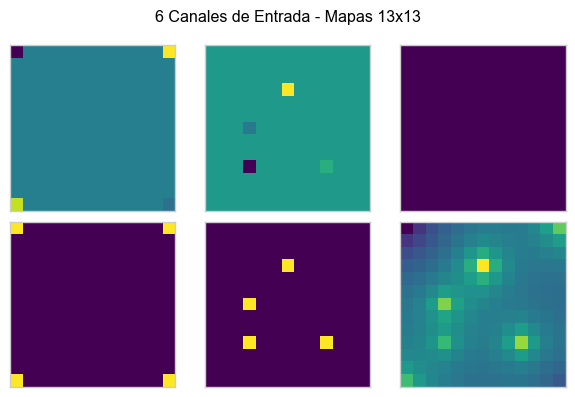

In [13]:
# Ejemplo
x_channel = x_batch[0, -1]
plot_6_canales_mapas(x_channel, save_as_pdf=False, filename="convlstm_entrada", save_individual=False)

### Hyperparameters

Define los hiperparámetros del entrenamiento:

- Número de épocas (`epochs`)
- Tasa de aprendizaje inicial (`lr`) y su factor de decaimiento (`lrdecay`)
- Paciencia para reducir el `lr` (`lrdecay_patience`) y para aplicar `early stopping` (`early_stop_patience`)
- Arquitectura del modelo: número de filtros por capa en `hidden_dims` y tamaño del kernel

Estos valores controlan el comportamiento del optimizador y la estructura de la red ConvLSTM.


In [14]:
# # ⚙️ Hiperparámetros de entrenamiento
# epochs = 1000
# lr = 1e-2
# lrdecay = 0.1
# lrdecay_patience = 10
# early_stop_patience = 50

# # 🧠 Arquitectura ConvLSTM
# hidden_dims = [64, 64]                     # Número de filtros por capa
# num_layers = len(hidden_dims)
# kernel_size = [(3,3)] * num_layers        # Kernel de cada capa (igual para todas)

### Model definition

Define la clase `PCB_ConvLSTM`, una red neuronal basada en ConvLSTM para predecir la evolución térmica en un PCB.

- Usa `ConvLSTM` como núcleo para modelar la secuencia temporal.
- Incluye una capa `Conv2d` de 1x1 al final para proyectar la salida oculta a un canal de temperatura.
- El método `forward` procesa secuencias completas (`seq_len > 1`), mientras que `forward_step` permite avanzar un paso en modo autoregresivo.

Esta arquitectura es adecuada para secuencias espacio-temporales de mapas térmicos.


In [15]:
class PCB_ConvLSTM(nn.Module):
    def __init__(self, input_channels=input_channels, hidden_dims=hidden_dims, kernel_size=kernel_size, height=13, width=13):
        super().__init__()
        self.height = height
        self.width = width
        self.num_layers = len(hidden_dims)

        self.convlstm = ConvLSTM(
            input_dim=input_channels,
            hidden_dim=hidden_dims,
            kernel_size=kernel_size,
            num_layers=self.num_layers,
            batch_first=True,
            bias=True,
            return_all_layers=False
        )
        self.decoder = nn.Conv2d(hidden_dims[-1], 1, kernel_size=1)

    def forward(self, x, hidden=None):
        """
        x      : (B, T, 6, H, W)
        hidden : lista de (h,c) por capa, o None
        returns: preds (B, T, 1, H, W), hidden
        """
        layer_output_list, hidden = self.convlstm(x, hidden)
        h_seq = layer_output_list[0]                # (B, T, hidden_dim, H, W)
        B, T, C_h, H, W = h_seq.shape

        h_flat = h_seq.contiguous().view(B*T, C_h, H, W)
        dec_flat = self.decoder(h_flat)
        preds = dec_flat.view(B, T, 1, H, W)
        return preds, hidden

    def forward_step(self, x_t, hidden=None):
        """
        Un paso de secuencia (seq_len=1).
        x_t    : (B, 1, 6, H, W)
        hidden : estado previo
        returns: pred (B, 1, 1, H, W), hidden
        """
        pred, hidden = self.forward(x_t, hidden)
        return pred, hidden

Instancia el modelo `PCB_ConvLSTM` y lo envía al dispositivo adecuado (`cpu` o `cuda`).

Se define:

- `criterion`: función de pérdida MSE.
- `optimizer`: Adam con la tasa de aprendizaje definida previamente.
- `scheduler`: ReduceLROnPlateau para ajustar el `lr` si la pérdida se estanca.

In [16]:
# Inicializar el modelo
model = PCB_ConvLSTM(
    input_channels=input_channels,
    hidden_dims=hidden_dims,
    kernel_size=kernel_size
).to(device)

# Pérdida y optimizador
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=lrdecay, patience=lrdecay_patience)

num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

# Mostrar información básica del modelo
print(f"Modelo en dispositivo: {device}")
print(f"Parámetros totales: {num_params:,}")

Modelo en dispositivo: cuda
Parámetros totales: 448,321


### Optimización de hiperparámetros con Optuna

In [17]:
# =============== OPTIMIZACIÓN DE HIPERPARÁMETROS CON BASE DE DATOS ===============

import sqlite3
import optuna
from optuna.storages import RDBStorage
import pandas as pd
import time
import json
from pathlib import Path
from tqdm import tqdm  # 🆕 Importar tqdm
import numpy as np
import sys

# 🆕 VARIABLE GLOBAL PARA LA BARRA DE PROGRESO PRINCIPAL
main_progress_bar = None

def run_simple_optuna_study(n_trials=25):
    """
    Ejecuta estudio de Optuna con guardado en base de datos SQLite.
    🆕 CON BARRA DE PROGRESO PRINCIPAL ARRIBA
    """
    global main_progress_bar

    # 🆕 Crear carpeta para bases de datos
    optuna_db_dir = MODELS_PATH / "ConvLSTM_6ch" / "optuna_optimization" / "databases"
    optuna_db_dir.mkdir(parents=True, exist_ok=True)

    # 🆕 Configurar base de datos SQLite
    timestamp = time.strftime("%Y%m%d_%H%M%S")
    db_name = f"convlstm_optimization_{timestamp}.db"
    db_path = optuna_db_dir / db_name

    # 🆕 Crear storage con SQLite
    storage_url = f"sqlite:///{db_path}"
    storage = RDBStorage(url=storage_url)

    study_name = f"convlstm_arch_optimization_{timestamp}"

    # 🆕 CREAR BARRA DE PROGRESO PRINCIPAL PRIMERO (ARRIBA)
    main_progress_bar = tqdm(total=n_trials, 
                            desc="🎯 OPTIMIZACIÓN CONVLSTM", 
                            unit="trial",
                            bar_format="{l_bar}{bar:50}| {n}/{total} trials [{elapsed}<{remaining}, {rate_fmt}] {postfix}",
                            position=0,
                            leave=True,
                            dynamic_ncols=True,
                            file=sys.stdout)

    print(f"\n📁 Base de datos: {db_path}")
    print(f"🏷️ Estudio: {study_name}")
    print(f"🔬 Ejecutando {n_trials} trials...\n")

    try:
        # Crear estudio con storage persistente
        study = optuna.create_study(
            direction='minimize',
            study_name=study_name,
            storage=storage,
            load_if_exists=True,  # Continuar si existe
            pruner=optuna.pruners.MedianPruner(
                n_startup_trials=5,
                n_warmup_steps=10,
                interval_steps=1
            )
        )
        
        # Callback para actualizar la barra principal
        def update_main_progress(study, trial):
            global main_progress_bar
            if main_progress_bar:
                completed = len([t for t in study.trials if t.state == optuna.trial.TrialState.COMPLETE])
                pruned = len([t for t in study.trials if t.state == optuna.trial.TrialState.PRUNED])
                failed = len([t for t in study.trials if t.state == optuna.trial.TrialState.FAIL])
                
                # Obtener mejor valor hasta ahora
                best_value = "N/A"
                if study.best_trial:
                    best_value = f"{study.best_trial.value:.4f}"
                
                # 🆕 INFORMACIÓN MÁS DETALLADA EN LA BARRA
                info = f"Trial #{trial.number} | Mejor: {best_value} | ✅{completed} ✂️{pruned} ❌{failed}"
                main_progress_bar.set_postfix_str(info)
                
                # Incrementar solo si el trial terminó
                if trial.state in [optuna.trial.TrialState.COMPLETE, 
                                 optuna.trial.TrialState.PRUNED, 
                                 optuna.trial.TrialState.FAIL]:
                    main_progress_bar.update(1)

        # 🆕 OPTIMIZAR CON CALLBACK PERSONALIZADO
        study.optimize(objective_convlstm_simple, 
                      n_trials=n_trials, 
                      show_progress_bar=False,  # Desactivar barra de Optuna
                      callbacks=[update_main_progress])
        
        # Cerrar barra principal
        if main_progress_bar:
            main_progress_bar.close()
            main_progress_bar = None

        # 🆕 Guardar metadatos adicionales en la base de datos
        _save_study_metadata(db_path, study, {
            'experiment_type': 'convlstm_architecture_optimization',
            'dataset_info': {
                'n_train': n_train,
                'n_val': n_val,
                'sequence_length': sequence_length,
                'time_sim': time_sim,
                'dt': dt
            },
            'model_config': {
                'input_channels': input_channels,
                'device': str(device)
            },
            'optimization_config': {
                'n_trials': n_trials,
                'pruner': 'MedianPruner'
            }
        })

        print(f"\n✅ Estudio completado y guardado en: {db_path}")
        return study, db_path

    except Exception as e:
        # Cerrar barra principal en caso de error
        if main_progress_bar:
            main_progress_bar.close()
            main_progress_bar = None
        print(f"❌ Error durante optimización: {e}")
        return None, None


def _save_study_metadata(db_path, study, metadata):
    """
    Guarda metadatos adicionales del estudio en la base de datos.
    """
    try:
        conn = sqlite3.connect(str(db_path))
        cursor = conn.cursor()

        # Crear tabla de metadatos si no existe
        cursor.execute('''
            CREATE TABLE IF NOT EXISTS study_metadata (
                id INTEGER PRIMARY KEY AUTOINCREMENT,
                study_name TEXT,
                metadata_key TEXT,
                metadata_value TEXT,
                created_at TIMESTAMP DEFAULT CURRENT_TIMESTAMP
            )
        ''')

        # Insertar metadatos
        import json
        for key, value in metadata.items():
            cursor.execute('''
                INSERT INTO study_metadata (study_name, metadata_key, metadata_value)
                VALUES (?, ?, ?)
            ''', (study.study_name, key, json.dumps(value)))

        # Insertar información del mejor trial
        if study.best_trial:
            best_trial_info = {
                'best_value': study.best_trial.value,
                'best_params': study.best_trial.params,
                'best_trial_number': study.best_trial.number,
                'n_completed_trials': len([t for t in study.trials if t.state == optuna.trial.TrialState.COMPLETE])
            }
            cursor.execute('''
                INSERT INTO study_metadata (study_name, metadata_key, metadata_value)
                VALUES (?, ?, ?)
            ''', (study.study_name, 'best_trial_summary', json.dumps(best_trial_info)))

        conn.commit()
        conn.close()
        print(f"💾 Metadatos guardados en la base de datos")

    except Exception as e:
        print(f"⚠️ Error guardando metadatos: {e}")


def analyze_optuna_database(db_path):
    """
    Analiza la base de datos de Optuna y muestra estadísticas detalladas.
    """
    if not Path(db_path).exists():
        print(f"❌ Base de datos no encontrada: {db_path}")
        return

    print(f"📊 ANÁLISIS DE BASE DE DATOS OPTUNA")
    print("="*50)
    print(f"📁 Archivo: {Path(db_path).name}")

    try:
        conn = sqlite3.connect(str(db_path))

        # Información de estudios
        studies_df = pd.read_sql_query("SELECT * FROM studies", conn)
        print(f"\n🔬 ESTUDIOS EN LA BASE DE DATOS:")
        for _, study in studies_df.iterrows():
            print(f"   📋 {study['study_name']} (ID: {study['study_id']})")
            print(f"      Dirección: {study['direction']}")

        # Información de trials
        trials_df = pd.read_sql_query("""
            SELECT trial_id, number, state, value, datetime_start, datetime_complete
            FROM trials ORDER BY number
        """, conn)

        completed_trials = trials_df[trials_df['state'] == 'COMPLETE']
        print(f"\n📈 TRIALS:")
        print(f"   Total: {len(trials_df)}")
        print(f"   Completados: {len(completed_trials)}")
        print(f"   Podados: {len(trials_df[trials_df['state'] == 'PRUNED'])}")
        print(f"   Fallidos: {len(trials_df[trials_df['state'] == 'FAIL'])}")

        if len(completed_trials) > 0:
            print(f"\n🏆 MEJORES RESULTADOS:")
            best_trials = completed_trials.nsmallest(5, 'value')
            for _, trial in best_trials.iterrows():
                print(f"   Trial #{trial['number']}: {trial['value']:.6f}")

        # Información de parámetros
        params_df = pd.read_sql_query("SELECT * FROM trial_params", conn)
        if len(params_df) > 0:
            print(f"\n⚙️ PARÁMETROS EXPLORADOS:")
            unique_params = params_df['param_name'].unique()
            for param in unique_params:
                param_values = params_df[params_df['param_name'] == param]['param_value'].unique()
                print(f"   {param}: {len(param_values)} valores únicos")

        # Metadatos si existen
        try:
            metadata_df = pd.read_sql_query("SELECT * FROM study_metadata", conn)
            print(f"\n📋 METADATOS: {len(metadata_df)} entradas guardadas")
        except:
            print(f"\n📋 METADATOS: No disponibles")

        conn.close()

        return {
            'db_path': db_path,
            'studies': studies_df,
            'trials': trials_df,
            'params': params_df,
            'n_completed': len(completed_trials)
        }

    except Exception as e:
        print(f"❌ Error analizando base de datos: {e}")
        return None


def load_study_from_database(db_path, study_name=None):
    """
    Carga un estudio desde la base de datos SQLite.
    """
    if not Path(db_path).exists():
        print(f"❌ Base de datos no encontrada: {db_path}")
        return None

    try:
        storage_url = f"sqlite:///{db_path}"
        storage = RDBStorage(url=storage_url)

        # Si no se especifica estudio, usar el primero disponible
        if study_name is None:
            conn = sqlite3.connect(str(db_path))
            studies_df = pd.read_sql_query("SELECT study_name FROM studies LIMIT 1", conn)
            conn.close()
            if len(studies_df) == 0:
                print("❌ No hay estudios en la base de datos")
                return None
            study_name = studies_df.iloc[0]['study_name']

        study = optuna.load_study(study_name=study_name, storage=storage)
        print(f"✅ Estudio '{study_name}' cargado desde base de datos")
        return study

    except Exception as e:
        print(f"❌ Error cargando estudio: {e}")
        return None


def create_optuna_dashboard_script(db_path):
    """
    Crea un script Python para lanzar el dashboard de Optuna.
    """
    dashboard_dir = Path(db_path).parent / "dashboard"
    dashboard_dir.mkdir(exist_ok=True)

    script_path = dashboard_dir / "launch_dashboard.py"

    script_content = f'''#!/usr/bin/env python3
"""
Script para lanzar el dashboard de Optuna.
Ejecutar con: python launch_dashboard.py
"""

import optuna

def main():
    # Ruta a la base de datos
    db_path = r"{db_path}"
    storage_url = f"sqlite:///{{db_path}}"

    print("🚀 Iniciando dashboard de Optuna...")
    print(f"📁 Base de datos: {{db_path}}")
    print("🌐 Dashboard disponible en: http://localhost:8080")
    print("💡 Presiona Ctrl+C para detener")

    try:
        # Lanzar dashboard
        optuna.dashboard.run_server(storage=storage_url, host="localhost", port=8080)
    except KeyboardInterrupt:
        print("\\n👋 Dashboard detenido")
    except Exception as e:
        print(f"❌ Error: {{e}}")
        print("💡 Instala optuna-dashboard: pip install optuna-dashboard")

if __name__ == "__main__":
    main()
'''

    with open(script_path, 'w') as f:
        f.write(script_content)

    print(f"📄 Script del dashboard creado: {script_path}")
    print(f"💡 Para usar: cd {dashboard_dir} && python launch_dashboard.py")

    return script_path


def create_optimization_plots_from_db(db_path, save_plots=True):
    """
    Crea gráficos de análisis de optimización desde la base de datos.
    """
    if not Path(db_path).exists():
        print(f"❌ Base de datos no encontrada: {db_path}")
        return

    try:
        conn = sqlite3.connect(str(db_path))

        # Cargar datos de trials
        trials_df = pd.read_sql_query("""
            SELECT t.trial_id, t.number, t.state, t.value,
                   p1.param_value as num_layers,
                   p2.param_value as kernel_size,
                   p3.param_value as lr
            FROM trials t
            LEFT JOIN trial_params p1 ON t.trial_id = p1.trial_id AND p1.param_name = 'num_layers'
            LEFT JOIN trial_params p2 ON t.trial_id = p2.trial_id AND p2.param_name = 'kernel_size'
            LEFT JOIN trial_params p3 ON t.trial_id = p3.trial_id AND p3.param_name = 'lr'
            WHERE t.state = 'COMPLETE'
            ORDER BY t.number
        """, conn)

        if len(trials_df) == 0:
            print("❌ No hay trials completados para analizar")
            conn.close()
            return

        # Crear figura con subplots
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))
        fig.suptitle('Análisis de Optimización Optuna', fontsize=16)

        # 1. Evolución de la función objetivo
        axes[0,0].plot(trials_df['number'], trials_df['value'], 'b-', alpha=0.7)
        axes[0,0].plot(trials_df['number'], trials_df['value'].cummin(), 'r-', linewidth=2, label='Mejor hasta ahora')
        axes[0,0].set_xlabel('Trial')
        axes[0,0].set_ylabel('Validation Loss')
        axes[0,0].set_title('Evolución de la Función Objetivo')
        axes[0,0].legend()
        axes[0,0].grid(True, alpha=0.3)

        # 2. Distribución de pérdidas por número de capas
        if 'num_layers' in trials_df.columns and trials_df['num_layers'].notna().any():
            trials_df['num_layers'] = trials_df['num_layers'].astype(int)
            for layers in sorted(trials_df['num_layers'].unique()):
                subset = trials_df[trials_df['num_layers'] == layers]
                axes[0,1].scatter(subset['number'], subset['value'],
                                label=f'{layers} capas', alpha=0.7)
            axes[0,1].set_xlabel('Trial')
            axes[0,1].set_ylabel('Validation Loss')
            axes[0,1].set_title('Pérdida por Número de Capas')
            axes[0,1].legend()
            axes[0,1].grid(True, alpha=0.3)

        # 3. Boxplot de pérdidas por kernel size
        if 'kernel_size' in trials_df.columns and trials_df['kernel_size'].notna().any():
            kernel_data = []
            kernel_labels = []
            for ks in sorted(trials_df['kernel_size'].unique()):
                subset = trials_df[trials_df['kernel_size'] == ks]['value']
                if len(subset) > 0:
                    kernel_data.append(subset)
                    kernel_labels.append(f'{ks}x{ks}')

            if kernel_data:
                axes[1,0].boxplot(kernel_data, labels=kernel_labels)
                axes[1,0].set_xlabel('Kernel Size')
                axes[1,0].set_ylabel('Validation Loss')
                axes[1,0].set_title('Distribución por Tamaño de Kernel')
                axes[1,0].grid(True, alpha=0.3)

        # 4. Histograma de validation loss
        axes[1,1].hist(trials_df['value'], bins=20, alpha=0.7, edgecolor='black')
        axes[1,1].axvline(trials_df['value'].min(), color='red', linestyle='--',
                         label=f'Mejor: {trials_df["value"].min():.6f}')
        axes[1,1].set_xlabel('Validation Loss')
        axes[1,1].set_ylabel('Frecuencia')
        axes[1,1].set_title('Distribución de Validation Loss')
        axes[1,1].legend()
        axes[1,1].grid(True, alpha=0.3)

        plt.tight_layout()

        if save_plots:
            plots_dir = Path(db_path).parent / "analysis_plots"
            plots_dir.mkdir(exist_ok=True)
            plot_path = plots_dir / f"optimization_analysis_{Path(db_path).stem}.pdf"
            plt.savefig(plot_path, format='pdf', bbox_inches='tight')
            print(f"📊 Gráficos guardados en: {plot_path}")

        plt.show()
        conn.close()

    except Exception as e:
        print(f"❌ Error creando gráficos: {e}")


def optimize_convlstm_architecture_with_models_and_db(n_trials=25):
    """
    Función principal para optimizar arquitectura ConvLSTM con guardado de modelos y base de datos.
    """

    print(f"🎯 OPTIMIZACIÓN CONVLSTM CON MODELOS Y BASE DE DATOS")
    print("="*70)
    print(f"🔬 Trials a ejecutar: {n_trials}")
    print(f"⚡ Dispositivo: {device}")
    print(f"🎯 Enfoque: Solo arquitectura (sin física)")
    print(f"📊 Datos de entrenamiento: {min(300, n_train)} muestras")
    print(f"📊 Datos de validación: {min(100, n_val)} muestras")
    print(f"💾 Modelos se guardarán en: {MODELS_PATH / 'ConvLSTM_6ch' / 'optuna_optimization'}")
    print(f"🗄️ Base de datos se guardará automáticamente")

    # Ejecutar estudio con base de datos
    study, db_path = run_simple_optuna_study(n_trials=n_trials)

    if study is None:
        print("❌ No se pudo ejecutar el estudio")
        return None, None, None, None, None

    # Analizar base de datos
    db_analysis = analyze_optuna_database(db_path)

    # Crear script del dashboard
    dashboard_script = create_optuna_dashboard_script(db_path)

    # Analizar resultados con información de modelos
    analyze_simple_results_with_models(study)

    # Extraer mejores hiperparámetros y rutas de archivos
    best_hyperparams, best_model_path, best_json_path = get_best_hyperparameters_with_model(study)

    print(f"\n🎉 ¡OPTIMIZACIÓN COMPLETADA!")
    print(f"💾 Mejor modelo: {best_model_path}")
    print(f"📄 Configuración: {best_json_path}")
    print(f"🗄️ Base de datos: {db_path}")
    print(f"📊 Dashboard script: {dashboard_script}")

    # Instrucciones para el usuario
    print(f"\n💡 CÓMO USAR LOS RESULTADOS:")
    print(f"   1. Ver estadísticas interactivas:")
    print(f"      cd {Path(dashboard_script).parent}")
    print(f"      python launch_dashboard.py")
    print(f"   2. Cargar estudio en notebook:")
    print(f"      study = load_study_from_database(r'{db_path}')")
    print(f"   3. Analizar base de datos:")
    print(f"      db_info = analyze_optuna_database(r'{db_path}')")

    return study, best_hyperparams, best_model_path, best_json_path, db_path

# =============== FUNCIONES FALTANTES PARA OPTIMIZACIÓN ===============

def objective_convlstm_simple(trial):
    """
    🆕 Función objetivo para Optuna - VERSIÓN ULTRA LIMPIA
    """

    # Sugerir hiperparámetros
    num_layers = trial.suggest_int('num_layers', 1, 4)
    kernel_size = trial.suggest_categorical('kernel_size', [1, 3, 5, 7])
    lr = trial.suggest_categorical('lr', [1e-5, 1e-4, 1e-3, 1e-2, 1e-1])
    batch_size = trial.suggest_categorical('batch_size', [8, 16, 32, 64, 128, 256])

    # Crear dimensiones ocultas
    base_dim = trial.suggest_categorical('base_dim', [16, 32, 64, 128])
    hidden_dims = [base_dim] * num_layers
    kernel_size_list = [(kernel_size, kernel_size)] * num_layers

    try:
        # 🆕 VALIDACIÓN TEMPRANA: Verificar memoria GPU
        if torch.cuda.is_available():
            memory_allocated = torch.cuda.memory_allocated() / (1024**3)  # GB
            total_memory = torch.cuda.get_device_properties(0).total_memory / (1024**3)  # GB
            
            # Si la memoria está muy cargada, podar el trial
            if memory_allocated > total_memory * 0.8:
                raise optuna.TrialPruned()

        # Crear modelo
        model_trial = PCB_ConvLSTM(
            input_channels=input_channels,
            hidden_dims=hidden_dims,
            kernel_size=kernel_size_list
        ).to(device)

        # 🆕 VALIDACIÓN: Verificar si el modelo es demasiado grande
        num_params = sum(p.numel() for p in model_trial.parameters())
        if num_params > 10_000_000:  # 10M parámetros máximo
            del model_trial
            torch.cuda.empty_cache() if torch.cuda.is_available() else None
            raise optuna.TrialPruned()

        # Optimizador
        optimizer_trial = torch.optim.Adam(model_trial.parameters(), lr=lr)
        criterion_trial = nn.MSELoss()

        # Configuración de entrenamiento
        max_epochs = 50
        best_val_loss = float('inf')
        patience = 10
        epochs_without_improvement = 0
        
        # 🆕 LÍMITES PARA PODADO TEMPRANO
        loss_threshold = 10.0  # Si val_loss > 10, podar
        consecutive_bad_epochs = 0
        max_consecutive_bad = 5

        # Usar subconjunto de datos para velocidad
        train_subset = torch.utils.data.Subset(dataset_train, range(min(300, len(dataset_train))))
        val_subset = torch.utils.data.Subset(dataset_val, range(min(100, len(dataset_val))))

        train_loader_trial = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
        val_loader_trial = DataLoader(val_subset, batch_size=batch_size, shuffle=False)

        # 🆕 ENTRENAMIENTO SILENCIOSO
        for epoch in range(max_epochs):
            try:
                # Entrenamiento
                model_trial.train()
                train_loss = 0.0

                for x_batch, y_batch in train_loader_trial:
                    x_batch, y_batch = x_batch.to(device), y_batch.to(device)

                    optimizer_trial.zero_grad()

                    # Forward autoregresivo simple
                    bc_seq = x_batch[:, :, :5]
                    t_prev = x_batch[:, 0, 5:6]
                    hidden = None
                    loss_accum = 0.0

                    for t in range(y_batch.shape[1]):
                        if t == 0:
                            t_in = t_prev
                        else:
                            # Usar ground truth para estabilidad en optimización
                            t_in = y_batch[:, t-1]

                        x_t = torch.cat([bc_seq[:, t], t_in], dim=1).unsqueeze(1)
                        pred_seq, hidden = model_trial(x_t, hidden)
                        t_prev = pred_seq[:, 0]
                        
                        # 🆕 CHEQUEO: Si loss individual es muy alta, podar
                        step_loss = criterion_trial(t_prev, y_batch[:, t])
                        if not torch.isfinite(step_loss) or step_loss.item() > 50.0:
                            del model_trial
                            torch.cuda.empty_cache() if torch.cuda.is_available() else None
                            raise optuna.TrialPruned()
                        
                        loss_accum += step_loss

                    loss_batch = loss_accum / y_batch.shape[1]
                    
                    # 🆕 CHEQUEO: Si batch loss es muy alta, podar
                    if not torch.isfinite(loss_batch) or loss_batch.item() > 20.0:
                        del model_trial
                        torch.cuda.empty_cache() if torch.cuda.is_available() else None
                        raise optuna.TrialPruned()
                    
                    loss_batch.backward()

                    # Gradient clipping más agresivo
                    torch.nn.utils.clip_grad_norm_(model_trial.parameters(), 0.5)

                    optimizer_trial.step()
                    train_loss += loss_batch.item()

                # Validación
                model_trial.eval()
                val_loss = 0.0

                with torch.no_grad():
                    for x_batch, y_batch in val_loader_trial:
                        x_batch, y_batch = x_batch.to(device), y_batch.to(device)

                        bc_seq = x_batch[:, :, :5]
                        t_prev = x_batch[:, 0, 5:6]
                        hidden = None
                        loss_accum = 0.0

                        for t in range(y_batch.shape[1]):
                            if t == 0:
                                t_in = t_prev
                            else:
                                t_in = y_batch[:, t-1]  # Usar GT para estabilidad

                            x_t = torch.cat([bc_seq[:, t], t_in], dim=1).unsqueeze(1)
                            pred_seq, hidden = model_trial(x_t, hidden)
                            t_prev = pred_seq[:, 0]
                            loss_accum += criterion_trial(t_prev, y_batch[:, t])

                        val_loss += (loss_accum / y_batch.shape[1]).item()

                avg_val_loss = val_loss / len(val_loader_trial)

                # 🆕 CHEQUEOS DE PODADO MÁS ESTRICTOS
                
                # 1. Si validation loss es demasiado alta
                if avg_val_loss > loss_threshold:
                    consecutive_bad_epochs += 1
                    if consecutive_bad_epochs >= max_consecutive_bad:
                        del model_trial
                        torch.cuda.empty_cache() if torch.cuda.is_available() else None
                        raise optuna.TrialPruned()
                else:
                    consecutive_bad_epochs = 0

                # 2. Si val loss no es finita
                if not np.isfinite(avg_val_loss):
                    del model_trial
                    torch.cuda.empty_cache() if torch.cuda.is_available() else None
                    raise optuna.TrialPruned()

                # Early stopping normal
                if avg_val_loss < best_val_loss:
                    best_val_loss = avg_val_loss
                    epochs_without_improvement = 0
                else:
                    epochs_without_improvement += 1
                    if epochs_without_improvement >= patience:
                        break

                # 🆕 PODADO DE OPTUNA MÁS FRECUENTE (cada época)
                trial.report(avg_val_loss, epoch)
                if trial.should_prune():
                    del model_trial
                    torch.cuda.empty_cache() if torch.cuda.is_available() else None
                    raise optuna.TrialPruned()

            except optuna.TrialPruned:
                # Re-lanzar la excepción de podado
                raise
            except Exception as e:
                # 🆕 CUALQUIER OTRO ERROR -> PODAR EN LUGAR DE INF
                del model_trial
                torch.cuda.empty_cache() if torch.cuda.is_available() else None
                raise optuna.TrialPruned()

        # Limpiar memoria
        del model_trial
        torch.cuda.empty_cache() if torch.cuda.is_available() else None

        return best_val_loss

    except optuna.TrialPruned:
        # Re-lanzar la excepción de podado (importante!)
        raise
    except Exception as e:
        # 🆕 CUALQUIER ERROR NO MANEJADO -> PODAR
        # Limpiar memoria si es posible
        try:
            torch.cuda.empty_cache() if torch.cuda.is_available() else None
        except:
            pass
        raise optuna.TrialPruned()


def analyze_simple_results_with_models(study):
    """
    Analiza resultados de Optuna y muestra información de modelos guardados.
    🆕 INCLUYE ESTADÍSTICAS DE PODADO Y BATCH_SIZE
    """
    if study is None or len(study.trials) == 0:
        print("❌ No hay trials para analizar")
        return

    print(f"\n📊 ANÁLISIS DE RESULTADOS DE OPTIMIZACIÓN")
    print("="*50)

    # 🆕 ESTADÍSTICAS DETALLADAS INCLUYENDO PODADO
    completed_trials = [t for t in study.trials if t.state == optuna.trial.TrialState.COMPLETE]
    pruned_trials = [t for t in study.trials if t.state == optuna.trial.TrialState.PRUNED]
    failed_trials = [t for t in study.trials if t.state == optuna.trial.TrialState.FAIL]

    print(f"📈 Trials completados: {len(completed_trials)}")
    print(f"✂️ Trials podados: {len(pruned_trials)} (podado inteligente)")
    print(f"❌ Trials fallidos: {len(failed_trials)} (errores no manejados)")
    print(f"💡 Eficiencia de podado: {len(pruned_trials)/(len(study.trials))*100:.1f}% trials podados")

    if len(completed_trials) == 0:
        print("⚠️ No hay trials completados para analizar")
        print("💡 Esto puede indicar que los parámetros son demasiado agresivos")
        return

    # Mejor trial
    best_trial = study.best_trial
    print(f"\n🏆 MEJOR CONFIGURACIÓN:")
    print(f"   Trial #{best_trial.number}")
    print(f"   Validation Loss: {best_trial.value:.6f}")
    print(f"   Parámetros:")
    for key, value in best_trial.params.items():
        print(f"     {key}: {value}")

    # 🆕 TOP 5 CONFIGURACIONES CON BATCH_SIZE
    print(f"\n🥇 TOP 5 CONFIGURACIONES:")
    sorted_trials = sorted(completed_trials, key=lambda t: t.value)
    for i, trial in enumerate(sorted_trials[:5]):
        print(f"   #{i+1}: Trial {trial.number} - Loss: {trial.value:.6f}")
        print(f"        Layers: {trial.params.get('num_layers', 'N/A')}, "
              f"Kernel: {trial.params.get('kernel_size', 'N/A')}, "
              f"Batch: {trial.params.get('batch_size', 'N/A')}, "
              f"LR: {trial.params.get('lr', 'N/A'):.2e}")

    # 🆕 ANÁLISIS DE PODADO
    print(f"\n✂️ ANÁLISIS DE PODADO:")
    if len(pruned_trials) > 0:
        pruning_epochs = []
        for trial in pruned_trials:
            if hasattr(trial, 'intermediate_values') and trial.intermediate_values:
                last_epoch = max(trial.intermediate_values.keys())
                pruning_epochs.append(last_epoch)
        
        if pruning_epochs:
            avg_pruning_epoch = np.mean(pruning_epochs)
            print(f"   📊 Época promedio de podado: {avg_pruning_epoch:.1f}")
            print(f"   ⚡ Esto ahorró ~{(50-avg_pruning_epoch)*len(pruned_trials):.0f} épocas de entrenamiento")

    # 🆕 ANÁLISIS DE HIPERPARÁMETROS INCLUYENDO BATCH_SIZE
    print(f"\n⚙️ ANÁLISIS DE HIPERPARÁMETROS:")

    # Por número de capas
    layers_performance = {}
    for trial in completed_trials:
        layers = trial.params.get('num_layers')
        if layers is not None:
            if layers not in layers_performance:
                layers_performance[layers] = []
            layers_performance[layers].append(trial.value)

    if layers_performance:
        print(f"   📊 Rendimiento por número de capas:")
        for layers in sorted(layers_performance.keys()):
            losses = layers_performance[layers]
            avg_loss = np.mean(losses)
            min_loss = np.min(losses)
            print(f"     {layers} capas: Promedio={avg_loss:.6f}, Mejor={min_loss:.6f} ({len(losses)} trials)")

    # Por kernel size
    kernel_performance = {}
    for trial in completed_trials:
        kernel = trial.params.get('kernel_size')
        if kernel is not None:
            if kernel not in kernel_performance:
                kernel_performance[kernel] = []
            kernel_performance[kernel].append(trial.value)

    if kernel_performance:
        print(f"   🔧 Rendimiento por kernel size:")
        for kernel in sorted(kernel_performance.keys()):
            losses = kernel_performance[kernel]
            avg_loss = np.mean(losses)
            min_loss = np.min(losses)
            print(f"     {kernel}x{kernel}: Promedio={avg_loss:.6f}, Mejor={min_loss:.6f} ({len(losses)} trials)")

    # 🆕 Por batch size
    batch_performance = {}
    for trial in completed_trials:
        batch = trial.params.get('batch_size')
        if batch is not None:
            if batch not in batch_performance:
                batch_performance[batch] = []
            batch_performance[batch].append(trial.value)

    if batch_performance:
        print(f"   📦 Rendimiento por batch size:")
        for batch in sorted(batch_performance.keys()):
            losses = batch_performance[batch]
            avg_loss = np.mean(losses)
            min_loss = np.min(losses)
            print(f"     Batch {batch}: Promedio={avg_loss:.6f}, Mejor={min_loss:.6f} ({len(losses)} trials)")

    # Información de modelos guardados
    models_dir = MODELS_PATH / "ConvLSTM_6ch" / "optuna_optimization" / "models"
    if models_dir.exists():
        model_files = list(models_dir.glob("*.pth"))
        print(f"\n💾 MODELOS GUARDADOS: {len(model_files)} archivos")
        if len(model_files) > 0:
            print(f"   📁 Directorio: {models_dir}")
            print(f"   🏆 Mejor modelo disponible para trial #{best_trial.number}")


def get_best_hyperparameters_with_model(study):
    """
    Extrae los mejores hiperparámetros y rutas de archivos del mejor trial.
    (Sin cambios)
    """
    if study is None or study.best_trial is None:
        print("❌ No hay mejor trial disponible")
        return None, None, None

    best_trial = study.best_trial

    # Extraer hiperparámetros
    num_layers = best_trial.params.get('num_layers', 2)
    kernel_size = best_trial.params.get('kernel_size', 3)
    base_dim = best_trial.params.get('base_dim', 64)
    lr = best_trial.params.get('lr', 1e-3)
    batch_size = best_trial.params.get('batch_size', 8)

    # Construir configuración
    hidden_dims = [base_dim] * num_layers
    kernel_size_list = [(kernel_size, kernel_size)] * num_layers

    best_hyperparams = {
        'num_layers': num_layers,
        'hidden_dims': hidden_dims,
        'kernel_size': kernel_size_list,
        'base_dim': base_dim,
        'lr': lr,
        'batch_size': batch_size,
        'trial_number': best_trial.number,
        'best_loss': best_trial.value
    }

    # Construir rutas de archivos (aunque no se hayan guardado en esta implementación)
    models_dir = MODELS_PATH / "ConvLSTM_6ch" / "optuna_optimization" / "models"
    model_filename = f"trial_{best_trial.number}_convlstm_layers{num_layers}_kernel{kernel_size}_dim{base_dim}.pth"
    json_filename = f"trial_{best_trial.number}_convlstm_layers{num_layers}_kernel{kernel_size}_dim{base_dim}.json"

    best_model_path = models_dir / model_filename
    best_json_path = models_dir / json_filename

    # Verificar si existen
    if not best_model_path.exists():
        print(f"⚠️ Archivo de modelo no encontrado: {best_model_path}")
        best_model_path = None

    if not best_json_path.exists():
        print(f"⚠️ Archivo de configuración no encontrado: {best_json_path}")
        best_json_path = None

    print(f"\n✅ MEJORES HIPERPARÁMETROS EXTRAÍDOS:")
    print(f"   Trial: #{best_trial.number}")
    print(f"   Validation Loss: {best_trial.value:.6f}")
    print(f"   Arquitectura: {num_layers} capas, kernel {kernel_size}x{kernel_size}, dim {base_dim}")
    print(f"   Batch Size: {batch_size}")
    print(f"   Learning Rate: {lr:.2e}")

    return best_hyperparams, best_model_path, best_json_path

In [18]:
# Ejecutar optimización completa con base de datos
study = None # Inicializar en None para evitar errores si no se ejecuta
# study, best_hyperparams, best_model_path, best_json_path, db_path = optimize_convlstm_architecture_with_models_and_db(n_trials=50)

if study is not None:
    print(f"\n🎉 ¡Optimización completada!")
    print(f"💾 Mejor modelo guardado en: {best_model_path}")
    print(f"📄 Configuración en: {best_json_path}")
    print(f"🗄️ Base de datos en: {db_path}")

    # Cargar el mejor modelo encontrado
    if best_model_path:
        best_model = PCB_ConvLSTM(
            input_channels=input_channels,
            hidden_dims=best_hyperparams['hidden_dims'],
            kernel_size=best_hyperparams['kernel_size']
        ).to(device)
        best_model.load_state_dict(torch.load(best_model_path))
        print(f"✅ Mejor modelo cargado exitosamente")

    # Análisis adicional de la base de datos
    print(f"\n📊 Creando gráficos de análisis...")
    create_optimization_plots_from_db(db_path, save_plots=True)

### Entrenamiento del modelo


Define los hiperparámetros para el *scheduled sampling*, una técnica para entrenamiento autoregresivo:

- `p0`: probabilidad inicial de usar el valor real (ground truth).
- `p_min`: probabilidad mínima de usar GT al final del entrenamiento.
- `decay_epochs`: número de épocas en las que se reducirá `p0` hasta `p_min`.

Esta técnica ayuda a la red a adaptarse gradualmente a predecir sin necesidad del ground truth.


Inicializa las variables de entrenamiento y prepara el sistema para **reanudar una sesión previa** si existe:

- Crea la carpeta de salida.
- Construye el nombre del fichero de modelo según los hiperparámetros.
- Si encuentra un modelo `.pth` guardado, lo carga junto con su configuración `.json`.
- Si no hay modelo previo, inicia un nuevo entrenamiento desde cero.

Esta lógica permite continuar el entrenamiento sin perder el progreso.


In [19]:
# Puedes cambiar esta ruta a mano si quieres usar una carpeta concreta
# Si dejas None, guardará en MODELS_PATH/ConvLSTM_6ch/stateful_O2O
custom_model_dir = None  # por ejemplo: Path("~/experimentos/cheops_v3").expanduser()

# ----------- Configurar ruta de guardado -----------
kernel_string = f"{kernel_size[0][0]}x{kernel_size[0][1]}"
layer_string = "-".join(str(d) for d in hidden_dims)

if custom_model_dir is None:
    model_dir = MODELS_PATH / "ConvLSTM_6ch" / "stateful_O2O"
else:
    model_dir = Path(custom_model_dir).resolve()

model_dir.mkdir(parents=True, exist_ok=True)

filename = f"PCB_ConvLSTM_6ch_nt{n_train}_{time_sim}s_dt{dt}_bs{batch_size}_h{layer_string}_k{kernel_string}.pth"
model_path = model_dir / filename
json_path = model_path.with_suffix(".json")

# ----------- Inicialización de estado -----------
train_loss = []
val_loss = []
best_val_loss = np.inf
elapsed_previous = 0.0
start_epoch = 0
start_datetime = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
epochs_without_improvement = 0

# ----------- Lógica de reanudación -----------
if model_path.exists():
    display(Markdown(f"🔁 Cargando modelo existente `{filename}` y reanudando entrenamiento."))
    model.load_state_dict(torch.load(model_path, map_location=device))

    if json_path.exists():
        try:
            with open(json_path, 'r') as f:
                prev = json.load(f)
            best_val_loss = prev.get('best_val_loss', best_val_loss)
            train_loss = prev.get('train_loss', [])
            val_loss = prev.get('val_loss', [])
            elapsed_previous = prev.get('training_duration_minutes', 0.0)
            start_datetime = prev.get('start_datetime', start_datetime)
            start_epoch = prev.get('epochs_trained', 0)
            epochs_without_improvement = 0
        except json.JSONDecodeError:
            print(f"⚠️ El archivo {json_path} está vacío o corrupto. Se reinician los contadores.")
    else:
        display(Markdown("⚠️ No se encontró JSON de hiperparámetros; se reinicia contadores."))
else:
    display(Markdown(f"✨ Nuevo entrenamiento: `{filename}`"))

print("📁 Los resultados se guardarán en:", json_path)


✨ Nuevo entrenamiento: `PCB_ConvLSTM_6ch_nt1000_50s_dt1_bs32_h64_k5x5.pth`

📁 Los resultados se guardarán en: c:\Users\ismael.gallo\Desktop\ia_thermal\ismaelgallo\models\ConvLSTM_6ch\stateful_O2O\PCB_ConvLSTM_6ch_nt1000_50s_dt1_bs32_h64_k5x5.json


Define el **bucle de entrenamiento completo** para la red `PCB_ConvLSTM`, incluyendo:

- Entrenamiento paso a paso con *scheduled sampling* autoregresivo.
- Validación del modelo tras cada época.
- Ajuste automático de la tasa de aprendizaje con `ReduceLROnPlateau`.
- Early stopping si no hay mejora tras cierto número de épocas.
- Guardado del mejor modelo y de los resultados en un archivo `.json`.

El entrenamiento es completamente reproducible y robusto frente a interrupciones.


In [20]:
# 1) Desactivar CUDAGraphs globalmente (antes de importar torch._inductor)
os.environ["TORCHINDUCTOR_DISABLE_CUDAGRAPHS"] = "1"

# 2) Imports y configuración
import json
import time
import torch
import torch._dynamo
from torch import amp
from tqdm import tqdm
from contextlib import nullcontext
import platform
import psutil  # 🆕 Agregar para capturar specs del sistema

# Si torch.compile lanza errores, cae a modo eager
torch._dynamo.config.suppress_errors = True

def get_system_specs():
    """
    🆕 Función para capturar automáticamente las especificaciones del sistema (CORREGIDA)
    """
    try:
        specs = {
            'platform': platform.platform(),
            'processor': platform.processor(),
            'python_version': platform.python_version(),
            'torch_version': torch.__version__,
            'cuda_available': torch.cuda.is_available(),
            'cuda_version': torch.version.cuda if torch.cuda.is_available() else None,
            'cudnn_version': torch.backends.cudnn.version() if torch.cuda.is_available() else None,
            'gpu_count': torch.cuda.device_count() if torch.cuda.is_available() else 0,
            'cpu_count_physical': psutil.cpu_count(logical=False),
            'cpu_count_logical': psutil.cpu_count(logical=True),
            'memory_total_gb': round(psutil.virtual_memory().total / (1024**3), 2),
            'memory_available_gb': round(psutil.virtual_memory().available / (1024**3), 2)
        }
        
        # Información detallada de GPU si está disponible
        if torch.cuda.is_available():
            gpu_info = {}
            for i in range(torch.cuda.device_count()):
                props = torch.cuda.get_device_properties(i)
                gpu_info[f'gpu_{i}'] = {
                    'name': props.name,
                    'memory_total_gb': round(props.total_memory / (1024**3), 2),
                    'compute_capability': f"{props.major}.{props.minor}",
                    # 🆕 CORREGIDO: usar multi_processor_count en lugar de multiprocessor_count
                    'multi_processor_count': props.multi_processor_count
                }
            specs['gpu_details'] = gpu_info
            specs['primary_gpu_name'] = torch.cuda.get_device_name(0)
            
            # 🆕 Información adicional de CUDA
            specs['cuda_device_capability'] = torch.cuda.get_device_capability(0)
            specs['cuda_memory_allocated_gb'] = round(torch.cuda.memory_allocated(0) / (1024**3), 2)
            specs['cuda_memory_reserved_gb'] = round(torch.cuda.memory_reserved(0) / (1024**3), 2)
        
        return specs
        
    except Exception as e:
        # 🆕 Captura básica si falla la detallada
        try:
            basic_specs = {
                'platform': platform.platform(),
                'python_version': platform.python_version(),
                'torch_version': torch.__version__,
                'cuda_available': torch.cuda.is_available(),
                'cpu_count': psutil.cpu_count(logical=True),
                'memory_total_gb': round(psutil.virtual_memory().total / (1024**3), 2),
                'error_detailed': f'Detailed capture failed: {str(e)}',
                'fallback_mode': True
            }
            
            if torch.cuda.is_available():
                basic_specs['gpu_count'] = torch.cuda.device_count()
                basic_specs['primary_gpu_name'] = torch.cuda.get_device_name(0)
                
            return basic_specs
            
        except Exception as e2:
            return {
                'error': f'Could not capture system specs: {str(e2)}',
                'original_error': str(e),
                'minimal_info': {
                    'torch_version': torch.__version__ if 'torch' in globals() else 'unknown',
                    'cuda_available': torch.cuda.is_available() if 'torch' in globals() else False
                }
            }

def verificar_gpu_properties():
    """
    🆕 Función para verificar qué propiedades están disponibles en tu GPU
    """
    if not torch.cuda.is_available():
        print("❌ CUDA no disponible")
        return
    
    print("🔍 PROPIEDADES DISPONIBLES EN GPU:")
    props = torch.cuda.get_device_properties(0)
    
    # Listar todos los atributos disponibles
    available_attrs = [attr for attr in dir(props) if not attr.startswith('_')]
    print(f"📋 Atributos disponibles: {available_attrs}")
    
    # Mostrar propiedades comunes
    common_props = {
        'name': getattr(props, 'name', 'N/A'),
        'major': getattr(props, 'major', 'N/A'),
        'minor': getattr(props, 'minor', 'N/A'),
        'total_memory': getattr(props, 'total_memory', 'N/A'),
        'multi_processor_count': getattr(props, 'multi_processor_count', 'N/A'),
    }
    
    print("🖥️ PROPIEDADES COMUNES:")
    for key, value in common_props.items():
        if hasattr(props, key):
            print(f"   ✅ {key}: {value}")
        else:
            print(f"   ❌ {key}: No disponible")
    
    # Verificar otros atributos posibles
    other_attrs = ['multiprocessor_count', 'sm_count', 'streaming_multiprocessors']
    print("\n🔍 OTROS ATRIBUTOS POSIBLES:")
    for attr in other_attrs:
        if hasattr(props, attr):
            print(f"   ✅ {attr}: {getattr(props, attr)}")
        else:
            print(f"   ❌ {attr}: No disponible")

def get_system_specs_safe():
    """
    🆕 Versión ultra-segura para capturar especificaciones del sistema
    """
    specs = {}
    
    # Información básica del sistema
    try:
        specs['platform'] = platform.platform()
    except:
        specs['platform'] = 'unknown'
    
    try:
        specs['python_version'] = platform.python_version()
    except:
        specs['python_version'] = 'unknown'
    
    try:
        specs['torch_version'] = torch.__version__
    except:
        specs['torch_version'] = 'unknown'
    
    # Información de CUDA
    try:
        specs['cuda_available'] = torch.cuda.is_available()
        if specs['cuda_available']:
            specs['cuda_version'] = torch.version.cuda
            specs['gpu_count'] = torch.cuda.device_count()
            specs['primary_gpu_name'] = torch.cuda.get_device_name(0)
            
            # Información de GPU de forma segura
            try:
                props = torch.cuda.get_device_properties(0)
                gpu_info = {
                    'name': props.name,
                    'memory_total_gb': round(props.total_memory / (1024**3), 2),
                    'compute_capability': f"{props.major}.{props.minor}"
                }
                
                # Añadir multi_processor_count solo si existe
                if hasattr(props, 'multi_processor_count'):
                    gpu_info['multi_processor_count'] = props.multi_processor_count
                elif hasattr(props, 'multiprocessor_count'):
                    gpu_info['multiprocessor_count'] = props.multiprocessor_count
                
                specs['gpu_details'] = {'gpu_0': gpu_info}
                
            except Exception as e:
                specs['gpu_error'] = f"Could not get GPU details: {str(e)}"
    except:
        specs['cuda_available'] = False
    
    # Información de CPU y memoria
    try:
        specs['cpu_count_logical'] = psutil.cpu_count(logical=True)
        specs['cpu_count_physical'] = psutil.cpu_count(logical=False)
        specs['memory_total_gb'] = round(psutil.virtual_memory().total / (1024**3), 2)
    except Exception as e:
        specs['cpu_memory_error'] = f"Could not get CPU/memory info: {str(e)}"
    
    return specs

# 🆕 FUNCIÓN PRINCIPAL CORREGIDA
def entrenar_modelo_cuda(
        model, train_loader, val_loader,
        criterion, optimizer, scheduler,
        model_path, json_path,
        epochs, early_stop_patience,
        p0=1.0, p_min=0.0, decay_epochs=50,
        device=None, start_epoch=0,
        train_loss=None, val_loss=None,
        best_val_loss=float('inf'),
        elapsed_previous=0.0,
        start_datetime=None,
        system_specs=None,  # 🆕 Si es None, se capturará automáticamente
        amp_enabled=True,   # mixtura de precisión
        clip_grad=None,
        use_compile=True):  # activar torch.compile

    # 🆕 Capturar system_specs automáticamente si no se proporciona (VERSIÓN SEGURA)
    if system_specs is None:
        try:
            system_specs = get_system_specs_safe()
            print("🖥️ Especificaciones del sistema capturadas automáticamente (modo seguro)")
        except Exception as e:
            system_specs = {
                'error': f'Failed to capture system specs: {str(e)}',
                'torch_version': torch.__version__,
                'cuda_available': torch.cuda.is_available()
            }
            print(f"⚠️ Error capturando system_specs, usando mínimos: {e}")

    # Resto de la función permanece igual...
    device = device or torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)

    # torch.compile con mode reduce-overhead
    if use_compile and torch.__version__ >= '2' and device.type == 'cuda':
        props = torch.cuda.get_device_properties(device)
        if props.major >= 7:
            model = torch.compile(model, mode="reduce-overhead")
            print("✅ Modelo compilado (CUDAGraphs desactivado).")
        else:
            print(f"⚠️ torch.compile desactivado: CC {props.major}.{props.minor} < 7.0")

    torch.backends.cudnn.benchmark = True

    # AMP: GradScaler y autocast
    scaler = amp.GradScaler(enabled=amp_enabled)
    if amp_enabled:
        autocast_ctx = lambda: torch.cuda.amp.autocast(enabled=True)
        print("🚀 Mixed Precision (AMP) activado")
    else:
        autocast_ctx = nullcontext
        print("📊 Mixed Precision (AMP) desactivado")

    num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

    # Inicializar listas y tiempos
    train_loss = [] if train_loss is None else train_loss
    val_loss = [] if val_loss is None else val_loss
    start_datetime = start_datetime or time.strftime("%Y-%m-%d %H:%M:%S")
    start_time_training = time.time() - elapsed_previous*60
    epochs_without_improvement = 0

    # Mostrar información del entrenamiento
    print(f"🎯 ENTRENAMIENTO INICIADO")
    print(f"   📅 Fecha: {start_datetime}")
    print(f"   🖥️ Device: {device}")
    print(f"   🧠 Parámetros: {num_params:,}")
    print(f"   📊 Épocas: {epochs}")
    print(f"   🔄 Early stopping: {early_stop_patience}")
    
    # Mostrar GPU info si está disponible
    if system_specs.get('primary_gpu_name'):
        print(f"   🎮 GPU: {system_specs['primary_gpu_name']}")

    # Bucle de entrenamiento (sin cambios)
    for epoch in range(start_epoch, epochs):
        model.train()
        total_loss = 0.0
        p_gt = max(p_min, p0 - epoch*(p0-p_min)/decay_epochs)

        for x_batch, y_batch in tqdm(train_loader,
                                     desc=f"Epoch {epoch+1}/{epochs}",
                                     leave=False):
            x_batch = x_batch.to(device, non_blocking=True)
            y_batch = y_batch.to(device, non_blocking=True)
            _, T, _, _, _ = x_batch.shape

            bc_seq, t_prev = x_batch[:, :, :5], x_batch[:, 0, 5:6]
            hidden, loss_accum = None, 0.0

            optimizer.zero_grad(set_to_none=True)
            with autocast_ctx():
                for t in range(T):
                    if t == 0:
                        t_in = t_prev
                    else:
                        mask = (torch.rand_like(t_prev) < p_gt).float()
                        t_in = mask * y_batch[:, t-1] + (1-mask) * t_prev.detach()

                    x_t = torch.cat([bc_seq[:, t], t_in], dim=1).unsqueeze(1)
                    pred_seq, hidden = model(x_t, hidden)
                    t_prev = pred_seq[:, 0]
                    loss_accum += criterion(t_prev, y_batch[:, t])

                loss_batch = loss_accum / T

            scaler.scale(loss_batch).backward()
            if clip_grad:
                scaler.unscale_(optimizer)
                torch.nn.utils.clip_grad_norm_(model.parameters(), clip_grad)
            scaler.step(optimizer)
            scaler.update()
            total_loss += loss_batch.item()

        train_loss.append(total_loss/len(train_loader))

        # Validación
        epoch_val_loss = _validacion(model, val_loader, criterion, device)
        val_loss.append(epoch_val_loss)

        # Scheduler & Early stopping
        scheduler.step(epoch_val_loss)
        lr = optimizer.param_groups[0]['lr']
        if epoch_val_loss < best_val_loss:
            best_val_loss = epoch_val_loss
            torch.save(model.state_dict(), model_path)
            epochs_without_improvement = 0
        else:
            epochs_without_improvement += 1
            if epochs_without_improvement >= early_stop_patience:
                print(f"⚠️ Early stopping en epoch {epoch+1}")
                break

        # Guardar JSON con manejo seguro de variables
        current_training_time = (time.time() - start_time_training) / 60
        
        # Variables con valores por defecto seguros
        try:
            simulation_time = globals().get('time_sim', 'undefined')
            dt_value = globals().get('dt', 'undefined')
            n_train_value = globals().get('n_train', len(train_loader.dataset))
            n_val_value = globals().get('n_val', len(val_loader.dataset))
            n_test_value = globals().get('n_test', 'undefined')
            input_channels_value = globals().get('input_channels', 6)
            sequence_length_value = globals().get('sequence_length', 'undefined')
            hidden_dims_value = globals().get('hidden_dims', 'undefined')
            kernel_size_value = globals().get('kernel_size', 'undefined')
        except:
            simulation_time = dt_value = n_test_value = "undefined"
            n_train_value = len(train_loader.dataset) if train_loader else "undefined"
            n_val_value = len(val_loader.dataset) if val_loader else "undefined"
            input_channels_value = sequence_length_value = "undefined"
            hidden_dims_value = kernel_size_value = "undefined"

        _guardar_json(json_path, {
            'start_datetime': start_datetime,
            'training_duration_minutes': current_training_time,
            'model_parameters': num_params,
            'system_specs': system_specs,  # 🆕 Ahora siempre tendrá valores
            'simulation_time': simulation_time,
            'dt': dt_value,
            'n_train': n_train_value,
            'n_val': n_val_value,
            'n_test': n_test_value,
            'input_channels': input_channels_value,
            'sequence_length': sequence_length_value,
            'epochs': epochs,
            'hidden_dims': hidden_dims_value,
            'kernel_size': kernel_size_value,
            'scheduled_sampling': {
                'p0': p0,
                'p_min': p_min,
                'decay_epochs': decay_epochs
            },
            'batch_size': train_loader.batch_size,
            'lr': lr,
            'scheduler': {
                'type': 'ReduceLROnPlateau',
                'factor': scheduler.factor,
                'patience': scheduler.patience,
                'final_lr': lr
            },
            'early_stop_patience': early_stop_patience,
            'epochs_trained': epoch + 1,
            'best_val_loss': best_val_loss,
            'train_loss': train_loss,
            'val_loss': val_loss,
            'training_config': {
                'amp_enabled': amp_enabled,
                'use_compile': use_compile,
                'clip_grad': clip_grad,
                'device_type': str(device),
                'cudnn_benchmark': torch.backends.cudnn.benchmark
            }
        })

        # if (epoch + 1) % 49 == 0:
        #     print(f"📊 Época {epoch+1}/{epochs}: Train={train_loss[-1]:.4f}, Val={val_loss[-1]:.4f}, LR={lr:.6f}")

    print(f"✅ Entrenamiento finalizado en {current_training_time:.2f} min")
    print(f"🏆 Mejor val_loss: {best_val_loss:.6f}")
    
    return train_loss, val_loss, best_val_loss

# Mantener las funciones auxiliares sin cambios
def _validacion(model, val_loader, criterion, device):
    model.eval()
    total = 0.0
    with torch.no_grad():
        for x_val, y_val in val_loader:
            x_val = x_val.to(device, non_blocking=True)
            y_val = y_val.to(device, non_blocking=True)
            _, T, _, _, _ = x_val.shape
            bc_seq, t_prev = x_val[:, :, :5], x_val[:, 0, 5:6]
            hidden, loss_accum = None, 0.0
            for t in range(T):
                x_t = torch.cat([bc_seq[:, t], t_prev], dim=1).unsqueeze(1)
                pred_seq, hidden = model(x_t, hidden)
                t_prev = pred_seq[:, 0]
                loss_accum += criterion(t_prev, y_val[:, t])
            total += (loss_accum/T).item()
    return total/len(val_loader)

def _guardar_json(ruta, params):
    with open(ruta, 'w') as f:
        json.dump(params, f, indent=4)

# 🆕 Para probar y verificar
def test_system_specs():
    """
    Función para probar todas las versiones de captura de system_specs
    """
    print("🧪 PROBANDO CAPTURA DE SYSTEM_SPECS")
    print("="*50)
    
    print("\n1️⃣ Verificando propiedades GPU:")
    verificar_gpu_properties()
    
    print("\n2️⃣ Probando captura segura:")
    specs = get_system_specs_safe()
    print(f"✅ Resultado: {specs}")
    
    return specs

# Ejecutar para probar:
# test_system_specs()

In [ ]:
train_loss, val_loss, best_val = entrenar_modelo_cuda(
    model,                 # tu modelo ConvLSTM
    train_loader,          # DataLoader con pin_memory=True, num_workers>0
    val_loader,
    criterion,
    optimizer,
    scheduler,
    model_path,
    json_path,
    epochs,
    early_stop_patience,
    start_epoch=start_epoch,
    train_loss=train_loss,
    val_loss=val_loss,
    best_val_loss=best_val_loss,
    elapsed_previous=elapsed_previous,
    start_datetime=start_datetime,
    # Parámetros de scheduled sampling (igual que antes)
    p0=1.0,
    p_min=0.0,
    decay_epochs=decay_epochs,
    # Omite "device" si quieres auto-detección de GPU
    amp_enabled=True,      # FP16 con la API torch.amp
    clip_grad=None,        # clipping opcional
    use_compile=False       # Desactiva torch.compile para probar
)

🖥️ Especificaciones del sistema capturadas automáticamente (modo seguro)
🚀 Mixed Precision (AMP) activado
🎯 ENTRENAMIENTO INICIADO
   📅 Fecha: 2025-06-16 18:06:12
   🖥️ Device: cuda
   🧠 Parámetros: 448,321
   📊 Épocas: 1000
   🔄 Early stopping: 50
   🎮 GPU: NVIDIA GeForce GTX 1050


Epoch 1/1000:   0%|          | 0/32 [00:00<?, ?it/s]C:\Users\ismael.gallo\AppData\Local\Temp\ipykernel_9284\2209033867.py:240: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  autocast_ctx = lambda: torch.cuda.amp.autocast(enabled=True)
Epoch 103/1000:  44%|████▍     | 14/32 [00:11<00:14,  1.26it/s]

Grafica la evolución de las pérdidas (`train_loss` y `val_loss`) a lo largo del entrenamiento.

Esto permite analizar visualmente el comportamiento del modelo, detectar sobreajuste o problemas de convergencia.


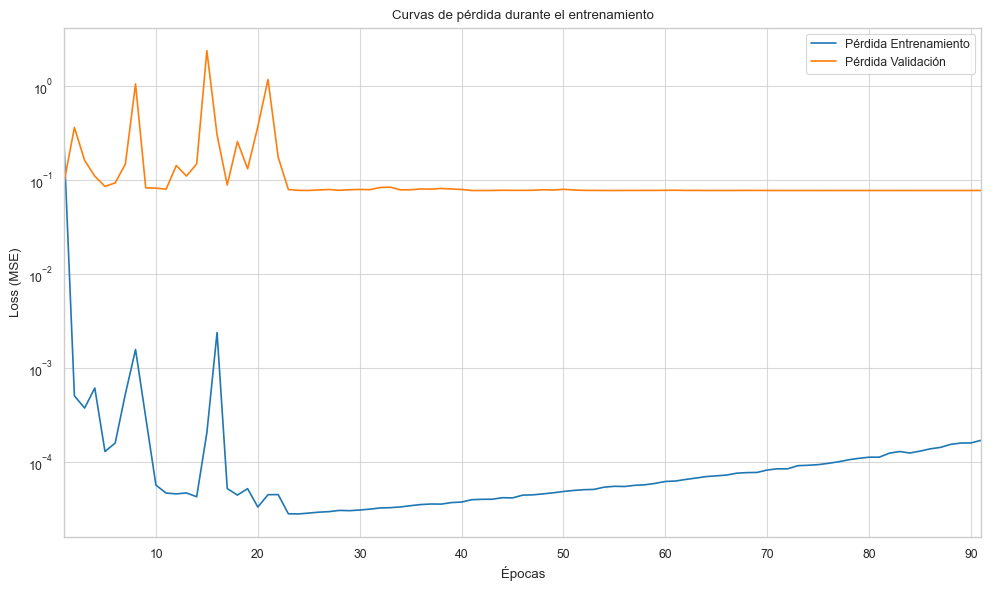

In [ ]:
plot_loss_curves(train_loss, val_loss, save_as_pdf=False, filename=f'loss_curves_{filename}')

### Testing

Carga el mejor modelo entrenado y evalúa su rendimiento en el conjunto de test mediante una función `rollout` autoregresiva.

- La función `rollout` genera toda la secuencia de salida autoregresiva usando como entrada las condiciones de contorno (`bc_seq`) y la temperatura inicial (`T0`).
- Se evalúa la pérdida total del modelo sobre todas las muestras y también se calcula la pérdida por paso de tiempo.

Incluye impresión opcional de errores en pasos específicos para analizar cómo evoluciona el error en el tiempo.


In [ ]:
# --- 1. Carga del mejor modelo ---
model = PCB_ConvLSTM(input_channels=6,
                     hidden_dims=hidden_dims,
                     kernel_size=kernel_size,
                     height=13,
                     width=13).to(device)
model.load_state_dict(torch.load(model_path, map_location=device))
model.eval()

# --- 2. Función de rollout autoregresivo puro ---
@torch.no_grad()
def rollout(model, bc_seq, T0):
    """
    Predicción autoregresiva completa.

    Args:
        model   : modelo PyTorch
        bc_seq  : tensor (B, T, 5, H, W) con canales de contorno ya en device
        T0      : tensor (B, 1, H, W) condición inicial ya en device

    Returns:
        preds   : tensor (B, T, 1, H, W) con predicciones autoregresivas
    """
    B, T, _, H, W = bc_seq.shape
    preds = []
    t_prev = T0
    hidden = None

    for t in range(T):
        x_t = torch.cat([bc_seq[:, t], t_prev], dim=1).unsqueeze(1)  # (B,1,6,H,W)
        pred_seq, hidden = model(x_t, hidden)
        t_prev = pred_seq[:, 0]
        preds.append(t_prev)

    return torch.stack(preds, dim=1)

# --- Test completo ---
test_losses = []
step_losses = torch.zeros(sequence_length, device=device)

model.eval()
with torch.no_grad():
    for x_batch, y_batch in tqdm(test_loader, desc="Testing"):
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)

        bc_seq = x_batch[:, :, :5]
        T0 = x_batch[:, 0, 5:6]

        y_pred = rollout(model, bc_seq, T0)

        loss = criterion(y_pred, y_batch)
        test_losses.append(loss.item())

        for t in range(y_pred.shape[1]):
            step_losses[t] += criterion(y_pred[:, t], y_batch[:, t]).item() * y_pred.size(0)

mean_test_loss = sum(test_losses) / len(test_losses)
step_losses = (step_losses / len(test_loader.dataset)).cpu().numpy()

print(f"▶︎ Test Loss (secuencia completa): {mean_test_loss:.6f}")

for t_idx in [0, y_pred.shape[1]-1]:
    print(f"  Paso {t_idx+1:2d} Loss: {step_losses[t_idx]:.6f}")

C:\Users\ismael.gallo\AppData\Local\Temp\ipykernel_19200\3399994624.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_loca

▶︎ Test Loss (secuencia completa): 0.087008
  Paso  1 Loss: 0.000016
  Paso 51 Loss: 0.170968


### Analyzing results

In [ ]:
# time_sim = 50
# sequence_length = time_sim + 1

Define una función `predict_from_conditions(...)` que genera una predicción completa de temperatura dada una condición inicial y parámetros físicos del sistema (como temperaturas de interfaces y potencia de calentadores).

- Usa el método `create_input_from_values` del dataset para construir la entrada a partir de arrays.
- Realiza el `rollout` paso a paso utilizando el método `forward_step` del modelo.
- Devuelve una secuencia completa desnormalizada en formato `np.ndarray`.

Esta función es clave para usar el modelo en modo inferencia realista, fuera del flujo de entrenamiento.


In [ ]:
# def predict_from_conditions(Q_heaters: np.ndarray,
#                             T_interfaces: np.ndarray,
#                             T_env: float,
#                             sequence_length: int = 1001,
#                             T_seq_initial: np.ndarray = None,
#                             model=None,
#                             dataset=None,
#                             device=None) -> np.ndarray:
#     """
#     Genera una predicción completa de long. sequence_length a partir de:
#       - Q_heaters:        (4,)             np.ndarray
#       - T_interfaces:     (4,)             np.ndarray
#       - T_env:            scalar           float
#       - T_seq_initial:    (13,13)          np.ndarray (el mapa inicial)
#       - sequence_length:  número de pasos a predecir
#       - model:            tu PCB_ConvLSTM cargado y en .eval()
#       - dataset:          instancia de PCBDataset_convlstm con create_input_from_values
#       - device:           opcional, torch.device

#     Devuelve:
#       np.ndarray de forma (sequence_length, 13, 13) con la serie desnormalizada.
#     """

#     model.eval()
#     if device is None:
#         device = next(model.parameters()).device

#     if T_seq_initial is None:
#         T_seq_initial = np.full((13, 13), 298.0)  # Mapa por defecto a 298 K

#     # 1) Primer input (1,1,6,13,13)
#     input0 = dataset.create_input_from_values(
#         Q_heaters, T_interfaces, T_env,
#         T_seq=np.expand_dims(T_seq_initial, 0),
#         sequence_length=sequence_length,
#         autorregress=True
#     ).to(device)

#     # 2) Prepara contornos y t_prev
#     # bc_static: (1, seq_len, 5, 13,13)
#     bc_static = input0[:, :1, :5, :, :].repeat(1, sequence_length, 1, 1, 1)
#     # t_prev: (1,1,1,13,13)
#     t_prev = input0[:, :1, 5:6, :, :]

#     # 3) Roll-out autoregresivo
#     preds_norm = []
#     hidden = None
#     with torch.no_grad():
#         for t in range(sequence_length):
#             # concatenar por canal (dim=2)
#             x_t = torch.cat([bc_static[:, t:t+1], t_prev], dim=2)  # → (1,1,6,13,13)
#             pred_t, hidden = model.forward_step(x_t, hidden)       # → (1,1,1,13,13)
#             t_prev = pred_t                                        # mantener shape
#             preds_norm.append(t_prev)

#     preds_norm = torch.cat(preds_norm, dim=1)  # (1, T, 1, 13,13)

#     # 4) Desnormalizar y to numpy
#     mean = dataset.T_outputs_mean.to(device)
#     std  = dataset.T_outputs_std.to(device)
#     preds_denorm = preds_norm * std + mean      # (1, T, 1, H, W)
#     preds_denorm = preds_denorm.squeeze(0).squeeze(1)  # (T, 13,13)
#     return preds_denorm.cpu().numpy()

Carga de nuevo el modelo desde el disco y lo pone en modo evaluación (`eval()`), para realizar predicciones sin modificar sus parámetros.

Esto es útil para preparar el modelo antes de realizar inferencias como las de la función anterior.


In [ ]:
model = PCB_ConvLSTM(input_channels=6,
                     hidden_dims=hidden_dims,
                     kernel_size=kernel_size,
                     height=13,
                     width=13).to(device)
model.load_state_dict(torch.load(model_path, map_location=device))
model.eval()

C:\Users\ismael.gallo\AppData\Local\Temp\ipykernel_19200\2658188333.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_loca

PCB_ConvLSTM(
  (convlstm): ConvLSTM(
    (cell_list): ModuleList(
      (0): ConvLSTMCell(
        (conv): Conv2d(134, 512, kernel_size=(1, 1), stride=(1, 1))
      )
      (1-2): 2 x ConvLSTMCell(
        (conv): Conv2d(256, 512, kernel_size=(1, 1), stride=(1, 1))
      )
    )
  )
  (decoder): Conv2d(128, 1, kernel_size=(1, 1), stride=(1, 1))
)

Define las posiciones de los nodos que se quieran estudiar, en el caso por defecto los heaters (`id_heaters`), como tuplas de coordenadas dentro de la malla 13x13.

In [ ]:
id_heaters = [(6,3), (3,6), (9,3), (9,9)]

Define las condiciones físicas para el caso de prueba:

- `Q_heaters`: potencia aplicada por cada calentador.
- `T_interfaces`: temperaturas fijas en las interfaces térmicas.
- `T_env`: temperatura ambiente.
- `T_initial_map`: mapa de temperatura inicial uniforme, basado en `T_init`.

Estas variables se usarán como entrada en la simulación o para el modelo entrenado.


In [ ]:
Q_heaters = np.array([1.0, 1.0, 1.0, 1.0])
T_interfaces = np.array([290, 290, 290, 290])
T_env = 280
T_initial_map = np.full((13, 13), T_init)

Ejecuta el caso de simulación real `PCB_case_2` con los parámetros definidos (en modo transitorio) para obtener la solución de referencia.

- `T`: contiene toda la evolución temporal.
- Se reestructura la salida en forma de malla `(T, 13, 13)`.
- Se convierte a `tensor` y se sube al dispositivo (`cpu` o `cuda`) para usarla en comparación o inferencia.

Esto proporciona la verdad de terreno contra la cual se comparará la predicción del modelo.


In [ ]:
T, _, _, _ = PCB_case_2(solver = 'transient', display=False, time = time_sim, dt = 1, T_init = T_init, Q_heaters = Q_heaters, T_interfaces = T_interfaces, Tenv = T_env) # heaters in default position
T_true = T.reshape(T.shape[0], nodes_side, nodes_side) # reshaping the data grid-shape
T_true = downsample_solver_output(T_true, dt)  # downsample to match ConvLSTM input shape
T_true_tensor = torch.tensor(T_true, dtype=torch.float32).to(device)  # (T, H, W)

Llama a la función `predict_from_conditions(...)` usando las condiciones definidas (`Q_heaters`, `T_interfaces`, `T_env`, `T_initial_map`) y genera la predicción de temperatura a lo largo del tiempo.

- Devuelve un array `(T, 13, 13)` con la evolución térmica.
- Se convierte a tensor y se envía al dispositivo para facilitar cálculos posteriores.

Este bloque representa el uso final del modelo entrenado para hacer una predicción completa.


In [ ]:
T_pred = predict_from_conditions(
    Q_heaters=Q_heaters,
    T_interfaces=T_interfaces,
    T_env=T_env,
    sequence_length=sequence_length,
    model=model,
    dataset=dataset,  # Usar el dataset de entrenamiento para crear inputs
    device=device
)
T_pred_tensor = torch.tensor(T_pred, dtype=torch.float32).to(device)  # (T, H, W)

print(T_pred.shape)  # (T, 13, 13)

(51, 13, 13)


Dibuja la evolución térmica en nodos seleccionados a lo largo del tiempo, comparando la **predicción del modelo (`T_pred`)** con la **solución de referencia (`T_true`)**.

El parámetro `together=True` indica que ambas curvas se mostrarán en la misma figura para facilitar la comparación.

Este paso permite evaluar visualmente la precisión del modelo.


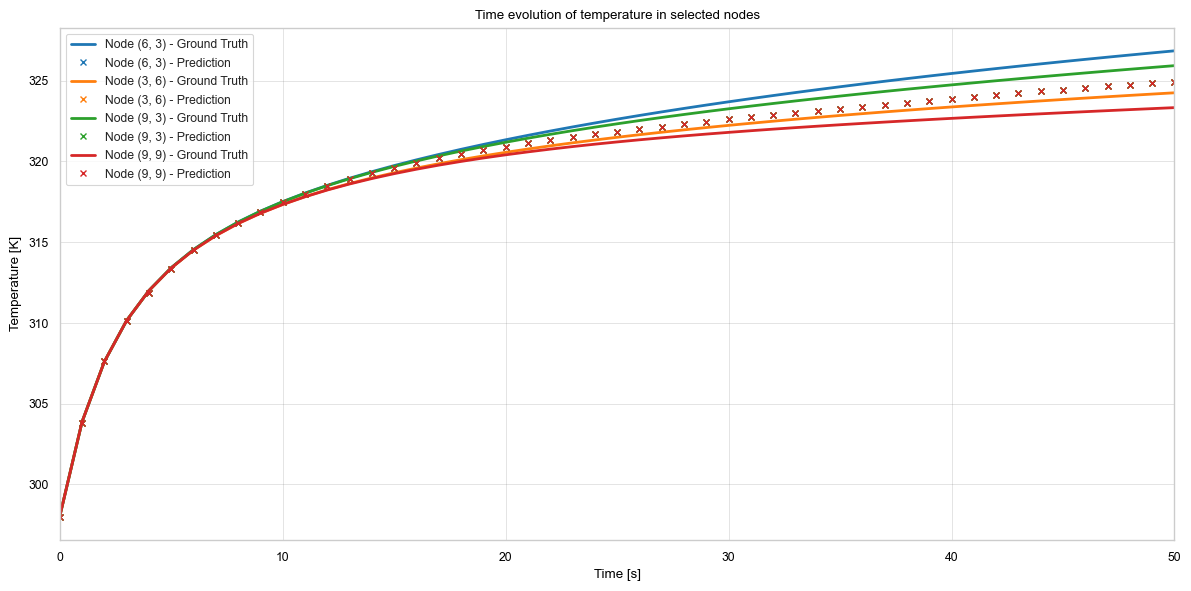

In [ ]:
plot_nodes_evolution(T_pred, T_true, id_heaters, dt = dt, together=True, save_as_pdf=True, filename=f'nodes_evolution_{filename}')

Evalúa la precisión del modelo usando métricas basadas en un **umbral de error absoluto** (en Kelvin):

- `porcentaje_error_bajo_umbral`: calcula el porcentaje de valores predichos cuyo error es menor que el umbral especificado.
- `nodos_siempre_dentro_umbral`: determina el porcentaje de nodos que están por debajo del umbral en **todos los pasos de tiempo**.

Estas métricas permiten cuantificar de forma robusta la calidad de la predicción.


In [ ]:
umbral = 5

acierto = porcentaje_error_bajo_umbral(T_true, T_pred, umbral=umbral)
print(f"Porcentaje de predicciones con error < {umbral:.1f} K: {acierto:.2f}%")

porcentaje, _, _ = nodos_siempre_dentro_umbral(T_true, T_pred, umbral=umbral)
print(f"Porcentaje de nodos buenos: {porcentaje:.2f}%")

Porcentaje de predicciones con error < 5.0 K: 85.89%
Porcentaje de nodos buenos: 71.01%


Calcula y visualiza una **curva de precisión acumulada** en función del umbral de error:

- Evalúa qué porcentaje de nodos cumplen con el criterio de error para cada valor de umbral entre 0 y 25 K.
- Muestra una gráfica que permite analizar la sensibilidad del modelo al nivel de tolerancia de error.

Esta representación es útil para comparar distintos modelos o configuraciones.


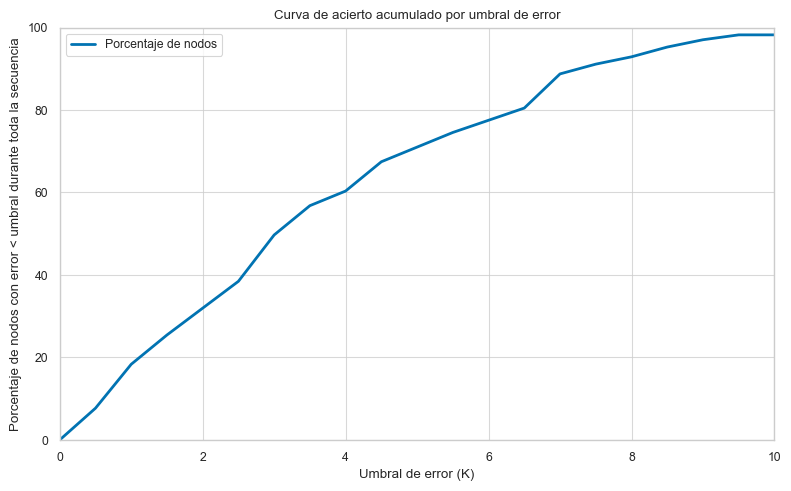

In [ ]:
umbrales = np.linspace(0, 10, 21)
porcentajes = porcentaje_nodos_siempre_dentro_por_umbral(T_true, T_pred, umbrales)

# Plot
plt.figure(figsize=(8, 5))
plt.plot(umbrales, porcentajes, label="Porcentaje de nodos", linewidth=2)
plt.xlabel("Umbral de error (K)")
plt.ylabel("Porcentaje de nodos con error < umbral durante toda la secuencia")
plt.title("Curva de acierto acumulado por umbral de error")
plt.grid(True)
plt.ylim(0, 100)
plt.xlim(0, umbrales[-1])
plt.legend()
plt.tight_layout()
plt.show()

Grafica el **error absoluto medio (MAE)** por fotograma (paso temporal), comparando la predicción del modelo y la solución de referencia.

Esto permite observar cómo evoluciona el error del modelo a lo largo de la secuencia y detectar posibles derivas o acumulaciones de error en el tiempo.


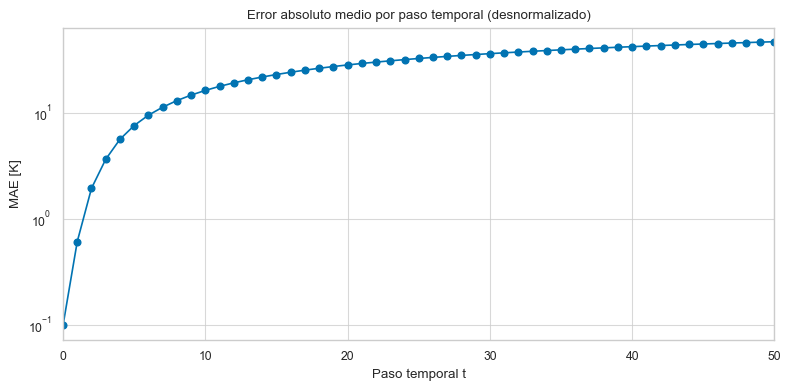

In [ ]:
plot_mae_per_frame(T_pred, T_true, dataset, dt, save_as_pdf=True, filename=f'mae_per_frame_{filename}')

Genera una figura con el **MAE por píxel** (nodo de la malla), calculado sobre toda la secuencia temporal.

Esto permite identificar qué zonas del PCB tienen mayor o menor error sistemático, y si existen patrones espaciales en el comportamiento del modelo.


c:\Users\ismael.gallo\Desktop\ia_thermal\plot_functions.py:985: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.85, 1])


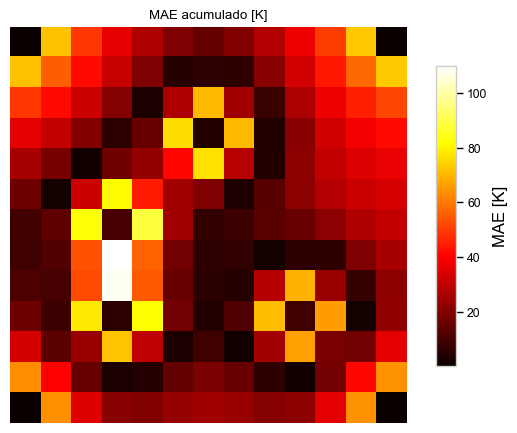

In [ ]:
plot_mae_per_pixel(T_pred, T_true, dataset, save_as_pdf=True, filename=f'mae_per_pixel_{filename}')

Crea una animación en forma de **GIF comparativo** entre la predicción (`T_pred`) y la solución real (`T_true`) a lo largo del tiempo.

- Guarda el GIF en la carpeta `figures`.
- Lo muestra directamente en el notebook usando HTML.

Esta animación es muy útil para validar visualmente el desempeño dinámico del modelo.


In [ ]:
ani = generar_gif_pcb_comparacion(T_pred, T_true, dt=dt, guardar_en_figures=True, nombre_archivo=f'comparacion_{filename}')

from IPython.display import HTML
HTML(ani.to_jshtml()) # Mostrar el GIF en Jupyter Notebook

Guardando gif en: c:\Users\ismael.gallo\Desktop\ia_thermal\ismaelgallo\figures\comparacion_PCB_ConvLSTM_6ch_nt1000_50s_dt1_bs8_h128-128-128_k1x1.pth.gif
Gif guardado.


Genera un **GIF que visualiza la evolución del error absoluto** entre la predicción y la realidad en cada paso temporal.

- Muestra cómo cambia el error con el tiempo.
- Útil para detectar acumulación de error, deriva o zonas problemáticas.

La animación se guarda y se muestra directamente en el notebook.


In [ ]:
ani = generar_gif_error_evolucion(T_pred, T_true, dt = dt, guardar_en_figures=True, nombre_archivo=f'error_{filename}')

from IPython.display import HTML
HTML(ani.to_jshtml()) # Mostrar el GIF en Jupyter Notebook

## Phisics informed ConvLSTM

### Dataset import

Define los hiperparámetros principales del experimento:

- Número de muestras para entrenamiento, validación y test.
- Duración de la simulación en segundos (`time_sim`) y su resolución temporal (`dt`).
- Tamaño del batch (`batch_size`), temperatura inicial (no cambiar el valor por defecto) y número de nodos por lado del PCB.
- La longitud de la secuencia temporal de salida se define como `time_sim + 1`.

Este bloque establece los parámetros que controlan cómo se estructuran los datos y la simulación.

In [ ]:
# # ⚙️ Parámetros del conjunto de datos
# n_train = 10    # Número de muestras para entrenamiento
# n_val = 200       # Número de muestras para validación
# n_test = 20       # Número de muestras para test

# # ⏱️ Parámetros temporales
# time_sim = 10    # Duración total de la simulación (s)
# dt = 1            # Paso de tiempo (s)
# sequence_length = time_sim + 1  # Longitud de la secuencia temporal (incluye t=0)

# # 🔥 Condiciones físicas
# T_init = 298.0    # Temperatura inicial (K)
# nodes_side = 13   # Número de nodos por lado en la malla del PCB (13x13)

# # 📦 Batch
# batch_size = 128  # Tamaño del batch

Carga los datasets de entrenamiento, validación y test desde disco usando funciones personalizadas (`load_dataset_convlstm` y `load_trimmed_dataset_convlstm`), que también preparan los datos para ser usados por PyTorch.

Después, crea los `DataLoader` para cada conjunto de datos:

- `train_loader`: con `shuffle=True` para entrenamiento.
- `val_loader` y `test_loader`: sin barajar, para validación y prueba.

Estos objetos permiten iterar sobre los datos por batches durante el entrenamiento y evaluación.


In [ ]:
dataset_phy = load_dataset_convlstm(base_path=BASE_PATH, physic=True, dt = dt)

dataset_train_phy = load_trimmed_dataset_convlstm(base_path=BASE_PATH, dataset_type='train', max_samples=n_train, time_steps_output=sequence_length, to_device=True, physic=True, dt = dt)
dataset_val_phy = load_trimmed_dataset_convlstm(base_path=BASE_PATH, dataset_type='val', max_samples=n_val, time_steps_output=sequence_length, to_device=True, physic=True, dt = dt)
dataset_test_phy = load_trimmed_dataset_convlstm(base_path=BASE_PATH, dataset_type='test', max_samples=n_test, time_steps_output=sequence_length, to_device=True, physic=True, dt = dt)

train_loader_phy = DataLoader(dataset_train_phy, batch_size=batch_size, shuffle=True)
val_loader_phy = DataLoader(dataset_val_phy, batch_size=batch_size, shuffle=False)
test_loader_phy = DataLoader(dataset_test_phy, batch_size=batch_size, shuffle=False)

c:\Users\ismael.gallo\Desktop\ia_thermal\ismaelgallo\Dataset_Class_convlstm.py:42: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(full_path)


✅ Cargando dataset train desde: c:\Users\ismael.gallo\Desktop\ia_thermal\ismaelgallo\datasets\PCB_convlstm_dt1_phy_6ch_dataset_train.pth


c:\Users\ismael.gallo\Desktop\ia_thermal\ismaelgallo\Dataset_Class_convlstm.py:408: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  base_dataset = torch.load(full_path)


📦 Dataset movido a: CUDA
✅ Cargando dataset val desde: c:\Users\ismael.gallo\Desktop\ia_thermal\ismaelgallo\datasets\PCB_convlstm_dt1_phy_6ch_dataset_val.pth
📦 Dataset movido a: CUDA
✅ Cargando dataset test desde: c:\Users\ismael.gallo\Desktop\ia_thermal\ismaelgallo\datasets\PCB_convlstm_dt1_phy_6ch_dataset_test.pth
📦 Dataset movido a: CUDA


In [ ]:
# # from torch.utils.data import DataLoader

# # # Ruta a la carpeta de datasets
# # DATASETS_PATH = BASE_PATH / "datasets"

# # Carga los datasets completos (sin recorte)
# dataset_phy_train = torch.load(DATASETS_PATH / 'PCB_convlstm_phy_6ch_transient_dataset_train.pth')
# dataset_phy_val   = torch.load(DATASETS_PATH / 'PCB_convlstm_phy_6ch_transient_dataset_val.pth')
# dataset_phy_test  = torch.load(DATASETS_PATH / 'PCB_convlstm_phy_6ch_transient_dataset_test.pth')

# # DataLoaders
# train_loader_phy = DataLoader(dataset_phy_train, batch_size=batch_size, shuffle=True)
# val_loader_phy   = DataLoader(dataset_phy_val, batch_size=batch_size, shuffle=False)
# test_loader_phy  = DataLoader(dataset_phy_test, batch_size=batch_size, shuffle=False)

Muestra las dimensiones del primer batch de entrada (`x_batch`) y de salida (`y_batch`) provenientes del `train_loader`.

Esto es útil para verificar que los datos han sido cargados correctamente y tienen las dimensiones esperadas.

Se detiene tras el primer batch usando `break`.


In [ ]:
for x1, x2, x3, x4, x5 in train_loader_phy:
    print("x1 shape:", x1.shape)
    print("x2 shape:", x2.shape)
    print("x3 shape:", x3.shape)
    print("x4 shape:", x4.shape)
    print("x5 shape:", x5.shape)
    break  # Solo muestra el primer batch

x1 shape: torch.Size([8, 51, 6, 13, 13])
x2 shape: torch.Size([8, 51, 1, 13, 13])
x3 shape: torch.Size([8, 4])
x4 shape: torch.Size([8, 4])
x5 shape: torch.Size([8, 1])


Extrae un batch del `train_loader`, selecciona la última imagen temporal del primer ejemplo y la muestra usando un mapa de calor (`imshow` con `cmap='hot'`).

Esto permite visualizar la distribución de temperatura final en el tiempo para ese ejemplo específico.

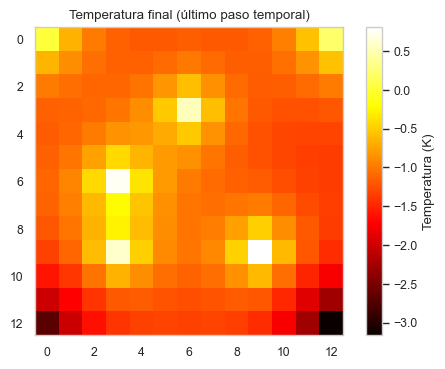

In [ ]:
# Obtener primer batch
x_batch, *_ = next(iter(train_loader_phy))

# Seleccionar el último mapa de temperatura del primer ejemplo
x_tfinal = x_batch[0, -1, -1]  # Shape: (C, H, W) -> (-1) para último paso temporal

# Mostrar el mapa térmico
plt.imshow(x_tfinal.cpu().numpy(), cmap='hot', interpolation='nearest')
plt.title("Temperatura final (último paso temporal)")
plt.colorbar(label="Temperatura (K)")
plt.grid(False)
plt.show()


### Loss function

Weight for the parameters in the loss funcion

**INCLUIR LA EXPRESIÓN DE LA FUNCIÓN DE PÉRDIDA**

In [ ]:
mse_weight = 1.0
physics_weight = 1e1
boundary_weight = 1e-1

Implementación de la función de pérdida para ver su eficiencia con los datos del solver

In [ ]:
# 1) Instancia las pérdidas
physics_loss_fn  = PhysicsLossTransient(dt=dt).to(device)
boundary_loss_fn = BoundaryLoss(nx=13, ny=13, device=device).to(device)

# 2) Toma un batch “ground-truth”
x_batch, y_batch_norm, Q_batch, Ti_batch, Tenv_batch = next(iter(train_loader_phy))
# Shapes:
#   x_batch:      (B, T, 6, 13, 13)
#   y_batch_norm: (B, T, 1, 13, 13)
#   Q_batch:      (B, 4)
#   Ti_batch:     (B, 4)
#   Tenv_batch:   (B, 1)

# 3) Desnormaliza y_batch para pasar a físicas
#    dataset_phy.denormalize_output espera (..., H, W)
y_denorm = dataset_phy.denormalize_output(
    y_batch_norm.squeeze(2)    # (B, T, 13, 13)
).unsqueeze(2).to(device)      # (B, T, 1, 13, 13)

# 4) Calcula las pérdidas
loss_phys = physics_loss_fn(
    y_denorm,                   # pred = true
    y_denorm,                   # true = true
    Q_batch.to(device),         # (B, 4)
    Ti_batch.to(device),        # (B, 4)
    Tenv_batch.to(device)       # (B, 1)
)

loss_bdry = boundary_loss_fn(
    y_denorm,                   # (B, T, 1, 13, 13)
    Ti_batch.to(device)         # (B, 4)
)

# 5) Prueba TotalLoss sobre ground-truth
total_loss_fn = TotalLoss(
    mse_weight=mse_weight,
    physics_weight=physics_weight,
    boundary_weight=boundary_weight,
    denormalize_output_fn=dataset_phy.denormalize_output
).to(device)

total_loss, mse_loss, phys_loss, bdry_loss = total_loss_fn(
    y_batch_norm, y_batch_norm, Q_batch.to(device), Ti_batch.to(device), Tenv_batch.to(device)
)

print(f"TotalLoss on ground-truth batch: {total_loss.item():.3e}")
print(f"  MSE:      {mse_loss.item():.3e}")
print(f"  Physics:  {phys_loss.item():.3e}")
print(f"  Boundary: {bdry_loss.item():.3e}")

if total_loss.item() > 1e-6:
    print("¡TotalLoss no cero sobre ground-truth!")

# print(f"PhysicsLoss on ground-truth batch: {loss_phys.item():.3e}")
# print(f"BoundaryLoss on ground-truth batch: {loss_bdry.item():.3e}")

# Opcionalmente, assert para asegurar que sean ~0
if phys_loss.item() > 1e-6:
    print("¡Pérdida física no cero sobre ground-truth!")
if bdry_loss.item() > 1e-6:
    print("¡Pérdida de frontera no cero sobre ground-truth!")


TotalLoss on ground-truth batch: 2.537e-11
  MSE:      0.000e+00
  Physics:  2.537e-12
  Boundary: 0.000e+00


c:\Users\ismael.gallo\Desktop\ia_thermal\Physics_Loss.py:371: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):


### Hyperparameters

Define los hiperparámetros del entrenamiento:

- Número de épocas (`epochs`)
- Tasa de aprendizaje inicial (`lr`) y su factor de decaimiento (`lrdecay`)
- Paciencia para reducir el `lr` (`lrdecay_patience`) y para aplicar `early stopping` (`early_stop_patience`)
- Arquitectura del modelo: número de filtros por capa en `hidden_dims` y tamaño del kernel

Estos valores controlan el comportamiento del optimizador y la estructura de la red ConvLSTM.


In [ ]:
# # ⚙️ Hiperparámetros de entrenamiento
# epochs = 5
# lr = 1e-2
# lrdecay = 0.1
# lrdecay_patience = 10
# early_stop_patience = 50

# # 🧠 Arquitectura ConvLSTM
# hidden_dims = [64, 64]                     # Número de filtros por capa
# num_layers = len(hidden_dims)
# kernel_size = [(3,3)] * num_layers        # Kernel de cada capa (igual para todas)

### Model definition

Define la clase `PCB_ConvLSTM`, una red neuronal basada en ConvLSTM para predecir la evolución térmica en un PCB.

- Usa `ConvLSTM` como núcleo para modelar la secuencia temporal.
- Incluye una capa `Conv2d` de 1x1 al final para proyectar la salida oculta a un canal de temperatura.
- El método `forward` procesa secuencias completas (`seq_len > 1`), mientras que `forward_step` permite avanzar un paso en modo autoregresivo.

Esta arquitectura es adecuada para secuencias espacio-temporales de mapas térmicos.


In [ ]:
class PCB_ConvLSTM(nn.Module):
    def __init__(self, input_channels=6, hidden_dims=hidden_dims, kernel_size=kernel_size, height=13, width=13):
        super().__init__()
        self.height = height
        self.width = width
        self.num_layers = len(hidden_dims)

        self.convlstm = ConvLSTM(
            input_dim=input_channels,
            hidden_dim=hidden_dims,
            kernel_size=kernel_size,
            num_layers=self.num_layers,
            batch_first=True,
            bias=True,
            return_all_layers=False
        )
        self.decoder = nn.Conv2d(hidden_dims[-1], 1, kernel_size=1)

    def forward(self, x, hidden=None):
        """
        x      : (B, T, 6, H, W)
        hidden : lista de (h,c) por capa, o None
        returns: preds (B, T, 1, H, W), hidden
        """
        layer_output_list, hidden = self.convlstm(x, hidden)
        h_seq = layer_output_list[0]                # (B, T, hidden_dim, H, W)
        B, T, C_h, H, W = h_seq.shape

        h_flat = h_seq.contiguous().view(B*T, C_h, H, W)
        dec_flat = self.decoder(h_flat)
        preds = dec_flat.view(B, T, 1, H, W)
        return preds, hidden

    def forward_step(self, x_t, hidden=None):
        """
        Un paso de secuencia (seq_len=1).
        x_t    : (B, 1, 6, H, W)
        hidden : estado previo
        returns: pred (B, 1, 1, H, W), hidden
        """
        pred, hidden = self.forward(x_t, hidden)
        return pred, hidden

Instancia el modelo `PCB_ConvLSTM_phy` y lo envía al dispositivo adecuado (`cpu` o `cuda`).

Se define:

- `criterion`: función de pérdida MSE.
- `optimizer`: Adam con la tasa de aprendizaje definida previamente.
- `scheduler`: ReduceLROnPlateau para ajustar el `lr` si la pérdida se estanca.

In [ ]:
# Inicializar el modelo
model_phy = PCB_ConvLSTM(
    input_channels=6,
    hidden_dims=hidden_dims,
    kernel_size=kernel_size
).to(device)

# Definir los parámetros de física, incluyendo dt
physics_params = {'dt': dt}  # Aquí puedes definir el valor de 'dt' que desees

# Pérdida y optimizador
criterion_phy = TotalLoss(
    mse_weight=mse_weight,
    physics_weight=physics_weight,
    boundary_weight=boundary_weight,
    denormalize_output_fn=dataset_phy.denormalize_output,
    physics_params=physics_params  # Pasa los parámetros de física aquí
).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model_phy.parameters(), lr=lr)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=lrdecay, patience=lrdecay_patience)

num_params = sum(p.numel() for p in model_phy.parameters() if p.requires_grad)

# Mostrar información básica del modelo
print(f"Modelo en dispositivo: {device}")
print(f"Parámetros totales: {num_params}")

Modelo en dispositivo: cuda
Parámetros totales: 332417


### Optimización de pesos de la pérdida física (Optuna)

Generar casos para comparación

In [ ]:
np.random.seed(0)  # Para reproducibilidad

n_data = 1000          # Número de casos a analizar

print(f"   📊 Casos a analizar: {n_data}")
print(f"   ⏱️  Tiempo máximo: {time_sim}s")

Q_random, T_interfaces_random, T_env_random = generate_unique_cases(n_data)

# Preallocar array para almacenar resultados
# Asumiendo que T_transient tiene forma (time_steps, spatial_nodes)
spatial_nodes = 169  # 13x13 = 169 nodos para PCB

T_true_all = np.zeros((n_data, sequence_length, spatial_nodes))

for i in range(n_data):
    if i % 100 == 0:  # Progress indicator
        print(f"   📊 Procesando caso {i}/{n_data}...")
        
    # Condiciones para este caso
    Q = Q_random[i]
    T_int = T_interfaces_random[i]
    T_env = T_env_random[i]
    
    # =============== SOLVER TRANSITORIO (EVOLUCIÓN) ===============
    T_transient, _, _, _ = PCB_case_2(
        solver='transient', display=False, time=time_sim, dt=dt,
        T_init=T_init, Q_heaters=Q, T_interfaces=T_int, Tenv=T_env
    )
    
    # Almacenar resultado
    T_true_all[i] = T_transient

print(f"🎉 Análisis completado!")
print(f"📦 Array de temperaturas: {T_true_all.shape}")
print(f"   - {n_data} casos")
print(f"   - {sequence_length} pasos temporales")
print(f"   - {spatial_nodes} nodos espaciales")

   📊 Casos a analizar: 1000
   ⏱️  Tiempo máximo: 50s
   📊 Procesando caso 0/1000...


KeyboardInterrupt: 

In [ ]:
import optuna
import torch
import torch.nn as nn
import numpy as np
from datetime import datetime
import json
from pathlib import Path
import time
import matplotlib.pyplot as plt
import sqlite3
import pandas as pd
from optuna.storages import RDBStorage

def objective_physics_weights_with_db(trial, base_model_config, train_loader, val_loader, device, 
                                     T_true_all, Q_random, T_interfaces_random, T_env_random,
                                     n_epochs=50, patience=15, discrete_weights=None, models_dir=None):
    """
    Función objetivo para optimizar pesos de física con Optuna usando valores discretos y guardado de modelos
    """
    
    # Valores discretos por defecto si no se proporcionan
    if discrete_weights is None:
        discrete_weights = {
            'mse_weight': [0.5, 1.0, 1.5, 2.0, 3.0],
            'physics_weight': [0.0, 0.1, 0.5, 1.0, 1.5, 2.0],
            'boundary_weight': [0.0, 0.1, 0.5, 1.0, 1.5]
        }
    
    # Sugerir pesos de física usando valores discretos
    mse_weight = trial.suggest_categorical('mse_weight', discrete_weights['mse_weight'])
    physics_weight = trial.suggest_categorical('physics_weight', discrete_weights['physics_weight'])
    boundary_weight = trial.suggest_categorical('boundary_weight', discrete_weights['boundary_weight'])
    
    print(f"\n🧪 Trial {trial.number}: MSE={mse_weight:.1f}, Physics={physics_weight:.1f}, Boundary={boundary_weight:.1f}")
    
    try:
        # Crear modelo usando tu clase PCB_ConvLSTM
        model = PCB_ConvLSTM(
            input_channels=6,
            hidden_dims=base_model_config['hidden_dims'],
            kernel_size=base_model_config['kernel_size'],
            height=13,
            width=13
        ).to(device)
        
        # Configurar parámetros de física
        physics_params = {'dt': base_model_config['dt']}
        
        # Configurar función de pérdida con los pesos sugeridos por Optuna
        criterion = TotalLoss(
            mse_weight=mse_weight,
            physics_weight=physics_weight,
            boundary_weight=boundary_weight,
            denormalize_output_fn=dataset_phy.denormalize_output,
            physics_params=physics_params
        ).to(device)
        
        # Optimizador y scheduler
        optimizer = torch.optim.Adam(model.parameters(), lr=base_model_config['lr'])
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer, mode='min', factor=0.5, patience=8, verbose=False
        )
        
        # Paths para guardar modelo y configuración
        if models_dir:
            model_filename = f"trial_{trial.number}_physics_mse{mse_weight}_phy{physics_weight}_bnd{boundary_weight}.pth"
            json_filename = f"trial_{trial.number}_physics_mse{mse_weight}_phy{physics_weight}_bnd{boundary_weight}.json"
            trial_model_path = models_dir / model_filename
            trial_json_path = models_dir / json_filename
        else:
            trial_model_path = MODELS_PATH / f"trial_{trial.number}_temp_model.pth"
            trial_json_path = MODELS_PATH / f"trial_{trial.number}_temp_log.json"
        
        # Entrenar usando función optimizada para velocidad
        train_history, val_history, best_val_loss = train_model_fast_optuna(
            model=model,
            train_loader=train_loader,
            val_loader=val_loader,
            criterion=criterion,
            optimizer=optimizer,
            scheduler=scheduler,
            model_path=trial_model_path,
            json_path=trial_json_path,
            epochs=n_epochs,
            early_stop_patience=patience,
            device=device,
            mse_weight=mse_weight,
            physics_weight=physics_weight,
            boundary_weight=boundary_weight,
            trial=trial
        )
        
        # Cargar el mejor modelo para evaluación final
        model.load_state_dict(torch.load(trial_model_path, map_location=device))
        
        # Evaluación rápida en subconjunto de test
        model.eval()
        test_mse = evaluate_model_fast(
            model=model,
            dataset_phy=dataset_phy,
            T_true_all=T_true_all[:50],  # Solo primeras 50 muestras para velocidad
            Q_random=Q_random[:50],
            T_interfaces_random=T_interfaces_random[:50],
            T_env_random=T_env_random[:50],
            device=device,
            sequence_length=sequence_length
        )
        
        # Guardar información del trial
        trial.set_user_attr('test_mse', test_mse)
        trial.set_user_attr('best_val_loss', best_val_loss)
        trial.set_user_attr('epochs_trained', len(train_history['total']))
        trial.set_user_attr('weights_used', {
            'mse': mse_weight,
            'physics': physics_weight,
            'boundary': boundary_weight
        })
        trial.set_user_attr('model_path', str(trial_model_path))
        trial.set_user_attr('json_path', str(trial_json_path))
        
        # Guardar configuración detallada en JSON
        config_data = {
            'trial_number': trial.number,
            'weights': {
                'mse_weight': mse_weight,
                'physics_weight': physics_weight,
                'boundary_weight': boundary_weight
            },
            'model_config': base_model_config,
            'training_results': {
                'best_val_loss': best_val_loss,
                'test_mse': test_mse,
                'epochs_trained': len(train_history['total']),
                'training_history': train_history,
                'validation_history': val_history
            },
            'optimization_datetime': datetime.now().isoformat()
        }
        
        with open(trial_json_path, 'w') as f:
            json.dump(config_data, f, indent=2)
        
        # Solo limpiar archivos temporales si no son guardados permanentemente
        if not models_dir:
            if trial_model_path.exists():
                trial_model_path.unlink()
            if trial_json_path.exists():
                trial_json_path.unlink()
        
        print(f"   ✅ Val Loss: {best_val_loss:.4f}, Test MSE: {test_mse:.3f}")
        
        # Retornar MSE como métrica a minimizar
        return test_mse
        
    except optuna.TrialPruned:
        raise
    except Exception as e:
        print(f"   ❌ Error en trial: {e}")
        import traceback
        traceback.print_exc()
        return float('inf')

def run_physics_optuna_study_with_db(base_model_config, dataset_phy, device,
                                    T_true_all, Q_random, T_interfaces_random, T_env_random,
                                    discrete_weights=None, n_trials=25, n_epochs=20, patience=6):
    """
    Ejecuta estudio de Optuna con guardado en base de datos SQLite para optimización de pesos de física.
    """

    # 🆕 CAMBIAR PATH: Usar ConvLSTM_6ch en lugar de PCB_ConvLSTM_Physics
    optuna_dir = MODELS_PATH / "ConvLSTM_6ch" / "optuna_optimization"
    optuna_db_dir = optuna_dir / "databases"
    models_dir = optuna_dir / "models"
    
    optuna_db_dir.mkdir(parents=True, exist_ok=True)
    models_dir.mkdir(parents=True, exist_ok=True)

    # Configurar base de datos SQLite
    timestamp = time.strftime("%Y%m%d_%H%M%S")
    db_name = f"physics_weights_optimization_{timestamp}.db"
    db_path = optuna_db_dir / db_name

    # Crear storage con SQLite
    storage_url = f"sqlite:///{db_path}"
    storage = RDBStorage(url=storage_url)

    study_name = f"physics_weights_optimization_{timestamp}"

    print(f"📁 Base de datos se guardará en: {db_path}")
    print(f"💾 Modelos se guardarán en: {models_dir}")
    print(f"🏷️ Nombre del estudio: {study_name}")

    try:
        # Crear train y validation loaders rápidos
        train_loader, val_loader = create_fast_train_val_loaders(
            dataset_phy, batch_size=base_model_config['batch_size']
        )

        # Crear estudio con storage persistente
        study = optuna.create_study(
            direction='minimize',
            study_name=study_name,
            storage=storage,
            load_if_exists=True,
            sampler=optuna.samplers.GridSampler(discrete_weights) if discrete_weights else optuna.samplers.TPESampler(seed=42),
            pruner=optuna.pruners.MedianPruner(
                n_startup_trials=2,
                n_warmup_steps=5,
                interval_steps=3
            )
        )

        # Función objetivo
        objective_func = lambda trial: objective_physics_weights_with_db(
            trial=trial,
            base_model_config=base_model_config,
            train_loader=train_loader,
            val_loader=val_loader,
            device=device,
            T_true_all=T_true_all,
            Q_random=Q_random,
            T_interfaces_random=T_interfaces_random,
            T_env_random=T_env_random,
            n_epochs=n_epochs,
            patience=patience,
            discrete_weights=discrete_weights,
            models_dir=models_dir
        )

        print(f"🔬 Ejecutando {n_trials} trials con {n_epochs} épocas máx...")
        study.optimize(objective_func, n_trials=n_trials, show_progress_bar=True)

        # Guardar metadatos adicionales en la base de datos
        _save_physics_study_metadata(db_path, study, {
            'experiment_type': 'physics_weights_optimization',
            'model_type': 'PCB_ConvLSTM',
            'save_location': 'models/ConvLSTM_6ch/optuna_optimization',
            'dataset_info': {
                'dataset_type': 'dataset_phy',
                'train_samples': len(train_loader.dataset),
                'val_samples': len(val_loader.dataset),
                'sequence_length': sequence_length,
                'time_sim': base_model_config['time_sim'],
                'dt': base_model_config['dt']
            },
            'model_config': base_model_config,
            'optimization_config': {
                'n_trials': n_trials,
                'n_epochs': n_epochs,
                'patience': patience,
                'discrete_weights': discrete_weights,
                'pruner': 'MedianPruner'
            }
        })

        print(f"✅ Estudio completado y guardado en: {db_path}")
        return study, db_path, models_dir

    except Exception as e:
        print(f"❌ Error durante optimización: {e}")
        return None, None, None

def _save_physics_study_metadata(db_path, study, metadata):
    """
    Guarda metadatos específicos del estudio de pesos de física en la base de datos.
    """
    try:
        conn = sqlite3.connect(str(db_path))
        cursor = conn.cursor()

        # Crear tabla de metadatos si no existe
        cursor.execute('''
            CREATE TABLE IF NOT EXISTS study_metadata (
                id INTEGER PRIMARY KEY AUTOINCREMENT,
                study_name TEXT,
                metadata_key TEXT,
                metadata_value TEXT,
                created_at TIMESTAMP DEFAULT CURRENT_TIMESTAMP
            )
        ''')

        # Insertar metadatos
        for key, value in metadata.items():
            cursor.execute('''
                INSERT INTO study_metadata (study_name, metadata_key, metadata_value)
                VALUES (?, ?, ?)
            ''', (study.study_name, key, json.dumps(value)))

        # Insertar información del mejor trial
        if study.best_trial:
            best_trial_info = {
                'best_mse': study.best_trial.value,
                'best_weights': study.best_trial.params,
                'best_trial_number': study.best_trial.number,
                'n_completed_trials': len([t for t in study.trials if t.state == optuna.trial.TrialState.COMPLETE])
            }
            cursor.execute('''
                INSERT INTO study_metadata (study_name, metadata_key, metadata_value)
                VALUES (?, ?, ?)
            ''', (study.study_name, 'best_trial_summary', json.dumps(best_trial_info)))

        conn.commit()
        conn.close()
        print(f"💾 Metadatos de física guardados en la base de datos")

    except Exception as e:
        print(f"⚠️ Error guardando metadatos: {e}")

def analyze_physics_optuna_database(db_path):
    """
    Analiza la base de datos de Optuna para optimización de pesos de física.
    """
    if not Path(db_path).exists():
        print(f"❌ Base de datos no encontrada: {db_path}")
        return

    print(f"📊 ANÁLISIS DE BASE DE DATOS OPTUNA - PESOS DE FÍSICA")
    print("="*60)
    print(f"📁 Archivo: {Path(db_path).name}")

    try:
        conn = sqlite3.connect(str(db_path))

        # Información de estudios
        studies_df = pd.read_sql_query("SELECT * FROM studies", conn)
        print(f"\n🔬 ESTUDIOS EN LA BASE DE DATOS:")
        for _, study in studies_df.iterrows():
            print(f"   📋 {study['study_name']} (ID: {study['study_id']})")
            print(f"      Dirección: {study['direction']}")

        # Información de trials
        trials_df = pd.read_sql_query("""
            SELECT trial_id, number, state, value, datetime_start, datetime_complete
            FROM trials ORDER BY number
        """, conn)

        completed_trials = trials_df[trials_df['state'] == 'COMPLETE']
        print(f"\n📈 TRIALS:")
        print(f"   Total: {len(trials_df)}")
        print(f"   Completados: {len(completed_trials)}")
        print(f"   Podados: {len(trials_df[trials_df['state'] == 'PRUNED'])}")
        print(f"   Fallidos: {len(trials_df[trials_df['state'] == 'FAIL'])}")

        if len(completed_trials) > 0:
            print(f"\n🏆 MEJORES RESULTADOS:")
            best_trials = completed_trials.nsmallest(5, 'value')
            for _, trial in best_trials.iterrows():
                print(f"   Trial #{trial['number']}: MSE = {trial['value']:.6f}")

        # Análisis específico de pesos de física
        params_df = pd.read_sql_query("""
            SELECT tp.trial_id, tp.param_name, tp.param_value, t.value as trial_value
            FROM trial_params tp
            JOIN trials t ON tp.trial_id = t.trial_id
            WHERE t.state = 'COMPLETE'
        """, conn)
        
        if len(params_df) > 0:
            print(f"\n⚙️ ANÁLISIS DE PESOS DE FÍSICA:")
            
            # Análisis por tipo de peso
            for weight_type in ['mse_weight', 'physics_weight', 'boundary_weight']:
                weight_data = params_df[params_df['param_name'] == weight_type]
                if len(weight_data) > 0:
                    print(f"\n   📊 {weight_type.upper()}:")
                    weight_performance = weight_data.groupby('param_value')['trial_value'].agg(['mean', 'min', 'count'])
                    for weight_val, (mean_mse, min_mse, count) in weight_performance.iterrows():
                        print(f"     {weight_val}: Promedio={mean_mse:.6f}, Mejor={min_mse:.6f} ({count} trials)")

        conn.close()

        return {
            'db_path': db_path,
            'studies': studies_df,
            'trials': trials_df,
            'params': params_df,
            'n_completed': len(completed_trials)
        }

    except Exception as e:
        print(f"❌ Error analizando base de datos: {e}")
        return None

def create_physics_optimization_plots_from_db(db_path, save_plots=True):
    """
    Crea gráficos específicos para análisis de optimización de pesos de física.
    """
    if not Path(db_path).exists():
        print(f"❌ Base de datos no encontrada: {db_path}")
        return

    try:
        conn = sqlite3.connect(str(db_path))

        # Cargar datos de trials con pesos
        trials_df = pd.read_sql_query("""
            SELECT t.trial_id, t.number, t.state, t.value,
                   p1.param_value as mse_weight,
                   p2.param_value as physics_weight,
                   p3.param_value as boundary_weight
            FROM trials t
            LEFT JOIN trial_params p1 ON t.trial_id = p1.trial_id AND p1.param_name = 'mse_weight'
            LEFT JOIN trial_params p2 ON t.trial_id = p2.trial_id AND p2.param_name = 'physics_weight'
            LEFT JOIN trial_params p3 ON t.trial_id = p3.trial_id AND p3.param_name = 'boundary_weight'
            WHERE t.state = 'COMPLETE'
            ORDER BY t.number
        """, conn)

        if len(trials_df) == 0:
            print("❌ No hay trials completados para analizar")
            conn.close()
            return

        # Convertir a float
        for col in ['mse_weight', 'physics_weight', 'boundary_weight']:
            trials_df[col] = pd.to_numeric(trials_df[col], errors='coerce')

        # Crear figura con subplots
        fig, axes = plt.subplots(2, 3, figsize=(18, 10))
        fig.suptitle('Análisis de Optimización de Pesos de Física', fontsize=16)

        # 1. Evolución de la función objetivo
        axes[0,0].plot(trials_df['number'], trials_df['value'], 'b-', alpha=0.7)
        axes[0,0].plot(trials_df['number'], trials_df['value'].cummin(), 'r-', linewidth=2, label='Mejor hasta ahora')
        axes[0,0].set_xlabel('Trial')
        axes[0,0].set_ylabel('Test MSE')
        axes[0,0].set_title('Evolución de MSE')
        axes[0,0].legend()
        axes[0,0].grid(True, alpha=0.3)

        # 2. MSE vs MSE Weight
        axes[0,1].scatter(trials_df['mse_weight'], trials_df['value'], alpha=0.7, c='blue')
        axes[0,1].set_xlabel('MSE Weight')
        axes[0,1].set_ylabel('Test MSE')
        axes[0,1].set_title('MSE vs MSE Weight')
        axes[0,1].grid(True, alpha=0.3)

        # 3. MSE vs Physics Weight
        axes[0,2].scatter(trials_df['physics_weight'], trials_df['value'], alpha=0.7, c='green')
        axes[0,2].set_xlabel('Physics Weight')
        axes[0,2].set_ylabel('Test MSE')
        axes[0,2].set_title('MSE vs Physics Weight')
        axes[0,2].grid(True, alpha=0.3)

        # 4. MSE vs Boundary Weight
        axes[1,0].scatter(trials_df['boundary_weight'], trials_df['value'], alpha=0.7, c='orange')
        axes[1,0].set_xlabel('Boundary Weight')
        axes[1,0].set_ylabel('Test MSE')
        axes[1,0].set_title('MSE vs Boundary Weight')
        axes[1,0].grid(True, alpha=0.3)

        # 5. Boxplot de MSE por Physics Weight
        physics_weights = sorted(trials_df['physics_weight'].dropna().unique())
        physics_data = []
        physics_labels = []
        for pw in physics_weights:
            subset = trials_df[trials_df['physics_weight'] == pw]['value']
            if len(subset) > 0:
                physics_data.append(subset)
                physics_labels.append(f'{pw}')

        if physics_data:
            axes[1,1].boxplot(physics_data, labels=physics_labels)
            axes[1,1].set_xlabel('Physics Weight')
            axes[1,1].set_ylabel('Test MSE')
            axes[1,1].set_title('Distribución por Physics Weight')
            axes[1,1].grid(True, alpha=0.3)

        # 6. Heatmap de correlaciones entre pesos
        weight_cols = ['mse_weight', 'physics_weight', 'boundary_weight', 'value']
        corr_data = trials_df[weight_cols].corr()
        
        im = axes[1,2].imshow(corr_data, cmap='coolwarm', vmin=-1, vmax=1)
        axes[1,2].set_xticks(range(len(weight_cols)))
        axes[1,2].set_yticks(range(len(weight_cols)))
        axes[1,2].set_xticklabels(weight_cols, rotation=45)
        axes[1,2].set_yticklabels(weight_cols)
        axes[1,2].set_title('Correlación entre Pesos')
        
        # Añadir valores de correlación
        for i in range(len(weight_cols)):
            for j in range(len(weight_cols)):
                text = axes[1,2].text(j, i, f'{corr_data.iloc[i, j]:.2f}',
                                    ha="center", va="center", color="black")

        plt.tight_layout()

        if save_plots:
            plots_dir = Path(db_path).parent / "analysis_plots"
            plots_dir.mkdir(exist_ok=True)
            plot_path = plots_dir / f"physics_optimization_analysis_{Path(db_path).stem}.pdf"
            plt.savefig(plot_path, format='pdf', bbox_inches='tight')
            print(f"📊 Gráficos guardados en: {plot_path}")

        plt.show()
        conn.close()

    except Exception as e:
        print(f"❌ Error creando gráficos: {e}")

def analyze_physics_results_with_models(study, models_dir):
    """
    Analiza resultados específicos de optimización de pesos de física con información de modelos.
    """
    if study is None or len(study.trials) == 0:
        print("❌ No hay trials para analizar")
        return

    print(f"\n📊 ANÁLISIS DE RESULTADOS - OPTIMIZACIÓN DE PESOS DE FÍSICA")
    print("="*60)

    # Estadísticas generales
    completed_trials = [t for t in study.trials if t.state == optuna.trial.TrialState.COMPLETE]
    pruned_trials = [t for t in study.trials if t.state == optuna.trial.TrialState.PRUNED]
    failed_trials = [t for t in study.trials if t.state == optuna.trial.TrialState.FAIL]

    print(f"📈 Trials completados: {len(completed_trials)}")
    print(f"✂️ Trials podados: {len(pruned_trials)}")
    print(f"❌ Trials fallidos: {len(failed_trials)}")

    if len(completed_trials) == 0:
        print("⚠️ No hay trials completados para analizar")
        return

    # Mejor trial
    best_trial = study.best_trial
    print(f"\n🏆 MEJORES PESOS DE FÍSICA:")
    print(f"   Trial #{best_trial.number}")
    print(f"   Test MSE: {best_trial.value:.6f}")
    print(f"   Pesos:")
    print(f"     MSE Weight: {best_trial.params.get('mse_weight', 'N/A')}")
    print(f"     Physics Weight: {best_trial.params.get('physics_weight', 'N/A')}")
    print(f"     Boundary Weight: {best_trial.params.get('boundary_weight', 'N/A')}")

    # Top 5 configuraciones
    print(f"\n🥇 TOP 5 CONFIGURACIONES DE PESOS:")
    sorted_trials = sorted(completed_trials, key=lambda t: t.value)
    for i, trial in enumerate(sorted_trials[:5]):
        print(f"   #{i+1}: Trial {trial.number} - MSE: {trial.value:.6f}")
        print(f"        MSE_w: {trial.params.get('mse_weight', 'N/A')}, "
              f"Phy_w: {trial.params.get('physics_weight', 'N/A')}, "
              f"Bnd_w: {trial.params.get('boundary_weight', 'N/A')}")

    # Análisis de rendimiento por pesos
    print(f"\n⚙️ ANÁLISIS DE RENDIMIENTO POR PESOS:")

    # Por MSE weight
    mse_performance = {}
    for trial in completed_trials:
        mse_w = trial.params.get('mse_weight')
        if mse_w is not None:
            if mse_w not in mse_performance:
                mse_performance[mse_w] = []
            mse_performance[mse_w].append(trial.value)

    if mse_performance:
        print(f"   📊 Rendimiento por MSE Weight:")
        for mse_w in sorted(mse_performance.keys()):
            losses = mse_performance[mse_w]
            avg_loss = np.mean(losses)
            min_loss = np.min(losses)
            print(f"     {mse_w}: Promedio={avg_loss:.6f}, Mejor={min_loss:.6f} ({len(losses)} trials)")

    # Por Physics weight
    physics_performance = {}
    for trial in completed_trials:
        phy_w = trial.params.get('physics_weight')
        if phy_w is not None:
            if phy_w not in physics_performance:
                physics_performance[phy_w] = []
            physics_performance[phy_w].append(trial.value)

    if physics_performance:
        print(f"   🔧 Rendimiento por Physics Weight:")
        for phy_w in sorted(physics_performance.keys()):
            losses = physics_performance[phy_w]
            avg_loss = np.mean(losses)
            min_loss = np.min(losses)
            print(f"     {phy_w}: Promedio={avg_loss:.6f}, Mejor={min_loss:.6f} ({len(losses)} trials)")

    # Información de modelos guardados
    if models_dir and models_dir.exists():
        model_files = list(models_dir.glob("*.pth"))
        config_files = list(models_dir.glob("*.json"))
        print(f"\n💾 ARCHIVOS GUARDADOS EN models/ConvLSTM_6ch/optuna_optimization:")
        print(f"   📁 Directorio: {models_dir}")
        print(f"   🤖 Modelos: {len(model_files)} archivos .pth")
        print(f"   📄 Configuraciones: {len(config_files)} archivos .json")
        print(f"   🏆 Mejor modelo: trial_{best_trial.number}_physics_*.pth")

def optimize_physics_weights_with_models_and_db(n_trials=25, n_epochs=20, patience=6, discrete_weights=None):
    """
    Función principal para optimizar pesos de física con guardado de modelos y base de datos.
    UBICACIÓN: models/ConvLSTM_6ch/optuna_optimization
    
    Args:
        n_trials (int): Número de trials a ejecutar
        n_epochs (int): Número máximo de épocas por trial
        patience (int): Paciencia para early stopping
        discrete_weights (dict): Valores discretos para los pesos
    """
    
    # Valores discretos por defecto
    if discrete_weights is None:
        discrete_weights = {
            'mse_weight': [0.0, 1.0],
            'physics_weight': [0.0, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1.0],
            'boundary_weight': [0.0, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1.0]
        }

    print(f"🎯 OPTIMIZACIÓN DE PESOS DE FÍSICA CON MODELOS Y BASE DE DATOS")
    print("="*70)
    print(f"📁 UBICACIÓN: models/ConvLSTM_6ch/optuna_optimization")
    print(f"🔬 Trials a ejecutar: {n_trials}")
    print(f"⏰ Épocas máximas por trial: {n_epochs}")
    print(f"⏱️ Paciencia early stopping: {patience}")
    print(f"⚡ Dispositivo: {device}")
    print(f"🎯 Enfoque: PCB_ConvLSTM con física")
    print(f"📊 Valores discretos:")
    for weight_type, values in discrete_weights.items():
        print(f"   {weight_type}: {values}")

    # Configuración base del modelo
    base_model_config = {
        'hidden_dims': hidden_dims,
        'kernel_size': kernel_size,
        'lr': lr,
        'batch_size': batch_size,
        'dt': dt,
        'n_train': n_train,
        'time_sim': time_sim
    }

    # Verificar dataset_phy
    if 'dataset_phy' not in globals():
        print("❌ Error: dataset_phy no está definido.")
        return None, None, None, None, None

    # Ejecutar estudio con base de datos
    study, db_path, models_dir = run_physics_optuna_study_with_db(
        base_model_config=base_model_config,
        dataset_phy=dataset_phy,
        device=device,
        T_true_all=T_true_all,
        Q_random=Q_random,
        T_interfaces_random=T_interfaces_random,
        T_env_random=T_env_random,
        discrete_weights=discrete_weights,
        n_trials=n_trials,
        n_epochs=n_epochs,
        patience=patience
    )

    if study is None:
        print("❌ No se pudo ejecutar el estudio")
        return None, None, None, None, None

    # Analizar base de datos
    db_analysis = analyze_physics_optuna_database(db_path)

    # Crear script del dashboard
    dashboard_script = create_optuna_dashboard_script(db_path)

    # Crear gráficos de análisis
    create_physics_optimization_plots_from_db(db_path, save_plots=True)

    # Analizar resultados con información de modelos
    analyze_physics_results_with_models(study, models_dir)

    # Extraer mejores pesos
    best_weights = study.best_params if study.best_trial else None
    best_model_path = None
    best_json_path = None

    if study.best_trial and 'model_path' in study.best_trial.user_attrs:
        best_model_path = Path(study.best_trial.user_attrs['model_path'])
        best_json_path = Path(study.best_trial.user_attrs['json_path'])

    print(f"\n🎉 ¡OPTIMIZACIÓN COMPLETADA!")
    print(f"📁 Ubicación: models/ConvLSTM_6ch/optuna_optimization")
    print(f"⏰ Configuración temporal: {n_epochs} épocas máx, {patience} paciencia")
    print(f"💾 Mejor modelo: {best_model_path}")
    print(f"📄 Configuración: {best_json_path}")
    print(f"🗄️ Base de datos: {db_path}")
    print(f"📊 Dashboard script: {dashboard_script}")

    # Configuración para copy-paste
    if best_weights:
        print(f"\n📋 CONFIGURACIÓN ÓPTIMA PARA COPY-PASTE:")
        print(f"mse_weight = {best_weights['mse_weight']}")
        print(f"physics_weight = {best_weights['physics_weight']}")
        print(f"boundary_weight = {best_weights['boundary_weight']}")

    return study, best_weights, best_model_path, best_json_path, db_path

def create_optuna_dashboard_script(db_path):
    """
    Crea un script Python para lanzar el dashboard de Optuna.
    """
    dashboard_dir = Path(db_path).parent / "dashboard"
    dashboard_dir.mkdir(exist_ok=True)

    script_path = dashboard_dir / "launch_physics_dashboard.py"

    script_content = f'''#!/usr/bin/env python3
"""
Script para lanzar el dashboard de Optuna - Optimización de Pesos de Física.
Ejecutar con: python launch_physics_dashboard.py
"""

import optuna

def main():
    # Ruta a la base de datos
    db_path = r"{db_path}"
    storage_url = f"sqlite:///{{db_path}}"

    print("🚀 Iniciando dashboard de Optuna para Pesos de Física...")
    print(f"📁 Base de datos: {{db_path}}")
    print("🌐 Dashboard disponible en: http://localhost:8080")
    print("💡 Presiona Ctrl+C para detener")

    try:
        # Lanzar dashboard
        optuna.dashboard.run_server(storage=storage_url, host="localhost", port=8080)
    except KeyboardInterrupt:
        print("\\n👋 Dashboard detenido")
    except Exception as e:
        print(f"❌ Error: {{e}}")
        print("💡 Instala optuna-dashboard: pip install optuna-dashboard")

if __name__ == "__main__":
    main()
'''

    with open(script_path, 'w') as f:
        f.write(script_content)

    print(f"📄 Script del dashboard creado: {script_path}")
    return script_path

def create_fast_train_val_loaders(dataset_phy, batch_size=16, val_split=0.2):
    """
    Crea train y validation loaders usando subconjuntos para velocidad
    """
    
    dataset_size = len(dataset_phy)
    val_size = int(val_split * dataset_size)
    train_size = dataset_size - val_size
    
    # Split determinístico
    torch.manual_seed(42)
    indices = torch.randperm(dataset_size)
    train_indices = indices[:train_size]
    val_indices = indices[train_size:]
    
    # Usar subconjuntos pequeños para velocidad
    fast_train_size = min(300, len(train_indices))  # Máximo 300 muestras de entrenamiento
    fast_val_size = min(100, len(val_indices))      # Máximo 100 muestras de validación
    
    fast_train_indices = train_indices[:fast_train_size]
    fast_val_indices = val_indices[:fast_val_size]
    
    # Crear subsets
    train_subset = torch.utils.data.Subset(dataset_phy, fast_train_indices)
    val_subset = torch.utils.data.Subset(dataset_phy, fast_val_indices)
    
    # Crear DataLoaders
    train_loader = torch.utils.data.DataLoader(
        train_subset, 
        batch_size=batch_size, 
        shuffle=True,
        num_workers=0,
        pin_memory=True if torch.cuda.is_available() else False
    )
    
    val_loader = torch.utils.data.DataLoader(
        val_subset, 
        batch_size=batch_size, 
        shuffle=False,
        num_workers=0,
        pin_memory=True if torch.cuda.is_available() else False
    )
    
    print(f"🚀 SUBCONJUNTOS RÁPIDOS:")
    print(f"   Train: {len(train_subset)} samples (de {len(train_indices)} totales)")
    print(f"   Val: {len(val_subset)} samples (de {len(val_indices)} totales)")
    
    return train_loader, val_loader

def train_model_fast_optuna(model, train_loader, val_loader, criterion, optimizer, scheduler,
                           model_path, json_path, epochs, early_stop_patience, device,
                           mse_weight, physics_weight, boundary_weight, trial=None):
    """
    Entrenamiento optimizado para velocidad en Optuna
    """
    
    # Configuración simplificada para velocidad
    p0 = 0.8  # Menos scheduled sampling para velocidad
    p_min = 0.2
    decay_epochs = 20
    
    # Inicializar históricos
    train_acc = {"total": [], "mse": [], "physics": [], "boundary": []}
    val_acc = {"total": [], "mse": [], "physics": [], "boundary": []}
    
    best_val_loss = float('inf')
    epochs_without_improvement = 0
    start_time = time.time()
    
    for epoch in range(epochs):
        # Training
        model.train()
        accum = {k: 0.0 for k in train_acc}
        p_gt = max(p_min, p0 - epoch*(p0-p_min)/decay_epochs)
        
        # Limitar número de batches para velocidad
        max_batches_train = 20  # Solo procesar 20 batches por época
        for batch_idx, (x_batch, y_batch_norm, Q_batch, Ti_batch, Tenv_batch) in enumerate(train_loader):
            if batch_idx >= max_batches_train:
                break
                
            # Mover datos a device
            x_batch = x_batch.to(device, non_blocking=True)
            y_batch_norm = y_batch_norm.to(device, non_blocking=True)
            Q_batch = Q_batch.to(device, non_blocking=True)
            Ti_batch = Ti_batch.to(device, non_blocking=True)
            Tenv_batch = Tenv_batch.to(device, non_blocking=True)
            
            optimizer.zero_grad()
            
            # Forward pass simplificado (menos pasos de tiempo)
            max_timesteps = min(10, y_batch_norm.shape[1])  # Máximo 10 timesteps
            
            preds, hidden = [], None
            t_prev = x_batch[:, 0, 5:6]
            bc_seq = x_batch[:, :, :5]
            
            for t in range(max_timesteps):
                if t == 0:
                    t_in = t_prev
                else:
                    mask = (torch.rand_like(t_prev) < p_gt).float()
                    t_in = mask * preds[-1] + (1-mask) * t_prev.detach()
                
                x_t = torch.cat([bc_seq[:, t], t_in], dim=1).unsqueeze(1)
                pred_seq, hidden = model(x_t, hidden)
                t_prev = pred_seq[:, 0]
                preds.append(t_prev)
            
            y_pred_seq = torch.stack(preds, dim=1)
            y_target_seq = y_batch_norm[:, :max_timesteps]
            
            # Calcular pérdida
            crit_out = criterion(y_pred_seq, y_target_seq, 
                               Q_batch[:, :max_timesteps], 
                               Ti_batch[:, :max_timesteps], 
                               Tenv_batch[:, :max_timesteps])
            
            if isinstance(crit_out, tuple) and len(crit_out) >= 4:
                total_loss, mse_loss, phys_loss, bdry_loss = crit_out[:4]
            else:
                total_loss = crit_out
                mse_loss = phys_loss = bdry_loss = torch.tensor(0.0, device=device)
            
            # Verificar que la pérdida es válida
            if not torch.isfinite(total_loss):
                continue
            
            # Backward pass
            total_loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            
            # Acumular métricas
            accum["total"] += total_loss.item()
            accum["mse"] += mse_loss.item()
            accum["physics"] += phys_loss.item()
            accum["boundary"] += bdry_loss.item()
        
        # Promediar losses de training
        n_batches = min(max_batches_train, len(train_loader))
        for k in train_acc:
            train_acc[k].append(accum[k] / n_batches if n_batches > 0 else 0.0)
        
        # Validación rápida
        model.eval()
        val_accum = {k: 0.0 for k in val_acc}
        max_batches_val = 10  # Solo 10 batches de validación
        
        with torch.no_grad():
            for batch_idx, (x_batch, y_batch_norm, Q_batch, Ti_batch, Tenv_batch) in enumerate(val_loader):
                if batch_idx >= max_batches_val:
                    break
                    
                x_batch = x_batch.to(device, non_blocking=True)
                y_batch_norm = y_batch_norm.to(device, non_blocking=True)
                Q_batch = Q_batch.to(device, non_blocking=True)
                Ti_batch = Ti_batch.to(device, non_blocking=True)
                Tenv_batch = Tenv_batch.to(device, non_blocking=True)
                
                # Forward pass simplificado
                max_timesteps = min(10, y_batch_norm.shape[1])
                
                preds, hidden = [], None
                t_prev = x_batch[:, 0, 5:6]
                bc_seq = x_batch[:, :, :5]
                
                for t in range(max_timesteps):
                    if t == 0:
                        t_in = t_prev
                    else:
                        t_in = preds[-1]  # Sin teacher forcing en validación
                    
                    x_t = torch.cat([bc_seq[:, t], t_in], dim=1).unsqueeze(1)
                    pred_seq, hidden = model(x_t, hidden)
                    t_prev = pred_seq[:, 0]
                    preds.append(t_prev)
                
                y_pred_seq = torch.stack(preds, dim=1)
                y_target_seq = y_batch_norm[:, :max_timesteps]
                
                # Calcular pérdida de validación
                crit_out = criterion(y_pred_seq, y_target_seq,
                                   Q_batch[:, :max_timesteps],
                                   Ti_batch[:, :max_timesteps],
                                   Tenv_batch[:, :max_timesteps])
                
                if isinstance(crit_out, tuple) and len(crit_out) >= 4:
                    total_loss, mse_loss, phys_loss, bdry_loss = crit_out[:4]
                else:
                    total_loss = crit_out
                    mse_loss = phys_loss = bdry_loss = torch.tensor(0.0, device=device)
                
                val_accum["total"] += total_loss.item()
                val_accum["mse"] += mse_loss.item()
                val_accum["physics"] += phys_loss.item()
                val_accum["boundary"] += bdry_loss.item()
        
        # Promediar losses de validación
        n_val_batches = min(max_batches_val, len(val_loader))
        for k in val_acc:
            val_acc[k].append(val_accum[k] / n_val_batches if n_val_batches > 0 else 0.0)
        
        current_val_loss = val_acc["total"][-1]
        
        # Scheduler y early stopping
        scheduler.step(current_val_loss)
        
        if current_val_loss < best_val_loss:
            best_val_loss = current_val_loss
            epochs_without_improvement = 0
            # Guardar mejor modelo
            torch.save(model.state_dict(), model_path)
        else:
            epochs_without_improvement += 1
        
        # Reporte para pruning de Optuna (cada 3 épocas)
        if trial and epoch % 3 == 0:
            trial.report(current_val_loss, epoch)
            if trial.should_prune():
                raise optuna.TrialPruned()
        
        # Early stopping más agresivo para velocidad
        if epochs_without_improvement >= early_stop_patience:
            print(f"     Early stopping en época {epoch}")
            break
        
        # Log menos frecuente
        if epoch % 5 == 0:
            print(f"     Época {epoch}: Train={train_acc['total'][-1]:.4f}, Val={current_val_loss:.4f}")
    
    return train_acc, val_acc, best_val_loss

def evaluate_model_fast(model, dataset_phy, T_true_all, Q_random, T_interfaces_random, 
                       T_env_random, device, sequence_length):
    """
    Evaluación rápida del modelo en subconjunto pequeño
    """
    with torch.no_grad():
        # Usar solo una muestra para evaluación rápida
        x_test, y_test_norm, Q_test, Ti_test, Tenv_test = dataset_phy[0]
        
        # Convertir a tensores y añadir dimensión de batch
        x_test = x_test.unsqueeze(0).to(device)
        y_test_norm = y_test_norm.unsqueeze(0).to(device)
        
        # Predicción
        preds, hidden = [], None
        t_prev = x_test[:, 0, 5:6]
        bc_seq = x_test[:, :, :5]
        
        for t in range(y_test_norm.shape[1]):
            if t == 0:
                t_in = t_prev
            else:
                t_in = preds[-1]  # Usar predicción anterior (sin teacher forcing)
            
            x_t = torch.cat([bc_seq[:, t], t_in], dim=1).unsqueeze(1)
            pred_seq, hidden = model(x_t, hidden)
            t_prev = pred_seq[:, 0]
            preds.append(t_prev)
        
        y_pred_seq = torch.stack(preds, dim=1)
        
        # Calcular MSE simple
        mse = torch.nn.functional.mse_loss(y_pred_seq, y_test_norm).item()
        
        return mse

In [ ]:
# ==================== EJECUTAR OPTIMIZACIÓN CON CONFIGURACIÓN PERSONALIZABLE ====================

# Definir valores discretos para los pesos
DISCRETE_WEIGHTS = {
    'mse_weight': [0.0, 1.0],
    'physics_weight': [0.0, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1.0],
    'boundary_weight': [0.0, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1.0]
}

# Verificar que dataset_phy existe
if 'dataset_phy' not in globals():
    print("❌ Error: dataset_phy no está definido.")
else:
    print(f"✅ dataset_phy encontrado con {len(dataset_phy)} muestras")
    
    # 🆕 CONFIGURACIÓN PERSONALIZABLE - CAMBIA ESTOS VALORES:
    study, best_weights, best_model_path, best_json_path, db_path = optimize_physics_weights_with_models_and_db(
        n_trials=40,           # Número de trials
        n_epochs=50,           # Épocas máximas por trial
        patience=8,            # Paciencia para early stopping
        discrete_weights=DISCRETE_WEIGHTS
    )
    
    if study is not None:
        print(f"\n💡 INSTRUCCIONES POST-OPTIMIZACIÓN:")
        print(f"   📁 Todos los archivos en: models/ConvLSTM_6ch/optuna_optimization/")
        print(f"   1. Ver dashboard interactivo:")
        print(f"      cd {Path(db_path).parent / 'dashboard'}")
        print(f"      python launch_physics_dashboard.py")
        print(f"   2. Cargar estudio en notebook:")
        print(f"      study = load_study_from_database(r'{db_path}')")
        print(f"   3. Analizar base de datos:")
        print(f"      db_info = analyze_physics_optuna_database(r'{db_path}')")
    else:
        print("❌ La optimización falló. Revisa el código anterior.")

### Entrenamiento del modelo


Define los hiperparámetros para el *scheduled sampling*, una técnica para entrenamiento autoregresivo:

- `p0`: probabilidad inicial de usar el valor real (ground truth).
- `p_min`: probabilidad mínima de usar GT al final del entrenamiento.
- `decay_epochs`: número de épocas en las que se reducirá `p0` hasta `p_min`.

Esta técnica ayuda a la red a adaptarse gradualmente a predecir sin necesidad del ground truth.


In [ ]:
# # Hiper-parámetros de scheduled sampling
# p0              = 1.0            # probabilidad inicial de usar GT
# p_min           = 0.0            # probabilidad final de usar GT
# decay_epochs    = epochs // 5    # en cuántas épocas bajar de p0 a p_min

Inicializa las variables de entrenamiento y prepara el sistema para **reanudar una sesión previa** si existe:

- Crea la carpeta de salida.
- Construye el nombre del fichero de modelo según los hiperparámetros.
- Si encuentra un modelo `.pth` guardado, lo carga junto con su configuración `.json`.
- Si no hay modelo previo, inicia un nuevo entrenamiento desde cero.

Esta lógica permite continuar el entrenamiento sin perder el progreso.


In [ ]:
# Puedes cambiar esta ruta a mano si quieres usar una carpeta concreta
# Si dejas None, guardará en MODELS_PATH/ConvLSTM_6ch/stateful_O2O
custom_model_dir = None  # por ejemplo: Path("~/experimentos/cheops_v3").expanduser()

# ----------- Configurar ruta de guardado -----------
kernel_string = f"{kernel_size[0][0]}x{kernel_size[0][1]}"
layer_string = "-".join(str(d) for d in hidden_dims)

if custom_model_dir is None:
    model_dir = MODELS_PATH / "ConvLSTM_6ch" / "stateful_O2O"
else:
    model_dir = Path(custom_model_dir).resolve()

model_dir.mkdir(parents=True, exist_ok=True)

filename = f"PCB_ConvLSTM_6ch_nt{n_train}_{time_sim}s_dt{dt}_bs{batch_size}_h{layer_string}_k{kernel_string}_mse{mse_weight}_phy{physics_weight}_bnd{boundary_weight}.pth"
model_path = model_dir / filename
json_path = model_path.with_suffix(".json")

# ----------- Inicialización de estado -----------
train_acc = {"total": [], "mse": [], "physics": [], "boundary": []}
val_acc   = {"total": [], "mse": [], "physics": [], "boundary": []}
best_val_loss = np.inf
elapsed_previous = 0.0
start_epoch = 0
start_datetime = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
epochs_without_improvement = 0

# ----------- Lógica de reanudación -----------
if model_path.exists():
    display(Markdown(f"🔁 Cargando modelo existente `{filename}` y reanudando entrenamiento."))
    model_phy.load_state_dict(torch.load(model_path, map_location=device))

    if json_path.exists():
        try:
            with open(json_path, 'r') as f:
                prev = json.load(f)
            best_val_loss = prev.get('best_val_loss', best_val_loss)
            elapsed_previous = prev.get('training_duration_minutes', 0.0)
            start_datetime = prev.get('start_datetime', start_datetime)
            start_epoch = prev.get('epochs_trained', 0)
            # Cargar correctamente las curvas completas
            if 'losses' in prev:
                train_acc = prev['losses'].get('train', train_acc)
                val_acc   = prev['losses'].get('val', val_acc)
            else:
                # Compatibilidad con versiones antiguas
                for k in train_acc:
                    train_acc[k] = prev.get(f"train_{k}_loss", [])
                    val_acc[k]   = prev.get(f"val_{k}_loss", [])
            epochs_without_improvement = 0
        except json.JSONDecodeError:
            print(f"⚠️ El archivo {json_path} está vacío o corrupto. Se reinician los contadores.")
    else:
        display(Markdown("⚠️ No se encontró JSON de hiperparámetros; se reinicia contadores."))
else:
    display(Markdown(f"✨ Nuevo entrenamiento: `{filename}`"))

print("📁 Los resultados se guardarán en:", json_path)

✨ Nuevo entrenamiento: `PCB_ConvLSTM_6ch_nt1000_50s_dt1_bs16_h128_k3x3_mse1.0_phy10.0_bnd0.1.pth`

📁 Los resultados se guardarán en: c:\Users\ismael.gallo\Desktop\ia_thermal\ismaelgallo\models\ConvLSTM_6ch\stateful_O2O\PCB_ConvLSTM_6ch_nt1000_50s_dt1_bs16_h128_k3x3_mse1.0_phy10.0_bnd0.1.json


Define el **bucle de entrenamiento completo** para la red `PCB_ConvLSTM`, incluyendo:

- Entrenamiento paso a paso con *scheduled sampling* autoregresivo.
- Validación del modelo tras cada época.
- Ajuste automático de la tasa de aprendizaje con `ReduceLROnPlateau`.
- Early stopping si no hay mejora tras cierto número de épocas.
- Guardado del mejor modelo y de los resultados en un archivo `.json`.

El entrenamiento es completamente reproducible y robusto frente a interrupciones.


In [ ]:
# 1) Desactivar CUDAGraphs globalmente (antes de importar torch._inductor)
import os
os.environ["TORCHINDUCTOR_DISABLE_CUDAGRAPHS"] = "1"

# # 2) Imports y configuración
# import time
# import json
# import torch
# import torch._dynamo
# from torch import amp
# from tqdm import tqdm
# from contextlib import nullcontext

# Si torch.compile lanza errores, cae a modo eager
torch._dynamo.config.suppress_errors = True

def entrenar_modelo_cuda_phy(
        model, train_loader, val_loader,
        criterion, optimizer, scheduler,
        model_path, json_path,
        epochs, early_stop_patience,
        p0=1.0, p_min=0.0, decay_epochs=50,
        device=None, start_epoch=0,
        train_loss=None, val_loss=None,
        best_val_loss=float('inf'),
        elapsed_previous=0.0,
        start_datetime=None,
        system_specs=None,
        amp_enabled=True,
        clip_grad=None,
        use_compile=True):

    device = device or torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)

    if use_compile and torch.__version__ >= '2' and device.type=='cuda':
        props = torch.cuda.get_device_properties(device)
        if props.major >= 7:
            model = torch.compile(model, mode="reduce-overhead")
            print("Modelo compilado (CUDAGraphs desactivado).")
        else:
            print(f"torch.compile desactivado: CC {props.major}.{props.minor} < 7.0")

    torch.backends.cudnn.benchmark = True
    scaler = amp.GradScaler(enabled=amp_enabled)
    autocast_ctx = (lambda: torch.cuda.amp.autocast(enabled=True)) if amp_enabled else nullcontext

    # Recuperar históricos si los pasaron, o crear vacíos
    train_acc = train_loss.copy() if train_loss is not None else {"total": [], "mse": [], "physics": [], "boundary": []}
    val_acc   = val_loss.copy()   if val_loss   is not None else {"total": [], "mse": [], "physics": [], "boundary": []}

    start_datetime      = start_datetime or time.strftime("%Y-%m-%d %H:%M:%S")
    start_time_training = time.time() - elapsed_previous*60
    epochs_wo_improvement = 0

    for epoch in range(start_epoch, epochs):
        model.train()
        accum = {k: 0.0 for k in train_acc}
        p_gt = max(p_min, p0 - epoch*(p0-p_min)/decay_epochs)

        for x_batch, y_batch_norm, Q_batch, Ti_batch, Tenv_batch in tqdm(
                train_loader, desc=f"Epoch {epoch+1}/{epochs}", leave=False):

            # Mover datos a GPU/CPU
            x_batch      = x_batch.to(device, non_blocking=True)
            y_batch_norm = y_batch_norm.to(device, non_blocking=True)
            Q_batch      = Q_batch.to(device, non_blocking=True)
            Ti_batch     = Ti_batch.to(device, non_blocking=True)
            Tenv_batch   = Tenv_batch.to(device, non_blocking=True)

            optimizer.zero_grad(set_to_none=True)

            # Forward + cálculo de la pérdida
            with autocast_ctx():
                preds, hidden = [], None
                t_prev = x_batch[:, 0, 5:6]
                bc_seq = x_batch[:, :, :5]
                for t in range(y_batch_norm.shape[1]):
                    if t == 0:
                        t_in = t_prev
                    else:
                        mask = (torch.rand_like(t_prev) < p_gt).float()
                        t_in = mask * preds[-1] + (1-mask) * t_prev.detach()
                    x_t = torch.cat([bc_seq[:, t], t_in], dim=1).unsqueeze(1)
                    pred_seq, hidden = model(x_t, hidden)
                    t_prev = pred_seq[:, 0]
                    preds.append(t_prev)
                y_pred_seq = torch.stack(preds, dim=1)

                crit_out = criterion(
                    y_pred_seq, y_batch_norm,
                    Q_batch, Ti_batch, Tenv_batch
                )
                if isinstance(crit_out, tuple) and len(crit_out) >= 4:
                    total_b, mse_b, phys_b, bdry_b = crit_out[:4]
                else:
                    total_b = crit_out
                    mse_b = phys_b = bdry_b = torch.tensor(0.0, device=device)

            # --- Add this check before backward/step/update ---
            if not torch.is_tensor(total_b) or not total_b.dtype.is_floating_point or not torch.isfinite(total_b):
                print("Warning: Skipping batch due to invalid loss:", total_b)
                continue

            scaler.scale(total_b).backward()
            scaler.unscale_(optimizer)
            if clip_grad:
                torch.nn.utils.clip_grad_norm_(model.parameters(), clip_grad)
            try:
                scaler.step(optimizer)
            except AssertionError:
                optimizer.step()
            scaler.update()

            # Acumular métricas de pérdida
            accum["total"]   += total_b.item()
            accum["mse"]     += mse_b.item()
            accum["physics"] += phys_b.item()
            accum["boundary"]+= bdry_b.item()

        # Promediar y almacenar en el histórico
        n_batches = len(train_loader)
        for k in train_acc:
            train_acc[k].append(accum[k] / n_batches)

        # -------- Validación --------
        v_tot, v_mse, v_phys, v_bdry = _validacion_phy(
            model, val_loader, criterion, device,
            p0, p_min, decay_epochs, epoch
        )
        val_acc["total"].append(v_tot)
        val_acc["mse"].append(v_mse)
        val_acc["physics"].append(v_phys)
        val_acc["boundary"].append(v_bdry)

        # Scheduler, early stopping y guardado del mejor modelo
        scheduler.step(v_tot)
        lr = optimizer.param_groups[0]['lr']
        if v_tot < best_val_loss:
            best_val_loss = v_tot
            torch.save(model.state_dict(), model_path)
            epochs_wo_improvement = 0
        else:
            epochs_wo_improvement += 1
            if epochs_wo_improvement >= early_stop_patience:
                print(f"⚠️ Early stopping en epoch {epoch+1}")
                break

        # Guardar JSON de estado
        _guardar_json(json_path, {
            'start_datetime': start_datetime,
            'training_duration_minutes': (time.time()-start_time_training)/60,
            'model_parameters': num_params,
            'system_specs': system_specs,
            'simulation_time': time_sim,
            'dt': dt,
            'n_train': n_train,
            'n_val': n_val,
            'n_test': n_test,
            'input_channels': input_channels,
            'sequence_length': sequence_length,
            'epochs': epochs,
            'hidden_dims': list(model.convlstm.hidden_dim),
            'kernel_size': model.convlstm.kernel_size[0],
            'scheduled_sampling': {
                'p0': p0,
                'p_min': p_min,
                'decay_epochs': decay_epochs
            },
            'batch_size': train_loader.batch_size,
            'epochs_trained': epoch+1,
            'best_val_loss': best_val_loss,
            'lr': lr,
            'scheduler': {
                'type': 'ReduceLROnPlateau',
                'factor': scheduler.factor,
                'patience': scheduler.patience,
                'final_lr': lr,
                'early_stop_patience': early_stop_patience
            },
            'loss_weights': {
                'mse': mse_weight,
                'physics': physics_weight,
                'boundary': boundary_weight
            },
            'losses': {
                'train': train_acc,
                'val': val_acc
            },
        })

    print(f"Entrenamiento finalizado en {(time.time()-start_time_training)/60:.2f} min")
    return train_acc, val_acc, best_val_loss



def _validacion_phy(
        model, val_loader, criterion, device,
        p0, p_min, decay_epochs, epoch):

    model.eval()
    acc = {"total": 0.0, "mse": 0.0, "physics": 0.0, "boundary": 0.0}
    p_gt = max(p_min, p0 - epoch*(p0-p_min)/decay_epochs)

    with torch.no_grad():
        for x_batch, y_batch_norm, Q_batch, Ti_batch, Tenv_batch in val_loader:
            x_batch      = x_batch.to(device, non_blocking=True)
            y_batch_norm = y_batch_norm.to(device, non_blocking=True)
            Q_batch      = Q_batch.to(device, non_blocking=True)
            Ti_batch     = Ti_batch.to(device, non_blocking=True)
            Tenv_batch   = Tenv_batch.to(device, non_blocking=True)

            B, T, C, H, W = y_batch_norm.shape
            bc_seq = x_batch[:, :, :5]
            t_prev = x_batch[:,   0, 5:6]

            preds = []
            hidden = None
            for t in range(T):
                if t == 0:
                    t_in = t_prev
                else:
                    mask = (torch.rand_like(t_prev) < p_gt).float()
                    t_in = mask * preds[-1] + (1-mask) * t_prev

                x_t = torch.cat([bc_seq[:, t], t_in], dim=1).unsqueeze(1)
                pred_seq, hidden = model(x_t, hidden)
                t_prev = pred_seq[:, 0]
                preds.append(t_prev)

            y_pred_seq = torch.stack(preds, dim=1)
            crit_out = criterion(
                y_pred_seq, y_batch_norm,
                Q_batch, Ti_batch, Tenv_batch
            )
            if isinstance(crit_out, tuple) and len(crit_out) >= 4:
                tot_b, mse_b, phys_b, bdry_b = crit_out[:4]
            else:
                tot_b = crit_out
                mse_b = phys_b = bdry_b = torch.tensor(0.0, device=device)

            acc["total"]   += tot_b.item()
            acc["mse"]     += mse_b.item()
            acc["physics"] += phys_b.item()
            acc["boundary"]+= bdry_b.item()

    n = len(val_loader)
    return (acc["total"]/n, acc["mse"]/n, acc["physics"]/n, acc["boundary"]/n)


def _guardar_json(ruta, params):
    with open(ruta, 'w') as f:
        json.dump(params, f, indent=4)


In [ ]:
train_acc, val_acc, best_val = entrenar_modelo_cuda_phy(
    model            = model_phy,
    train_loader     = train_loader_phy,
    val_loader       = val_loader_phy,
    criterion        = criterion_phy,
    optimizer        = optimizer,
    scheduler        = scheduler,
    model_path       = model_path,
    json_path        = json_path,
    epochs           = epochs,
    early_stop_patience = early_stop_patience,

    # Parámetros para reanudar
    # start_epoch      = start_epoch,
    # train_loss       = train_acc,        # los dicts que cargaste del JSON
    # val_loss         = val_acc,
    # best_val_loss    = best_val_loss,
    # elapsed_previous = elapsed_previous,
    # start_datetime   = start_datetime,

    p0               = p0,
    p_min            = p_min,
    decay_epochs     = decay_epochs,
    device           = torch.device("cuda"),
    amp_enabled      = True,
    clip_grad        = 1.0,
    use_compile      = False
)

# train_acc y val_acc son dicts con listas por componente:
#   train_acc["total"], train_acc["mse"], train_acc["physics"], train_acc["boundary"]
# best_val es el mejor loss_total de validación conseguido.
print("Mejor loss de validación:", best_val)

Epoch 1/1000:   0%|          | 0/63 [00:00<?, ?it/s]C:\Users\ismael.gallo\AppData\Local\Temp\ipykernel_7796\4004767508.py:46: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  autocast_ctx = (lambda: torch.cuda.amp.autocast(enabled=True)) if amp_enabled else nullcontext
c:\Users\ismael.gallo\Desktop\ia_thermal\Physics_Loss.py:371: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):


KeyboardInterrupt: 

Grafica la evolución de las pérdidas (`train_loss` y `val_loss`) a lo largo del entrenamiento.

Esto permite analizar visualmente el comportamiento del modelo, detectar sobreajuste o problemas de convergencia.


In [ ]:
def plot_weighted_loss_components(train_acc, val_acc, save_as_pdf=False, filename='weighted_loss_components_phy'):
    """
    Plots training vs validation curves for each loss component (multiplicados por su peso),
    usando el mismo color para train/val y distinto estilo de línea.
    Permite guardar la figura como PDF en la carpeta 'figures' si save_as_pdf=True.
    """

    epochs = list(range(1, len(train_acc['total']) + 1))
    weights = {
        'mse':       mse_weight,
        'physics':   physics_weight,
        'boundary':  boundary_weight
    }
    # Paleta de colores para cada componente
    color_map = {
        'mse':      '#1f77b4',  # azul
        'physics':  '#ff7f0e',  # naranja
        'boundary': '#2ca02c',  # verde
        'total':    'k'         # negro
    }
    # Componentes individuales multiplicados por su peso
    for name in ['mse', 'physics', 'boundary']:
        plt.plot(epochs, np.array(train_acc[name]) * weights[name],
                 label=f"Train {name} × {weights[name]}",
                 color=color_map[name], linestyle='-')
        plt.plot(epochs, np.array(val_acc[name]) * weights[name],
                 label=f"Val {name} × {weights[name]}",
                 color=color_map[name], linestyle='--')
    # Pérdida total
    plt.plot(epochs, train_acc['total'], color=color_map['total'], linewidth=2, label='Train Total', linestyle='-')
    plt.plot(epochs, val_acc['total'], color=color_map['total'], linewidth=2, label='Val Total', linestyle='--')
    plt.xlabel("Epoch")
    plt.ylabel("Weighted Loss")
    plt.yscale("log")
    plt.title("Weighted Loss Components and Total Loss Over Epochs")
    plt.legend()
    plt.xlim(epochs[0], epochs[-1])  # Ajusta el eje x a los valores representados
    plt.tight_layout()
    if save_as_pdf:
        os.makedirs('figures', exist_ok=True)
        plt.savefig(f'figures/{filename}.pdf', format='pdf')
    plt.show()

# Ejemplo de uso:
plot_weighted_loss_components(train_acc, val_acc, save_as_pdf=True, filename=f'weighted_loss_components_phy')

In [ ]:
def plot_total_loss_curve(train_acc, val_acc):
    """
    Grafica la pérdida total de entrenamiento y validación.
    """
    epochs = list(range(1, len(train_acc['total'])+1))
    plt.plot(epochs, train_acc['total'], label='Train Total')
    plt.yscale("log")  # Usar escala logarítmica para mejor visualización
    plt.plot(epochs, val_acc['total'], label='Val Total')
    plt.xlabel('Epoch')
    plt.ylabel('Total Loss')
    plt.title('Total Loss Curve')
    plt.legend()
    plt.xlim(epochs[0], epochs[-1])  # Ajusta el eje x a los valores representados
    plt.show()

plot_total_loss_curve(train_acc, val_acc)

### Testing

Carga el mejor modelo entrenado y evalúa su rendimiento en el conjunto de test mediante una función `rollout` autoregresiva.

- La función `rollout` genera toda la secuencia de salida autoregresiva usando como entrada las condiciones de contorno (`bc_seq`) y la temperatura inicial (`T0`).
- Se evalúa la pérdida total del modelo sobre todas las muestras y también se calcula la pérdida por paso de tiempo.

Incluye impresión opcional de errores en pasos específicos para analizar cómo evoluciona el error en el tiempo.


In [ ]:
# --- 1. Carga del mejor modelo ---
model_phy = PCB_ConvLSTM(input_channels=6,
                     hidden_dims=hidden_dims,
                     kernel_size=kernel_size,
                     height=13,
                     width=13).to(device)
model_phy.load_state_dict(torch.load(model_path, map_location=device))
model_phy.eval()

# --- 2. Función de rollout autoregresivo puro ---
@torch.no_grad()
def rollout(model, bc_seq, T0):
    """
    Predicción autoregresiva completa.

    Args:
        model   : modelo PyTorch
        bc_seq  : tensor (B, T, 5, H, W) con canales de contorno ya en device
        T0      : tensor (B, 1, H, W) condición inicial ya en device

    Returns:
        preds   : tensor (B, T, 1, H, W) con predicciones autoregresivas
    """
    B, T, _, H, W = bc_seq.shape
    preds = []
    t_prev = T0
    hidden = None

    for t in range(T):
        x_t = torch.cat([bc_seq[:, t], t_prev], dim=1).unsqueeze(1)  # (B,1,6,H,W)
        pred_seq, hidden = model(x_t, hidden)
        t_prev = pred_seq[:, 0]
        preds.append(t_prev)

    return torch.stack(preds, dim=1)

# --- Test completo ---
test_losses = []
step_losses = torch.zeros(sequence_length, device=device)

model_phy.eval()
with torch.no_grad():
    for x_batch, y_batch, *_ in tqdm(test_loader_phy, desc="Testing"):
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)

        bc_seq = x_batch[:, :, :5]
        T0 = x_batch[:, 0, 5:6]

        y_pred = rollout(model_phy, bc_seq, T0)

        loss = criterion(y_pred, y_batch)
        test_losses.append(loss.item())

        for t in range(y_pred.shape[1]):
            step_losses[t] += criterion(y_pred[:, t], y_batch[:, t]).item() * y_pred.size(0)

mean_test_loss = sum(test_losses) / len(test_losses)
step_losses = (step_losses / len(test_loader_phy.dataset)).cpu().numpy()

print(f"▶︎ Test Loss (secuencia completa): {mean_test_loss:.6f}")

for t_idx in [0, y_pred.shape[1]-1]:
    print(f"  Paso {t_idx+1:2d} Loss: {step_losses[t_idx]:.6f}")

### Analyzing results

In [ ]:
# time_sim = 50
# sequence_length = time_sim + 1

Define una función `predict_from_conditions(...)` que genera una predicción completa de temperatura dada una condición inicial y parámetros físicos del sistema (como temperaturas de interfaces y potencia de calentadores).

- Usa el método `create_input_from_values` del dataset para construir la entrada a partir de arrays.
- Realiza el `rollout` paso a paso utilizando el método `forward_step` del modelo.
- Devuelve una secuencia completa desnormalizada en formato `np.ndarray`.

Esta función es clave para usar el modelo en modo inferencia realista, fuera del flujo de entrenamiento.


In [ ]:
# def predict_from_conditions(Q_heaters: np.ndarray,
#                             T_interfaces: np.ndarray,
#                             T_env: float,
#                             sequence_length: int = 1001,
#                             T_seq_initial: np.ndarray = None,
#                             model=None,
#                             dataset=None,
#                             device=None) -> np.ndarray:
#     """
#     Genera una predicción completa de long. sequence_length a partir de:
#       - Q_heaters:        (4,)             np.ndarray
#       - T_interfaces:     (4,)             np.ndarray
#       - T_env:            scalar           float
#       - T_seq_initial:    (13,13)          np.ndarray (el mapa inicial)
#       - sequence_length:  número de pasos a predecir
#       - model:            tu PCB_ConvLSTM cargado y en .eval()
#       - dataset:          instancia de PCBDataset_convlstm con create_input_from_values
#       - device:           opcional, torch.device

#     Devuelve:
#       np.ndarray de forma (sequence_length, 13, 13) con la serie desnormalizada.
#     """

#     model.eval()
#     if device is None:
#         device = next(model.parameters()).device

#     if T_seq_initial is None:
#         T_seq_initial = np.full((13, 13), 298.0)  # Mapa por defecto a 298 K

#     # 1) Primer input (1,1,6,13,13)
#     input0 = dataset.create_input_from_values(
#         Q_heaters, T_interfaces, T_env,
#         T_seq=np.expand_dims(T_seq_initial, 0),
#         sequence_length=sequence_length,
#         autorregress=True
#     ).to(device)

#     # 2) Prepara contornos y t_prev
#     # bc_static: (1, seq_len, 5, 13,13)
#     bc_static = input0[:, :1, :5, :, :].repeat(1, sequence_length, 1, 1, 1)
#     # t_prev: (1,1,1,13,13)
#     t_prev = input0[:, :1, 5:6, :, :]

#     # 3) Roll-out autoregresivo
#     preds_norm = []
#     hidden = None
#     with torch.no_grad():
#         for t in range(sequence_length):
#             # concatenar por canal (dim=2)
#             x_t = torch.cat([bc_static[:, t:t+1], t_prev], dim=2)  # → (1,1,6,13,13)
#             pred_t, hidden = model.forward_step(x_t, hidden)       # → (1,1,1,13,13)
#             t_prev = pred_t                                        # mantener shape
#             preds_norm.append(t_prev)

#     preds_norm = torch.cat(preds_norm, dim=1)  # (1, T, 1, 13,13)

#     # 4) Desnormalizar y to numpy
#     mean = dataset.T_outputs_mean.to(device)
#     std  = dataset.T_outputs_std.to(device)
#     preds_denorm = preds_norm * std + mean      # (1, T, 1, H, W)
#     preds_denorm = preds_denorm.squeeze(0).squeeze(1)  # (T, 13,13)
#     return preds_denorm.cpu().numpy()

Carga de nuevo el modelo desde el disco y lo pone en modo evaluación (`eval()`), para realizar predicciones sin modificar sus parámetros.

Esto es útil para preparar el modelo antes de realizar inferencias como las de la función anterior.


In [ ]:
model = PCB_ConvLSTM(input_channels=6,
                     hidden_dims=hidden_dims,
                     kernel_size=kernel_size,
                     height=13,
                     width=13).to(device)
model.load_state_dict(torch.load(model_path, map_location=device))
model.eval()

Define las posiciones de los nodos que se quieran estudiar, en el caso por defecto los heaters (`id_heaters`), como tuplas de coordenadas dentro de la malla 13x13.

In [ ]:
id_heaters = [(6,3), (3,6), (9,3), (9,9)]

Define las condiciones físicas para el caso de prueba:

- `Q_heaters`: potencia aplicada por cada calentador.
- `T_interfaces`: temperaturas fijas en las interfaces térmicas.
- `T_env`: temperatura ambiente.
- `T_initial_map`: mapa de temperatura inicial uniforme, basado en `T_init`.

Estas variables se usarán como entrada en la simulación o para el modelo entrenado.


In [ ]:
Q_heaters = np.array([1.0, 1.0, 1.0, 1.0])
T_interfaces = np.array([290, 290, 290, 290])
T_env = 300
T_initial_map = np.full((13, 13), T_init)

Ejecuta el caso de simulación real `PCB_case_2` con los parámetros definidos (en modo transitorio) para obtener la solución de referencia.

- `T`: contiene toda la evolución temporal.
- Se reestructura la salida en forma de malla `(T, 13, 13)`.
- Se convierte a `tensor` y se sube al dispositivo (`cpu` o `cuda`) para usarla en comparación o inferencia.

Esto proporciona la verdad de terreno contra la cual se comparará la predicción del modelo.


In [ ]:
T, _, _, _ = PCB_case_2(solver = 'transient', display=False, time = time_sim, dt = 1, T_init = T_init, Q_heaters = Q_heaters, T_interfaces = T_interfaces, Tenv = T_env) # heaters in default position
T_true = T.reshape(T.shape[0], nodes_side, nodes_side) # reshaping the data grid-shape
T_true = downsample_solver_output(T_true, dt)
T_true_tensor = torch.tensor(T_true, dtype=torch.float32).to(device)  # (T, H, W)

Llama a la función `predict_from_conditions(...)` usando las condiciones definidas (`Q_heaters`, `T_interfaces`, `T_env`, `T_initial_map`) y genera la predicción de temperatura a lo largo del tiempo.

- Devuelve un array `(T, 13, 13)` con la evolución térmica.
- Se convierte a tensor y se envía al dispositivo para facilitar cálculos posteriores.

Este bloque representa el uso final del modelo entrenado para hacer una predicción completa.


In [ ]:
T_pred = predict_from_conditions(
    Q_heaters=Q_heaters,
    T_interfaces=T_interfaces,
    T_env=T_env,
    sequence_length=sequence_length,
    model=model_phy,
    dataset=dataset_phy,  # Usar el dataset de entrenamiento para crear inputs
    device=device
)
T_pred_tensor = torch.tensor(T_pred, dtype=torch.float32).to(device)  # (T, H, W)

print(T_pred.shape)  # (T, 13, 13)

Dibuja la evolución térmica en nodos seleccionados a lo largo del tiempo, comparando la **predicción del modelo (`T_pred`)** con la **solución de referencia (`T_true`)**.

El parámetro `together=True` indica que ambas curvas se mostrarán en la misma figura para facilitar la comparación.

Este paso permite evaluar visualmente la precisión del modelo.


In [ ]:
plot_nodes_evolution(T_pred, T_true, id_heaters, together=True, save_as_pdf=False, filename='nodes_evolution_phy')

Evalúa la precisión del modelo usando métricas basadas en un **umbral de error absoluto** (en Kelvin):

- `porcentaje_error_bajo_umbral`: calcula el porcentaje de valores predichos cuyo error es menor que el umbral especificado.
- `nodos_siempre_dentro_umbral`: determina el porcentaje de nodos que están por debajo del umbral en **todos los pasos de tiempo**.

Estas métricas permiten cuantificar de forma robusta la calidad de la predicción.


In [ ]:
umbral = 5

acierto = porcentaje_error_bajo_umbral(T_true, T_pred, umbral=umbral)
print(f"Porcentaje de predicciones con error < {umbral:.1f} K: {acierto:.2f}%")

porcentaje, _, _ = nodos_siempre_dentro_umbral(T_true, T_pred, umbral=umbral)
print(f"Porcentaje de nodos buenos: {porcentaje:.2f}%")

Calcula y visualiza una **curva de precisión acumulada** en función del umbral de error:

- Evalúa qué porcentaje de nodos cumplen con el criterio de error para cada valor de umbral entre 0 y 25 K.
- Muestra una gráfica que permite analizar la sensibilidad del modelo al nivel de tolerancia de error.

Esta representación es útil para comparar distintos modelos o configuraciones.


In [ ]:
umbrales = np.linspace(0, 25, 26)
porcentajes = porcentaje_nodos_siempre_dentro_por_umbral(T_true, T_pred, umbrales)

# Plot
plt.figure(figsize=(8, 5))
plt.plot(umbrales, porcentajes, label="Porcentaje de nodos", linewidth=2)
plt.xlabel("Umbral de error (K)")
plt.ylabel("Porcentaje de nodos con error < umbral durante toda la secuencia")
plt.title("Curva de acierto acumulado por umbral de error")
plt.grid(True)
plt.ylim(0, 100)
plt.xlim(0, umbrales[-1])
plt.legend()
plt.tight_layout()
plt.show()

Grafica el **error absoluto medio (MAE)** por fotograma (paso temporal), comparando la predicción del modelo y la solución de referencia.

Esto permite observar cómo evoluciona el error del modelo a lo largo de la secuencia y detectar posibles derivas o acumulaciones de error en el tiempo.


In [ ]:
plot_mae_per_frame(T_pred, T_true, dataset_phy, dt, save_as_pdf=False, filename='mae_per_frame_phy')

Genera una figura con el **MAE por píxel** (nodo de la malla), calculado sobre toda la secuencia temporal.

Esto permite identificar qué zonas del PCB tienen mayor o menor error sistemático, y si existen patrones espaciales en el comportamiento del modelo.


In [ ]:
plot_mae_per_pixel(T_pred, T_true, dataset_phy, save_as_pdf=True, filename='mae_per_pixel_phy')

Crea una animación en forma de **GIF comparativo** entre la predicción (`T_pred`) y la solución real (`T_true`) a lo largo del tiempo.

- Guarda el GIF en la carpeta `figures`.
- Lo muestra directamente en el notebook usando HTML.

Esta animación es muy útil para validar visualmente el desempeño dinámico del modelo.


In [ ]:
ani = generar_gif_pcb_comparacion(T_pred, T_true, dt, guardar_en_figures=True, nombre_archivo='comparacion_phy')

from IPython.display import HTML
HTML(ani.to_jshtml()) # Mostrar el GIF en Jupyter Notebook

Genera un **GIF que visualiza la evolución del error absoluto** entre la predicción y la realidad en cada paso temporal.

- Muestra cómo cambia el error con el tiempo.
- Útil para detectar acumulación de error, deriva o zonas problemáticas.

La animación se guarda y se muestra directamente en el notebook.


In [ ]:
ani = generar_gif_error_evolucion(T_pred, T_true, dt, guardar_en_figures=True, nombre_archivo='error_phy')

from IPython.display import HTML
HTML(ani.to_jshtml()) # Mostrar el GIF en Jupyter Notebook

## Comparison between models

Aquí se va a comparar los resultados obtenidos para ambos modelos (con y sin física).


### Hyperparameter summary


En primer lugar, se resumen los parámetros usados

In [ ]:
print('Épocas máximas de entrenamiento:', epochs)
print('Tiempo simulado:', time_sim, 's', '(', sequence_length, 'pasos, con dt =', dt, 's)')
print()
print('Número de muestras de entrenamiento:', n_train)
print('Número de muestras de validación:', n_val)
print('Número de muestras de test:', n_test)
print('Batch size:', batch_size)
print()
print('Hiperparámetros del modelo:')
print('Número de canales de entrada:', input_channels)
print('Numero de capas ocultas:', num_layers)
print('Dimensiones de las capas ocultas:', hidden_dims)
print('Tamaño del kernel:', kernel_size)
print()
print('Hiperparámetros de pérdida física:')
print(f"  MSE: {mse_weight}, Physics: {physics_weight}, Boundary: {boundary_weight}")
print()
print('Hiperparámetros de entrenamiento:')
print(f"  Learning Rate: {lr}, LR Decay: {lrdecay}, LR Decay Patience: {lrdecay_patience}")
print(f"  Early Stop Patience: {early_stop_patience}")
print()
print('Hiperparámetros de scheduled sampling:')
print(f"  p0: {p0}, p_min: {p_min}, Decay Epochs: {decay_epochs}")

### Load both models

Ubicar el path de ambos

In [ ]:
# Puedes cambiar esta ruta a mano si quieres usar una carpeta concreta
# Si dejas None, guardará en MODELS_PATH/ConvLSTM_6ch/stateful_O2O
custom_model_dir = None  # por ejemplo: Path("~/experimentos/cheops_v3").expanduser()

# ----------- Configurar ruta de guardado -----------
kernel_string = f"{kernel_size[0][0]}x{kernel_size[0][1]}"
layer_string = "-".join(str(d) for d in hidden_dims)

if custom_model_dir is None:
    model_dir = MODELS_PATH / "ConvLSTM_6ch" / "stateful_O2O"
else:
    model_dir = Path(custom_model_dir).resolve()

model_dir.mkdir(parents=True, exist_ok=True)

filename = f"PCB_ConvLSTM_6ch_nt{n_train}_{time_sim}s_dt{dt}_bs{batch_size}_h{layer_string}_k{kernel_string}.pth"
model_path = model_dir / filename
json_path = model_path.with_suffix(".json")

filename_phy = f"PCB_ConvLSTM_6ch_nt{n_train}_{time_sim}s_dt{dt}_bs{batch_size}_h{layer_string}_k{kernel_string}_mse{mse_weight}_phy{physics_weight}_bnd{boundary_weight}.pth"
model_path_phy = model_dir / filename_phy
json_path_phy = model_path_phy.with_suffix(".json")

Cargar el modelo sin física

In [ ]:
model = PCB_ConvLSTM(input_channels=input_channels,
                     hidden_dims=hidden_dims,
                     kernel_size=kernel_size,
                     height=13,
                     width=13).to(device)
model.load_state_dict(torch.load(model_path, map_location=device))
model.eval()

Cargar el modelo con física

In [ ]:
model_phy = PCB_ConvLSTM(input_channels=6,
                     hidden_dims=hidden_dims,
                     kernel_size=kernel_size,
                     height=13,
                     width=13).to(device)
model_phy.load_state_dict(torch.load(model_path_phy, map_location=device))
model_phy.eval()

### Prediction of one case

Boundary condition selection

In [ ]:
T_interfaces = np.array([290, 290, 290, 290])
Q_heaters = np.array([1.0, 1.0, 1.0, 1.0])
T_env = 250

Solver solution

In [ ]:
start_time = time.time()

T_true, *_ = PCB_case_2(solver='transient', display=False, time=time_sim, dt=1, T_init=T_init, Q_heaters=Q_heaters, T_interfaces=T_interfaces, Tenv=T_env)
T_true = downsample_solver_output(T_true, dt)  # downsample to match ConvLSTM input shape
T_true = T_true.reshape(T_true.shape[0], nodes_side, nodes_side)  # reshaping the data grid-shape

end_time = time.time()
solver_duration = end_time - start_time
print(f"⏱️ Solver ejecutado en {solver_duration:.5f} segundos")

Non-physics model predition

In [ ]:
start_time = time.time()

T_pred = predict_from_conditions(
    Q_heaters=Q_heaters,
    T_interfaces=T_interfaces,
    T_env=T_env,
    sequence_length=sequence_length,
    model=model,
    dataset=dataset,
    device=device
)

end_time = time.time()
pred_duration = end_time - start_time
print(f"⏱️ Predicción sin física: {pred_duration:.5f} segundos")
print(f"⚡ Velocidad vs solver: {solver_duration/pred_duration:.3f}x más rápido")

Physics model prediction

In [ ]:
start_time = time.time()

T_pred_phy = predict_from_conditions(
    Q_heaters=Q_heaters,
    T_interfaces=T_interfaces,
    T_env=T_env,
    sequence_length=sequence_length,
    model=model_phy,
    dataset=dataset_phy,
    device=device
)

end_time = time.time()
pred_phy_duration = end_time - start_time

print(f"⏱️ Predicción con física: {pred_phy_duration:.5f} segundos")
print(f"⚡ Velocidad vs solver: {solver_duration/pred_phy_duration:.3f}x más rápido")

In [ ]:
# Resumen comparativo
print(f"\n📋 RESUMEN DE TIEMPOS:")
print(f"   Solver:           {solver_duration:.5f}s")
print(f"   Modelo sin física: {pred_duration:.5f}s ({solver_duration/pred_duration:.3f}x)")
print(f"   Modelo con física: {pred_phy_duration:.5f}s ({solver_duration/pred_phy_duration:.3f}x)")

Representación de las soluciones para nodos determinados

In [ ]:
id_nodes = [(6,3)]

In [ ]:
plot_nodes_evolution_3way(T_true, T_pred, T_pred_phy, id_nodes, dt, together=True, save_as_pdf=True, filename='nodes_evolution_3way')

In [ ]:
plot_mae_per_frame_2way(T_true, T_pred, T_pred_phy, dataset=dataset, dt=dt, save_as_pdf=True, filename='mae_per_frame_2way')

In [ ]:
plot_mae_per_pixel_2way(T_true, T_pred, T_pred_phy, dataset=dataset, save_as_pdf=True, filename='mae_per_pixel_2way')

In [ ]:
ani = generar_gif_pcb_comparacion_3way(T_pred, T_pred_phy, T_true, dt=dt, nombre_archivo="comparacion_2modelos", guardar_en_figures=True)

from IPython.display import HTML
HTML(ani.to_jshtml()) # Mostrar el GIF en Jupyter Notebook

In [ ]:
ani = generar_gif_error_evolucion_2way(T_pred, T_pred_phy, T_true, dt=dt, nombre_archivo="error_2modelos", guardar_en_figures=True)

from IPython.display import HTML
HTML(ani.to_jshtml()) # Mostrar el GIF en Jupyter Notebook

### Prediction of a longer sequence than trained

Se va a probar a ver como responden ambos modelos a la predicción de una secuencia más larga que la planteada para el entrenamiento

In [ ]:
time_sim_long = 650  # Simulación más larga para ver diferencias
sequence_length_long = time_sim_long // dt + 1

print(f"Modelo entrenado para un tiempo de simulación de {time_sim} s")
print(f"Predicción con modelo original (sin física) para {time_sim_long} s")

Solver solution

In [ ]:
T_true, *_ = PCB_case_2(solver='transient', display=False, time=time_sim_long, dt=1, T_init=T_init, Q_heaters=Q_heaters, T_interfaces=T_interfaces, Tenv=T_env)
T_true = downsample_solver_output(T_true, dt)  # downsample to match ConvLSTM input shape
T_true = T_true.reshape(T_true.shape[0], nodes_side, nodes_side)  # reshaping the data grid-shape

Non-physics model predition

In [ ]:
T_pred = predict_from_conditions(
    Q_heaters=Q_heaters,
    T_interfaces=T_interfaces,
    T_env=T_env,
    sequence_length=sequence_length_long,
    model=model,
    dataset=dataset,
    device=device
)

Physics model prediction

In [ ]:
T_pred_phy = predict_from_conditions(
    Q_heaters=Q_heaters,
    T_interfaces=T_interfaces,
    T_env=T_env,
    sequence_length=sequence_length_long,
    model=model_phy,
    dataset=dataset_phy,
    device=device
)

Representación de las soluciones para nodos determinados

In [ ]:
id_nodes = [(6,3)]

In [ ]:
plot_nodes_evolution_3way(T_true, T_pred, T_pred_phy, id_nodes, dt, together=True, save_as_pdf=True, filename='nodes_evolution_3way_prop')

In [ ]:
plot_mae_per_frame_2way(T_true, T_pred, T_pred_phy, dataset=dataset, dt=dt)

In [ ]:
plot_mae_per_pixel_2way(T_true, T_pred, T_pred_phy, dataset=dataset, save_as_pdf=True, filename='mae_per_pixel_2way_propag')

In [ ]:
ani = generar_gif_pcb_comparacion_3way(T_pred, T_pred_phy, T_true, dt=dt, nombre_archivo="comparacion_2modelos_propag", guardar_en_figures=True)

# from IPython.display import HTML
# HTML(ani.to_jshtml()) # Mostrar el GIF en Jupyter Notebook

In [ ]:
ani = generar_gif_error_evolucion_2way(T_pred, T_pred_phy, T_true, dt=dt, nombre_archivo="error_2modelos_propag", guardar_en_figures=True)

# from IPython.display import HTML
# HTML(ani.to_jshtml()) # Mostrar el GIF en Jupyter Notebook

### Prediction of a different load case

Aquí se va a intentar validar la predicción de casos en los que se simulan unas condiciones de funcionamiento hasta un punto determinado y a partir de ahí se modifican y se evalúa a partir de dicho método

In [ ]:
T_init_1 = 298.0
dt = dt

# Definir tus arrays agrupados (como ya los tienes)
Q_casos = np.stack([
    np.array([1.0, 1.0, 1.0, 1.0]),  # Caso 1
    np.array([1.5, 1.5, 1.5, 1.5]),   # Caso 2
    np.array([2.0, 2.0, 2.0, 2.0])    # Caso 3
])

T_interfaces_casos = np.stack([
    np.array([290, 290, 290, 290]),   # Caso 1
    np.array([300, 300, 300, 300]),    # Caso 2
    np.array([310, 310, 310, 310])
])

T_env_casos = np.array([300, 310, 290])    # Caso 1, Caso 2
time_casos = np.array([250, 250, 250])      # Caso 1, Caso 2

print("Q_heaters shape:", Q_casos.shape)           # (2, 4)
print("T_interfaces shape:", T_interfaces_casos.shape)  # (2, 4)
print("T_env shape:", T_env_casos.shape)           # (2,)

In [ ]:
# def simular_casos_consecutivos(Q_casos, T_interfaces_casos, T_env_casos, time_casos, T_init_global=298.0, dt_solver=1, dt_output=5, solver='transient', display=False):
#     """
#     Simula múltiples casos consecutivos de PCB usando arrays agrupados, donde cada caso
#     usa como condición inicial el estado final del caso anterior.

#     Args:
#         Q_casos: array (n_casos, 4) con potencias de calentadores
#         T_interfaces_casos: array (n_casos, 4) con temperaturas de interfaces
#         T_env_casos: array (n_casos,) con temperaturas ambiente
#         time_casos: array (n_casos,) con duraciones de cada caso
#         T_init_global: temperatura inicial global
#         dt_solver: paso de tiempo del solver (usualmente 1s)
#         dt_output: paso de tiempo de salida deseado (para hacer downsampling)
#         solver: tipo de solver
#         display: mostrar información de progreso

#     Returns:
#         dict con resultados combinados y metadatos
#     """

#     # Validación de entrada
#     n_casos = len(time_casos)
#     if Q_casos.shape[0] != n_casos:
#         raise ValueError(f"Q_casos debe tener {n_casos} filas, tiene {Q_casos.shape[0]}")
#     if T_interfaces_casos.shape[0] != n_casos:
#         raise ValueError(f"T_interfaces_casos debe tener {n_casos} filas, tiene {T_interfaces_casos.shape[0]}")
#     if T_env_casos.shape[0] != n_casos:
#         raise ValueError(f"T_env_casos debe tener {n_casos} elementos, tiene {T_env_casos.shape[0]}")

#     T_casos = []
#     T_init_actual = T_init_global

#     if display:
#         print(f"🚀 Iniciando simulación de {n_casos} casos consecutivos")
#         print(f"🌡️ Temperatura inicial global: {T_init_global} K")
#         print(f"⏱️ dt_solver: {dt_solver}s, dt_output: {dt_output}s")

#     for i in range(n_casos):
#         # Extraer parámetros del caso actual
#         Q_heaters_i = Q_casos[i]
#         T_interfaces_i = T_interfaces_casos[i]
#         T_env_i = T_env_casos[i]
#         time_i = time_casos[i]

#         if display:
#             print(f"\n📊 Caso {i+1}/{n_casos}:")
#             print(f"   ⏱️ Duración: {time_i} s")
#             print(f"   🔥 Q_heaters: {Q_heaters_i}")
#             print(f"   🌡️ T_interfaces: {T_interfaces_i}")
#             print(f"   🌍 T_env: {T_env_i}")

#         # Ejecutar simulación del caso actual con dt_solver
#         T_caso, *_ = PCB_case_2(
#             solver=solver,
#             display=False,
#             time=time_i,
#             dt=dt_solver,
#             Q_heaters=Q_heaters_i,
#             T_interfaces=T_interfaces_i,
#             Tenv=T_env_i,
#             T_init=T_init_actual
#         )

#         # Reshape y downsample si es necesario
#         T_caso_reshaped = T_caso.reshape(T_caso.shape[0], 13, 13)

#         # Aplicar downsampling si dt_output > dt_solver
#         if dt_output > dt_solver:
#             T_caso_downsampled = downsample_solver_output(T_caso_reshaped, dt_output)
#         else:
#             T_caso_downsampled = T_caso_reshaped

#         T_casos.append(T_caso_downsampled)

#         # La temperatura inicial del siguiente caso es la final del actual (sin downsample)
#         if i < n_casos - 1:
#             T_init_actual = T_caso[-1, :]  # Último estado temporal del solver original

#     # Concatenar todos los casos, eliminando duplicados en las uniones
#     T_combined = T_casos[0]
#     indices_cambio = []
#     tiempos_cambio = []
#     tiempo_acumulado = 0

#     for i in range(1, len(T_casos)):
#         # El índice de cambio es la longitud actual de T_combined
#         indices_cambio.append(len(T_combined))

#         # Tiempo acumulado hasta este cambio
#         tiempo_acumulado += time_casos[i-1]
#         tiempos_cambio.append(tiempo_acumulado)

#         # Excluir el primer punto del caso actual (que corresponde al último del anterior)
#         T_combined = np.concatenate([T_combined, T_casos[i][1:]], axis=0)

#     # Crear array de tiempo completo
#     tiempo_total = int(np.sum(time_casos))
#     tiempo_array = np.arange(0, len(T_combined)) * dt_output

#     resultado = {
#         'T_combined': T_combined,
#         'T_casos': T_casos,
#         'tiempo_array': tiempo_array,
#         'tiempos_casos': time_casos.tolist(),
#         'tiempo_total': tiempo_total,
#         'indices_cambio': indices_cambio,
#         'tiempos_cambio': tiempos_cambio,
#         'dt_solver': dt_solver,
#         'dt_output': dt_output,
#         'Q_casos': Q_casos,
#         'T_interfaces_casos': T_interfaces_casos,
#         'T_env_casos': T_env_casos,
#         'time_casos': time_casos
#     }

#     if display:
#         print(f"\n✅ Simulación completada:")
#         print(f"   📏 Tiempo total: {tiempo_total} s")
#         print(f"   📊 Puntos temporales: {len(T_combined)}")
#         print(f"   🔄 Cambios en índices: {resultado['indices_cambio']}")
#         print(f"   🔄 Cambios en tiempos: {resultado['tiempos_cambio']} s")

#     return resultado

In [ ]:
# def plot_casos_consecutivos(resultado, nodos=[(6, 6)], save_as_pdf=False, filename='casos_consecutivos_arrays', show_details=False):
#     """
#     Grafica la evolución de temperatura para múltiples nodos específicos mostrando los diferentes casos.
#     Versión que permite múltiples nodos en el mismo gráfico.

#     Args:
#         resultado: dict con resultados de simular_casos_consecutivos
#         nodos: lista de tuplas (i, j) con las coordenadas de los nodos a graficar
#         save_as_pdf: bool, guardar como PDF
#         filename: nombre del archivo
#         show_details: bool, mostrar información detallada (por defecto False)
#     """

#     T_combined = resultado['T_combined']
#     indices_cambio = resultado['indices_cambio']
#     tiempos_cambio = resultado['tiempos_cambio']
#     tiempos_casos = resultado['tiempos_casos']
#     tiempo_array = resultado['tiempo_array']

#     # Reshape si es necesario
#     if len(T_combined.shape) == 2:  # (tiempo, nodos_linearizados)
#         T_combined = T_combined.reshape(T_combined.shape[0], 13, 13)

#     # Crear colores para cada caso
#     n_casos = len(tiempos_casos)
#     colores_casos = plt.cm.tab10(np.linspace(0, 1, n_casos))

#     # Crear estilos de línea para cada nodo
#     estilos_linea = ['-', '--', '-.', ':', (0, (3, 1, 1, 1)), (0, (5, 5))]
#     if len(nodos) > len(estilos_linea):
#         # Si hay más nodos que estilos, repetir estilos
#         estilos_linea = estilos_linea * (len(nodos) // len(estilos_linea) + 1)

#     plt.figure(figsize=(14, 8))

#     # Calcular índices de inicio y fin para cada caso
#     indices_inicio = [0] + indices_cambio.copy()
#     indices_fin = indices_cambio.copy() + [len(tiempo_array)]

#     # Para cada nodo
#     for nodo_idx, (i, j) in enumerate(nodos):
#         temp_nodo = T_combined[:, i, j]
#         estilo_linea = estilos_linea[nodo_idx]

#         # Plotear cada segmento con color diferente por caso
#         for caso_idx, (duracion, color) in enumerate(zip(tiempos_casos, colores_casos)):
#             inicio = indices_inicio[caso_idx]
#             fin = indices_fin[caso_idx]

#             # Para continuidad visual, incluir el primer punto del siguiente si existe
#             if caso_idx < len(tiempos_casos) - 1:
#                 fin_plot = fin + 1 if fin < len(tiempo_array) else fin
#             else:
#                 fin_plot = fin

#             # Etiqueta solo para el primer nodo de cada caso (evitar duplicados en leyenda)
#             if nodo_idx == 0:
#                 label_caso = f'Case {caso_idx+1} ({duracion}s)'  # 🔄 Cambiado a inglés
#             else:
#                 label_caso = None

#             plt.plot(tiempo_array[inicio:fin_plot], temp_nodo[inicio:fin_plot],
#                     color=color, linewidth=2, linestyle=estilo_linea,
#                     label=label_caso)

#     # Marcar puntos de cambio con líneas verticales
#     for tiempo_cambio in tiempos_cambio:
#         plt.axvline(x=tiempo_cambio, color='red', linestyle='--', alpha=0.7, linewidth=1)
#         plt.text(tiempo_cambio, plt.ylim()[1]*0.95, f'Change',  # 🔄 Cambiado a inglés
#                 rotation=90, ha='right', va='top', fontsize=8, color='red')

#     # Añadir leyenda personalizada para los nodos
#     from matplotlib.lines import Line2D

#     # Leyenda para casos (ya está en el plot)
#     legend_casos = plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title='Cases')  # 🔄 Cambiado a inglés

#     # Leyenda adicional para nodos
#     if len(nodos) > 1:
#         legend_elements_nodos = []
#         for nodo_idx, (i, j) in enumerate(nodos):
#             estilo_linea = estilos_linea[nodo_idx]
#             legend_elements_nodos.append(
#                 Line2D([0], [0], color='black', linestyle=estilo_linea, linewidth=2,
#                        label=f'Node ({i},{j})')  # 🔄 Cambiado a inglés
#             )

#         legend_nodos = plt.legend(handles=legend_elements_nodos,
#                                  bbox_to_anchor=(1.05, 0.7), loc='upper left',
#                                  title='Nodes')  # 🔄 Cambiado a inglés
#         plt.gca().add_artist(legend_casos)  # Mantener ambas leyendas

#     plt.xlabel('Time [s]')  # 🔄 Cambiado a inglés
#     plt.ylabel('Temperature [K]')  # 🔄 Cambiado a inglés

#     # Título adaptativo (solo para visualización en pantalla)
#     if len(nodos) == 1:
#         titulo = f'Temperature Evolution - Node {nodos[0]} - Consecutive Cases'  # 🔄 Cambiado a inglés
#     else:
#         titulo = f'Temperature Evolution - {len(nodos)} Nodes - Consecutive Cases'  # 🔄 Cambiado a inglés

#     plt.title(titulo)  # 🆕 Título siempre visible en pantalla

#     plt.grid(True, alpha=0.3)

#     # 🔧 AJUSTAR RANGO DE ABSCISAS (eje X)
#     plt.xlim(tiempo_array[0], tiempo_array[-1])

#     plt.tight_layout()

#     if save_as_pdf:
#         # 🆕 Remover título antes de guardar PDF
#         plt.title('')  # Eliminar título para el PDF
#         os.makedirs('figures', exist_ok=True)
#         plt.savefig(f'figures/{filename}.pdf', format='pdf', bbox_inches='tight')
#         # 🆕 Restaurar título después de guardar
#         plt.title(titulo)  # Restaurar título para visualización

#     plt.show()

#     # ✅ INFORMACIÓN DETALLADA CONDICIONAL (también en inglés)
#     if show_details:
#         # Estadísticas para todos los nodos
#         print(f"📊 Selected nodes: {nodos}")  # 🔄 Cambiado a inglés
#         print(f"⏱️ Time resolution: {resultado['dt_output']} s")  # 🔄 Cambiado a inglés

#         # Información detallada por nodo
#         for nodo_idx, (i, j) in enumerate(nodos):
#             temp_nodo = T_combined[:, i, j]
#             print(f"\n🌡️ NODE ({i},{j}):")  # 🔄 Cambiado a inglés
#             print(f"   Initial temperature: {temp_nodo[0]:.2f} K")  # 🔄 Cambiado a inglés
#             print(f"   Final temperature: {temp_nodo[-1]:.2f} K")  # 🔄 Cambiado a inglés
#             print(f"   Total increment: {temp_nodo[-1] - temp_nodo[0]:.2f} K")  # 🔄 Cambiado a inglés

#         # Información detallada de casos (solo una vez)
#         print(f"\n📋 CASE SUMMARY:")  # 🔄 Cambiado a inglés
#         Q_casos = resultado['Q_casos']
#         T_interfaces_casos = resultado['T_interfaces_casos']
#         T_env_casos = resultado['T_env_casos']

#         for idx in range(len(tiempos_casos)):
#             inicio = indices_inicio[idx]
#             fin = indices_fin[idx] - 1

#             print(f"  Case {idx+1}: Q={Q_casos[idx]}, Ti={T_interfaces_casos[idx]}, Tenv={T_env_casos[idx]}")  # 🔄 Cambiado a inglés
#             print(f"           Time: {tiempo_array[inicio]:.1f}s → {tiempo_array[fin-1]:.1f}s")  # 🔄 Cambiado a inglés

#             # Mostrar cambio de temperatura para cada nodo en este caso
#             for nodo_idx, (i, j) in enumerate(nodos):
#                 temp_nodo = T_combined[:, i, j]
#                 temp_inicial = temp_nodo[inicio]
#                 temp_final = temp_nodo[fin] if fin < len(temp_nodo) else temp_nodo[-1]
#                 delta_T = temp_final - temp_inicial
#                 print(f"           Node ({i},{j}): {temp_inicial:.2f}K → {temp_final:.2f}K (ΔT={delta_T:.2f}K)")  # 🔄 Cambiado a inglés

#     return tiempo_array, {f"nodo_{i}_{j}": T_combined[:, i, j] for i, j in nodos}

In [ ]:
# Ejecutar simulación
resultado = simular_casos_consecutivos(
    Q_casos=Q_casos,
    T_interfaces_casos=T_interfaces_casos,
    T_env_casos=T_env_casos,
    time_casos=time_casos,
    T_init_global=298.0,
    dt_solver=1,        # dt del solver (siempre 1s)
    dt_output=dt,       # dt de salida (el dt de tu modelo, que es 5s)
    display=False
)

# Obtener resultado completo
T_total = resultado['T_combined']
T_true = T_total.reshape(T_total.shape[0], 13, 13)

In [ ]:
# def predict_casos_consecutivos(Q_casos, T_interfaces_casos, T_env_casos, time_casos,
#                               model, dataset, T_init_global=298.0, dt_output=5, device=None, display=False):
#     """
#     Predice múltiples casos consecutivos usando ConvLSTM, donde cada caso
#     usa como condición inicial el estado final del caso anterior.

#     Args:
#         Q_casos: array (n_casos, 4) con potencias de calentadores
#         T_interfaces_casos: array (n_casos, 4) con temperaturas de interfaces
#         T_env_casos: array (n_casos,) con temperaturas ambiente
#         time_casos: array (n_casos,) con duraciones de cada caso
#         model: modelo ConvLSTM entrenado
#         dataset: dataset para normalización/desnormalización
#         T_init_global: temperatura inicial global
#         dt_output: paso de tiempo de salida
#         device: dispositivo de cómputo
#         display: mostrar información de progreso

#     Returns:
#         dict con resultados combinados y metadatos
#     """

#     model.eval()
#     if device is None:
#         device = next(model.parameters()).device

#     # Validación de entrada
#     n_casos = len(time_casos)
#     if Q_casos.shape[0] != n_casos:
#         raise ValueError(f"Q_casos debe tener {n_casos} filas, tiene {Q_casos.shape[0]}")
#     if T_interfaces_casos.shape[0] != n_casos:
#         raise ValueError(f"T_interfaces_casos debe tener {n_casos} filas, tiene {T_interfaces_casos.shape[0]}")
#     if T_env_casos.shape[0] != n_casos:
#         raise ValueError(f"T_env_casos debe tener {n_casos} elementos, tiene {T_env_casos.shape[0]}")

#     T_casos = []
#     T_map_actual = np.full((13, 13), T_init_global)  # Mapa inicial

#     if display:
#         print(f"🚀 Iniciando predicción de {n_casos} casos consecutivos")
#         print(f"🌡️ Temperatura inicial global: {T_init_global} K")
#         print(f"⏱️ dt_output: {dt_output}s")

#     for i in range(n_casos):
#         # Extraer parámetros del caso actual
#         Q_heaters_i = Q_casos[i]
#         T_interfaces_i = T_interfaces_casos[i]
#         T_env_i = T_env_casos[i]
#         time_i = time_casos[i]
#         sequence_length_i = int(time_i // dt_output + 1)

#         if display:
#             print(f"\n📊 Caso {i+1}/{n_casos}:")
#             print(f"   ⏱️ Duración: {time_i} s ({sequence_length_i} pasos)")
#             print(f"   🔥 Q_heaters: {Q_heaters_i}")
#             print(f"   🌡️ T_interfaces: {T_interfaces_i}")
#             print(f"   🌍 T_env: {T_env_i}")

#         # Predecir el caso actual usando predict_from_conditions
#         T_pred_caso = predict_from_conditions(
#             Q_heaters=Q_heaters_i,
#             T_interfaces=T_interfaces_i,
#             T_env=T_env_i,
#             sequence_length=sequence_length_i,
#             T_seq_initial=T_map_actual,  # Usar el estado final del caso anterior
#             model=model,
#             dataset=dataset,
#             device=device
#         )

#         T_casos.append(T_pred_caso)

#         # La temperatura inicial del siguiente caso es la final del actual
#         if i < n_casos - 1:
#             T_map_actual = T_pred_caso[-1, :, :]  # Último estado temporal

#     # Concatenar todos los casos, eliminando duplicados en las uniones
#     T_combined = T_casos[0]
#     indices_cambio = []
#     tiempos_cambio = []
#     tiempo_acumulado = 0

#     for i in range(1, len(T_casos)):
#         # El índice de cambio es la longitud actual de T_combined
#         indices_cambio.append(len(T_combined))

#         # Tiempo acumulado hasta este cambio
#         tiempo_acumulado += time_casos[i-1]
#         tiempos_cambio.append(tiempo_acumulado)

#         # Excluir el primer punto del caso actual (que corresponde al último del anterior)
#         T_combined = np.concatenate([T_combined, T_casos[i][1:]], axis=0)

#     # Crear array de tiempo completo
#     tiempo_total = int(np.sum(time_casos))
#     tiempo_array = np.arange(0, len(T_combined)) * dt_output

#     resultado = {
#         'T_combined': T_combined,
#         'T_casos': T_casos,
#         'tiempo_array': tiempo_array,
#         'tiempos_casos': time_casos.tolist(),
#         'tiempo_total': tiempo_total,
#         'indices_cambio': indices_cambio,
#         'tiempos_cambio': tiempos_cambio,
#         'dt_output': dt_output,
#         'Q_casos': Q_casos,
#         'T_interfaces_casos': T_interfaces_casos,
#         'T_env_casos': T_env_casos,
#         'time_casos': time_casos
#     }

#     if display:
#         print(f"\n✅ Predicción completada:")
#         print(f"   📏 Tiempo total: {tiempo_total} s")
#         print(f"   📊 Puntos temporales: {len(T_combined)}")
#         print(f"   🔄 Cambios en índices: {resultado['indices_cambio']}")
#         print(f"   🔄 Cambios en tiempos: {resultado['tiempos_cambio']} s")

#     return resultado

In [ ]:
# Predicción con modelo sin física
print("🔵 Predicción con modelo sin física:")
resultado_pred = predict_casos_consecutivos(
    Q_casos=Q_casos,
    T_interfaces_casos=T_interfaces_casos,
    T_env_casos=T_env_casos,
    time_casos=time_casos,
    model=model,
    dataset=dataset,
    T_init_global=298.0,
    dt_output=dt,
    device=device,
)
T_pred = resultado_pred['T_combined']

# Predicción con modelo con física
print("\n🟠 Predicción con modelo con física:")
resultado_pred_phy = predict_casos_consecutivos(
    Q_casos=Q_casos,
    T_interfaces_casos=T_interfaces_casos,
    T_env_casos=T_env_casos,
    time_casos=time_casos,
    model=model_phy,
    dataset=dataset_phy,
    T_init_global=298.0,
    dt_output=dt,
    device=device
    )

T_pred_phy = resultado_pred_phy['T_combined']

# print(f"\n📊 Resultados:")
# print(f"   Solver shape: {T_true.shape}")
# print(f"   Predicción sin física shape: {T_pred_consec.shape}")
# print(f"   Predicción con física shape: {T_pred_phy_consec.shape}")

Representación de las soluciones para nodos determinados

In [ ]:
id_nodes = [(6,3)]

In [ ]:
plot_nodes_evolution_3way(T_true, T_pred, T_pred_phy, id_nodes, dt, together=True, save_as_pdf=True, filename='nodes_evolution_3way_consec')

In [ ]:
plot_mae_per_frame_2way(T_true, T_pred, T_pred_phy, dataset=dataset, dt=dt, save_as_pdf=True, filename='mae_per_frame_2way_consec')

In [ ]:
plot_mae_per_pixel_2way(T_true, T_pred, T_pred_phy, dataset=dataset, save_as_pdf=True, filename='mae_per_pixel_2way_consec')

In [ ]:
ani = generar_gif_pcb_comparacion_3way(T_pred, T_pred_phy, T_true, dt=dt, nombre_archivo="comparacion_2modelos_consec", guardar_en_figures=True)

from IPython.display import HTML
HTML(ani.to_jshtml()) # Mostrar el GIF en Jupyter Notebook

In [ ]:
ani = generar_gif_error_evolucion_2way(T_pred, T_pred_phy, T_true, dt=dt, nombre_archivo="error_2modelos_consec", guardar_en_figures=True)

from IPython.display import HTML
HTML(ani.to_jshtml()) # Mostrar el GIF en Jupyter Notebook